# Analytics

#### Date: 2020/05

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2020/02
##### Professor: Hilmer Neri

##### Members:

- Felipe Campos
- Gabriel Albino	 
- Helena Bretas	 
- Lucas Machado	 
- Cibele Freitas	 
- Cristian Furtado	 
- Eduarda Rodrigues	 
- João Pedro Lyra	 
- Mariana Oliveira	 
- Rafael Fernandes	 

### LIBRARIES

In [648]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request
from datetime import datetime, timedelta

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

### GRAPH SETTINGS

In [649]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [650]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### repo names, lenguage and path to the folder with all your jsons

In [651]:
#insert the repo names and used lenguages

repos = ['frontend', 'gateway', 'etl_tse', 'etl_twitter', 'etl_camara', 'etl_news']
language = [['frontend', 'js'], 
            ['gateway', 'py'], 
            ['etl_tse', 'py'], 
            ['etl_twitter', 'py'], 
            ['etl_camara', 'py'], 
            ['etl_news', 'py']]

repos_lenguage = {}

for item in language:
    repos_lenguage[f"{item[0]}"] = item[1]
    

In [652]:
repos_lenguage

{'frontend': 'js',
 'gateway': 'py',
 'etl_tse': 'py',
 'etl_twitter': 'py',
 'etl_camara': 'py',
 'etl_news': 'py'}

In [653]:
jsons = glob('analytics-raw-data/*.json') # add the path here

In [654]:
# read the json files
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

# creates the base dataframe
def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df, repos

#### Create base component dataframe and repos list

In [655]:
base_component_df, repos = create_base_component_df(jsons)

In [656]:
# converts the dataframe version column to datetime format for future ordering
base_component_df['version'] =  pd.to_datetime(base_component_df['version'], format='%d-%m-%Y(%H)')
base_component_df = base_component_df.sort_values(by=['version'], ascending=True)

#### Create dataframe per file

In [657]:
#defines list of metrics
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']


In [658]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

In [659]:
def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

In [660]:
def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        file_component_data = metric_per_file(file_component)
        file_name = os.path.basename(i)
               
        file_repository = file_name.split("-", 5)[4]
        file_lenguage = repos_lenguage[f"{file_repository}"]
        
        file_component_df = generate_file_dataframe_per_release(metric_list, 
                                                                file_component_data,
                                                                language_extension = file_lenguage)
        file_component_df['filename'] = file_name

        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [661]:
file_component_df = create_file_df(jsons)

In [662]:
# converts the dataframe version column to datetime format for future ordering
file_component_df['version'] =  pd.to_datetime(file_component_df['version'], format='%d-%m-%Y(%H)')
file_component_df = file_component_df.sort_values(by=['version'], ascending=True)

In [663]:
file_component_df.to_excel('data/data.xlsx', index = False)

In [664]:
file_component_df

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
582,src/twitter/twitter.py,3,3,0.0,0.0,0.0,22,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-gateway-23-03-2021(0).json,gateway,2021-03-23 00:00:00
55,src/components/Tweet/Tweet.js,2,2,0.0,0.0,0.0,31,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-23-03-2021(0).json,frontend,2021-03-23 00:00:00
54,src/components/TopBar/TopBar.js,5,12,0.0,0.0,0.0,100,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-23-03-2021(0).json,frontend,2021-03-23 00:00:00
53,src/screens/SearchScreen.js,1,1,0.0,0.0,0.0,16,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-23-03-2021(0).json,frontend,2021-03-23 00:00:00
52,src/screens/SearchScreen/SearchFilter.js,1,1,0.0,0.0,0.0,82,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-23-03-2021(0).json,frontend,2021-03-23 00:00:00
51,src/screens/ProjectsScreen.js,1,1,0.0,0.0,0.0,10,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-23-03-2021(0).json,frontend,2021-03-23 00:00:00
50,src/screens/PartyScreen.js,1,1,0.0,0.0,0.0,10,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-23-03-2021(0).json,frontend,2021-03-23 00:00:00
48,src/screens/HomeScreen/index.js,2,2,11.3,0.0,0.0,94,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-23-03-2021(0).json,frontend,2021-03-23 00:00:00
47,src/index.js,0,0,0.0,0.0,0.0,13,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-23-03-2021(0).json,frontend,2021-03-23 00:00:00
46,src/screens/HomeScreen.js,1,1,0.0,0.0,0.0,8,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-frontend-23-03-2021(0).json,frontend,2021-03-23 00:00:00


#### Create dataframe per repository

In [665]:
# create one dataframe for each repo
repository_dataframes = {} 

for repository in repos:
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df

### Metric calculations

##### COMPLEXITY

In [666]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [667]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [668]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

### Calculate m1, m2 and m3 for each repository

In [669]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    repository_list = []
    version_list = []
    ncloc_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]
        version_df['ncloc'] = pd.to_numeric(version_df['ncloc'])

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        ncloc_list.append(version_df['ncloc'].sum())
        
    print(ncloc_list)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [670]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():   
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df


<ipython-input-669-6fde8714cbb0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  version_df['ncloc'] = pd.to_numeric(version_df['ncloc'])
<ipython-input-669-6fde8714cbb0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  version_df['ncloc'] = pd.to_numeric(version_df['ncloc'])
<ipython-input-669-6fde8714cbb0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

[522, 1242, 1406, 1406, 1392, 1780, 1780, 1780, 1842, 2052, 2289]
[89, 116, 128, 128, 128, 128, 132, 132, 136, 136, 280]
[97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 128]
[62, 209, 209, 209, 209, 209, 322, 322, 329, 329, 398]
[122, 403, 525, 525, 525, 525, 525, 525, 525, 525, 844]
[164, 164, 164, 164, 164, 164, 164, 164, 164, 252]


<ipython-input-669-6fde8714cbb0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  version_df['ncloc'] = pd.to_numeric(version_df['ncloc'])
<ipython-input-669-6fde8714cbb0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  version_df['ncloc'] = pd.to_numeric(version_df['ncloc'])
<ipython-input-669-6fde8714cbb0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

### Data visualization

- You must do this for each of your repositories

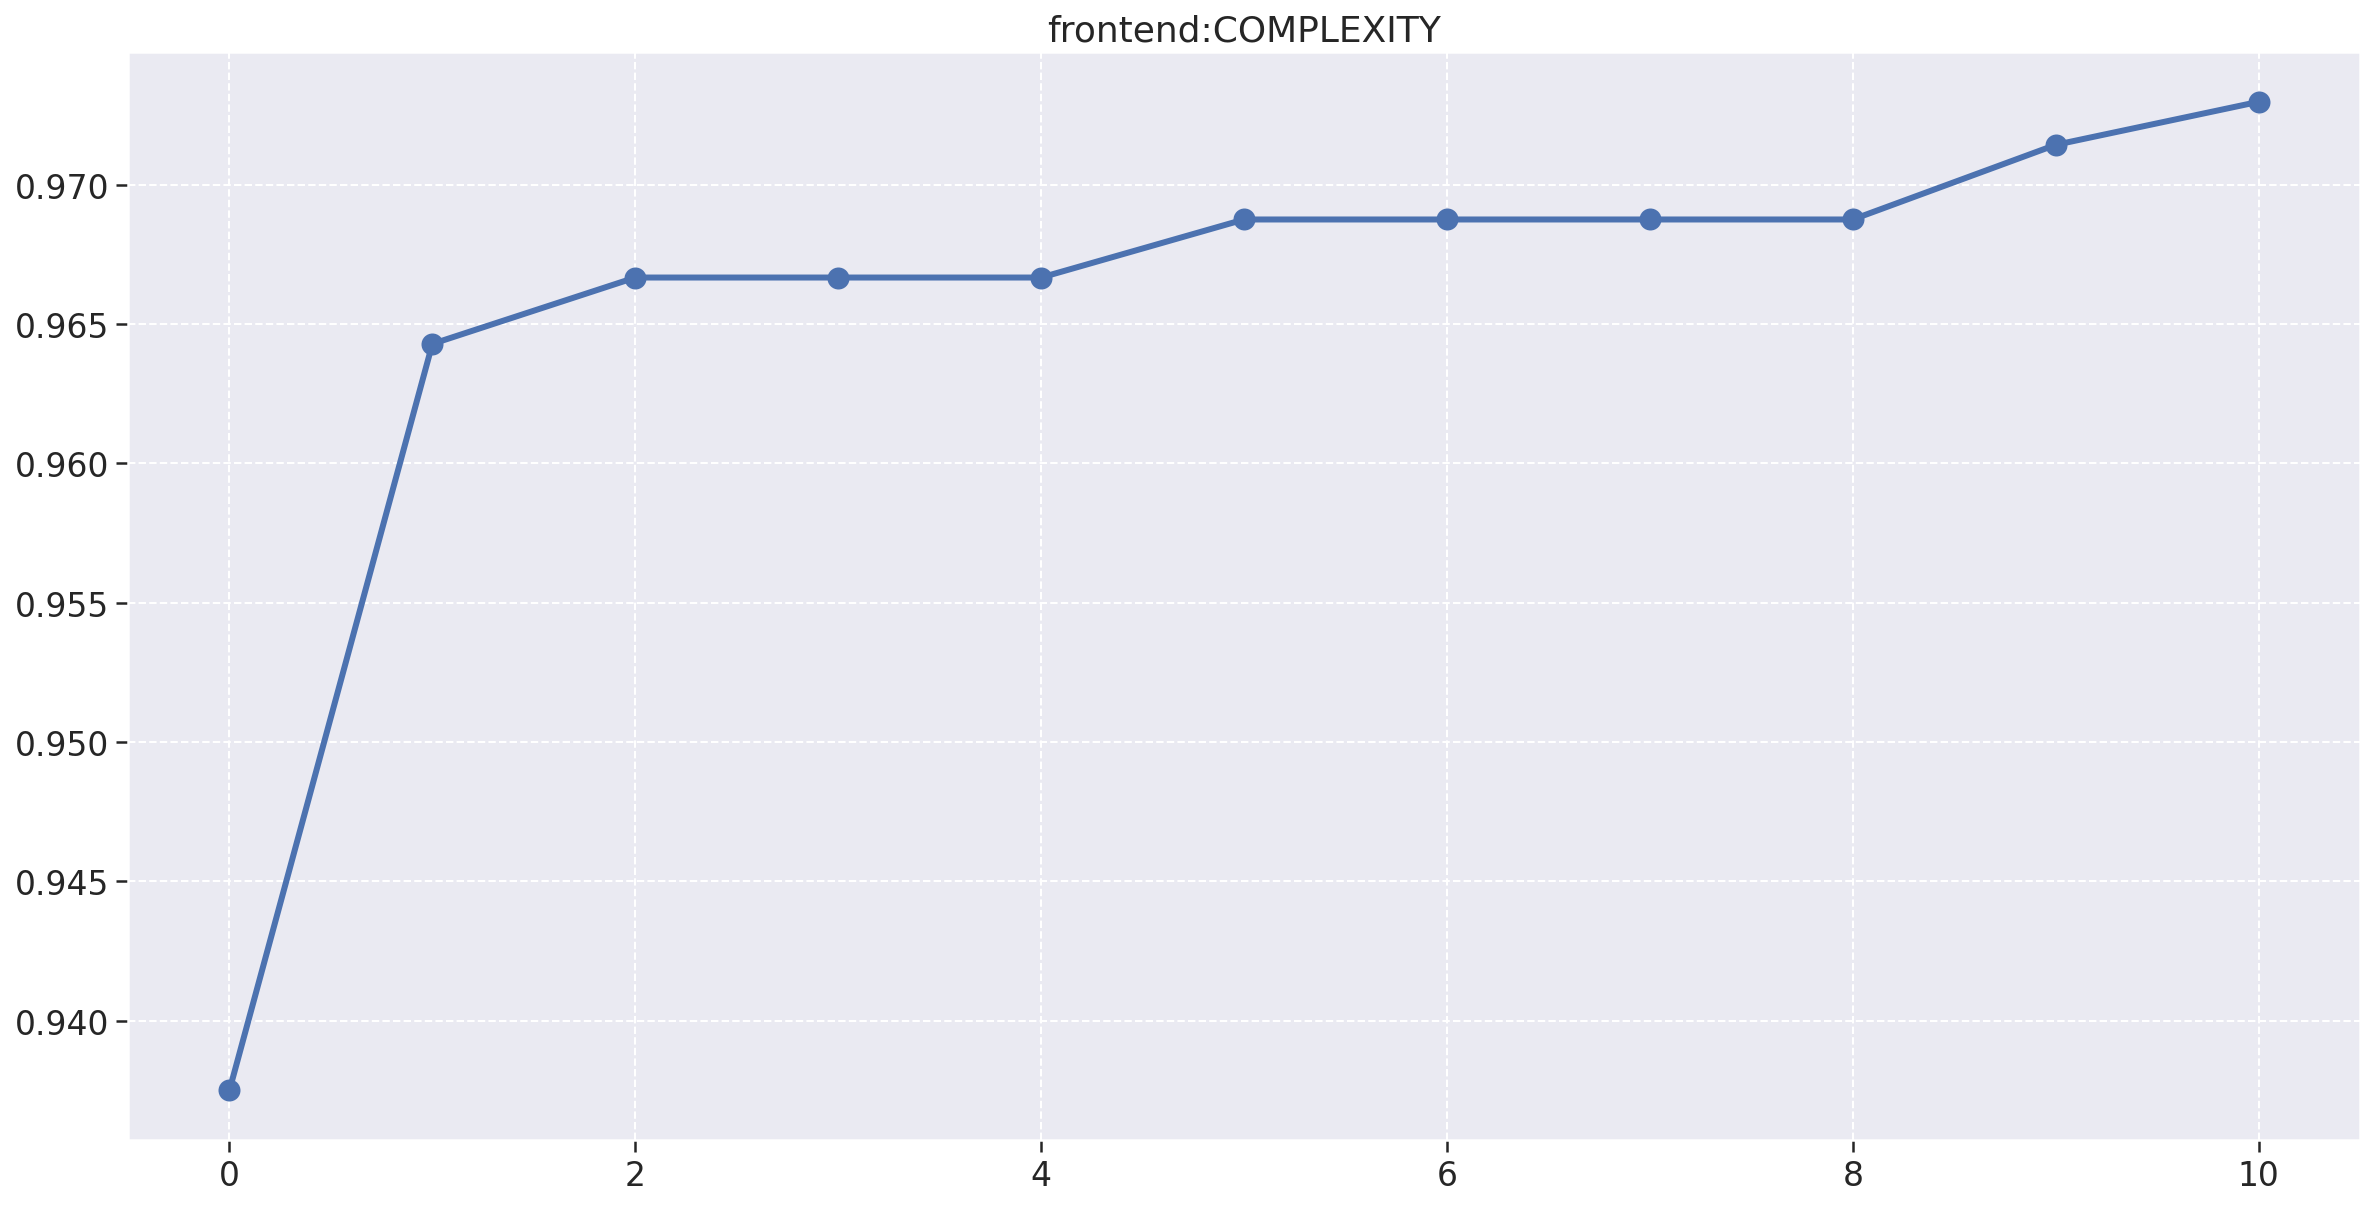

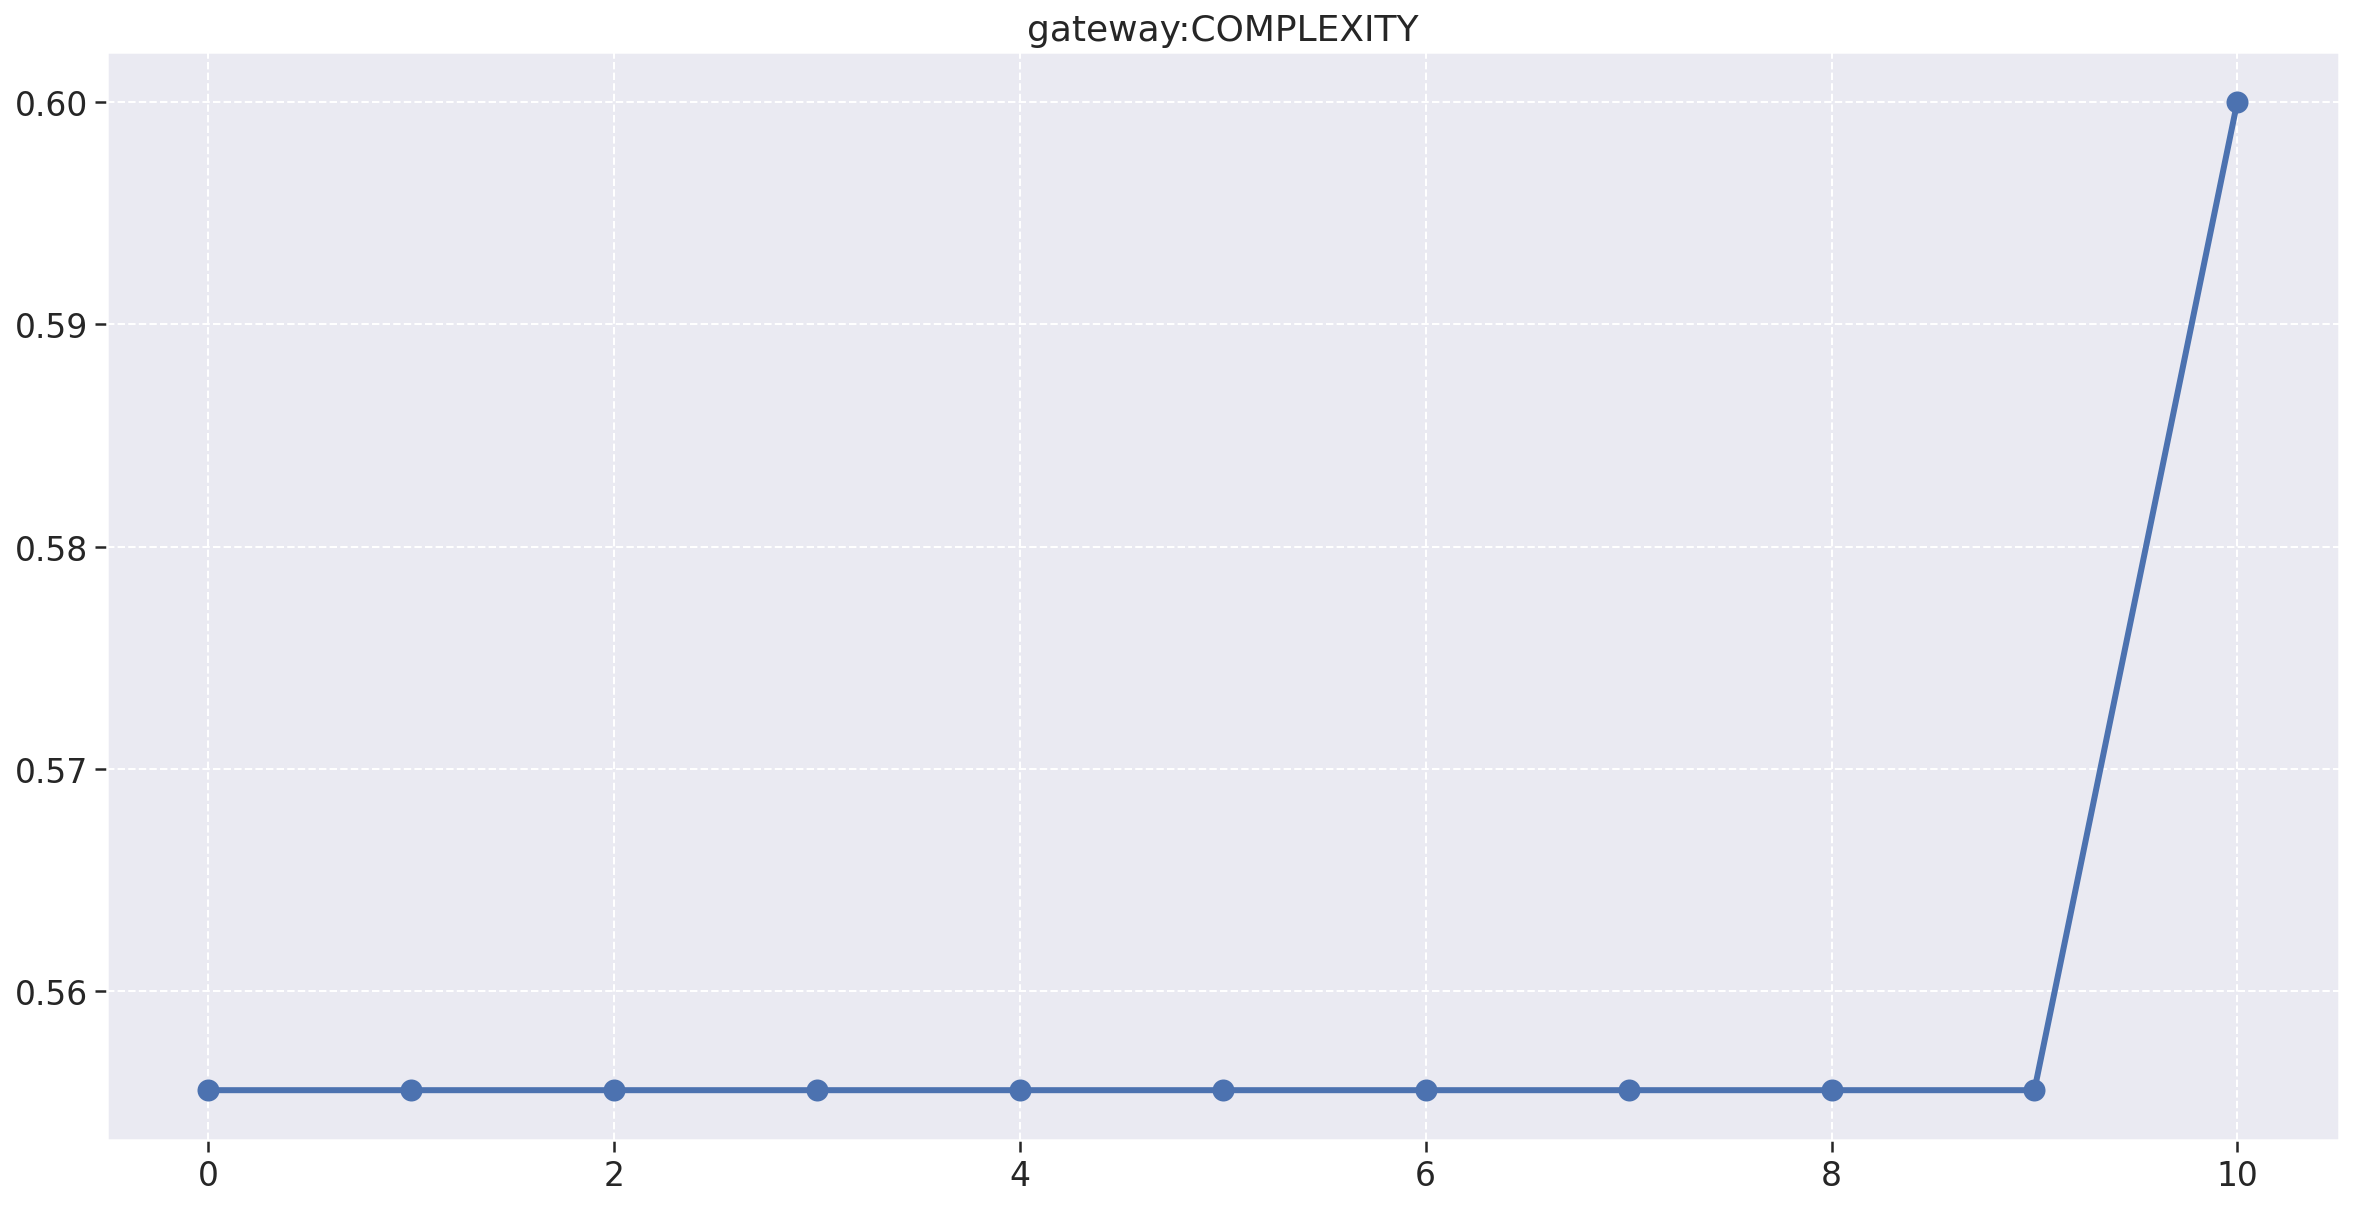

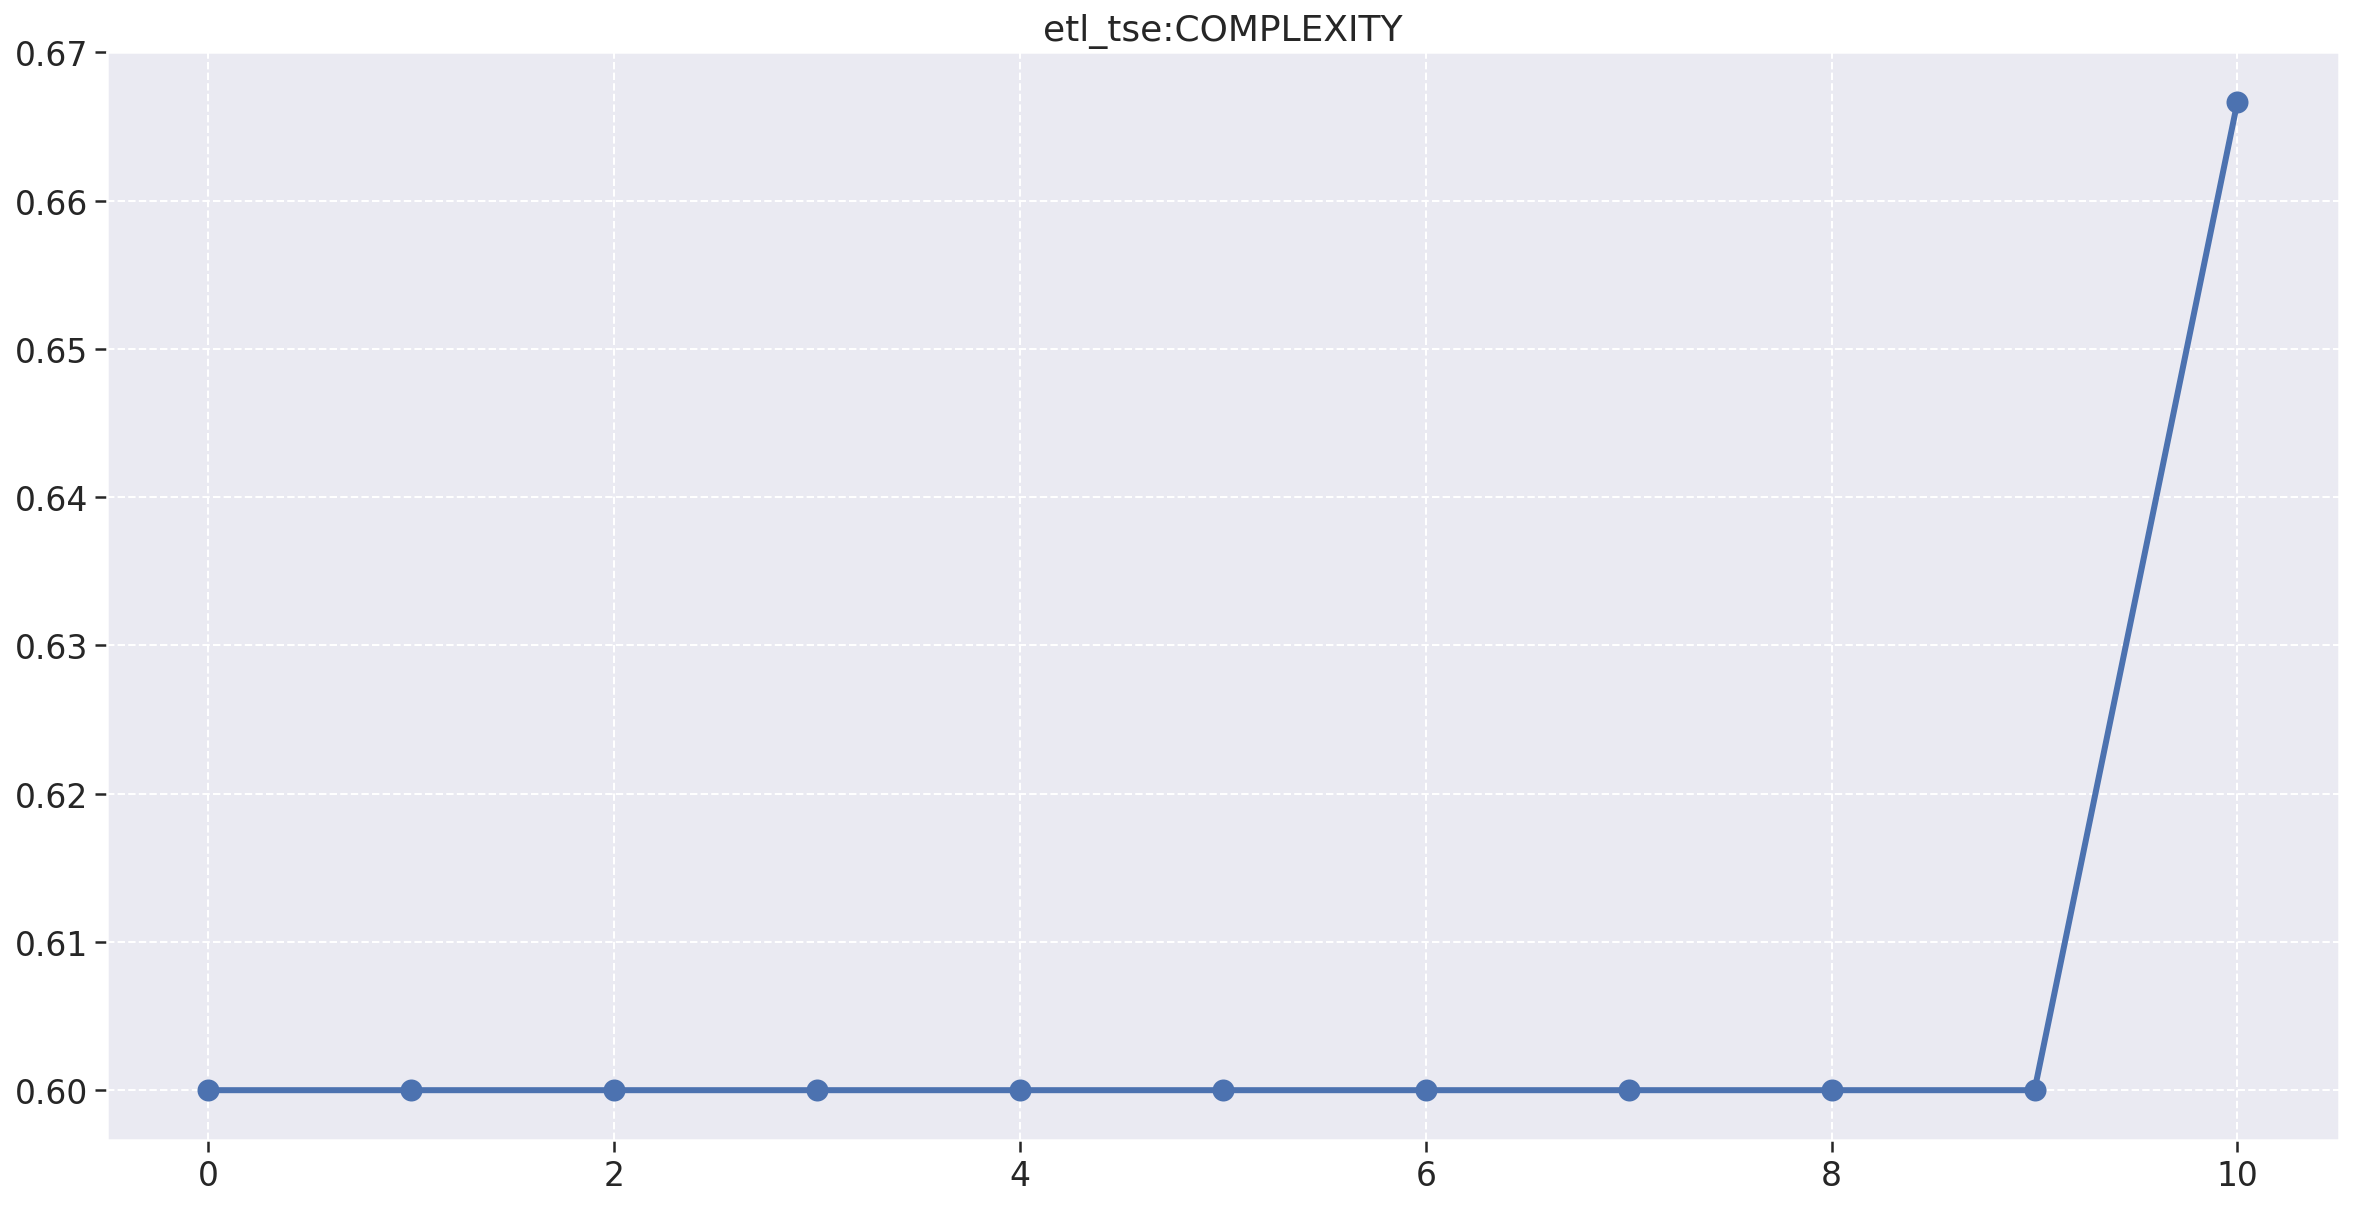

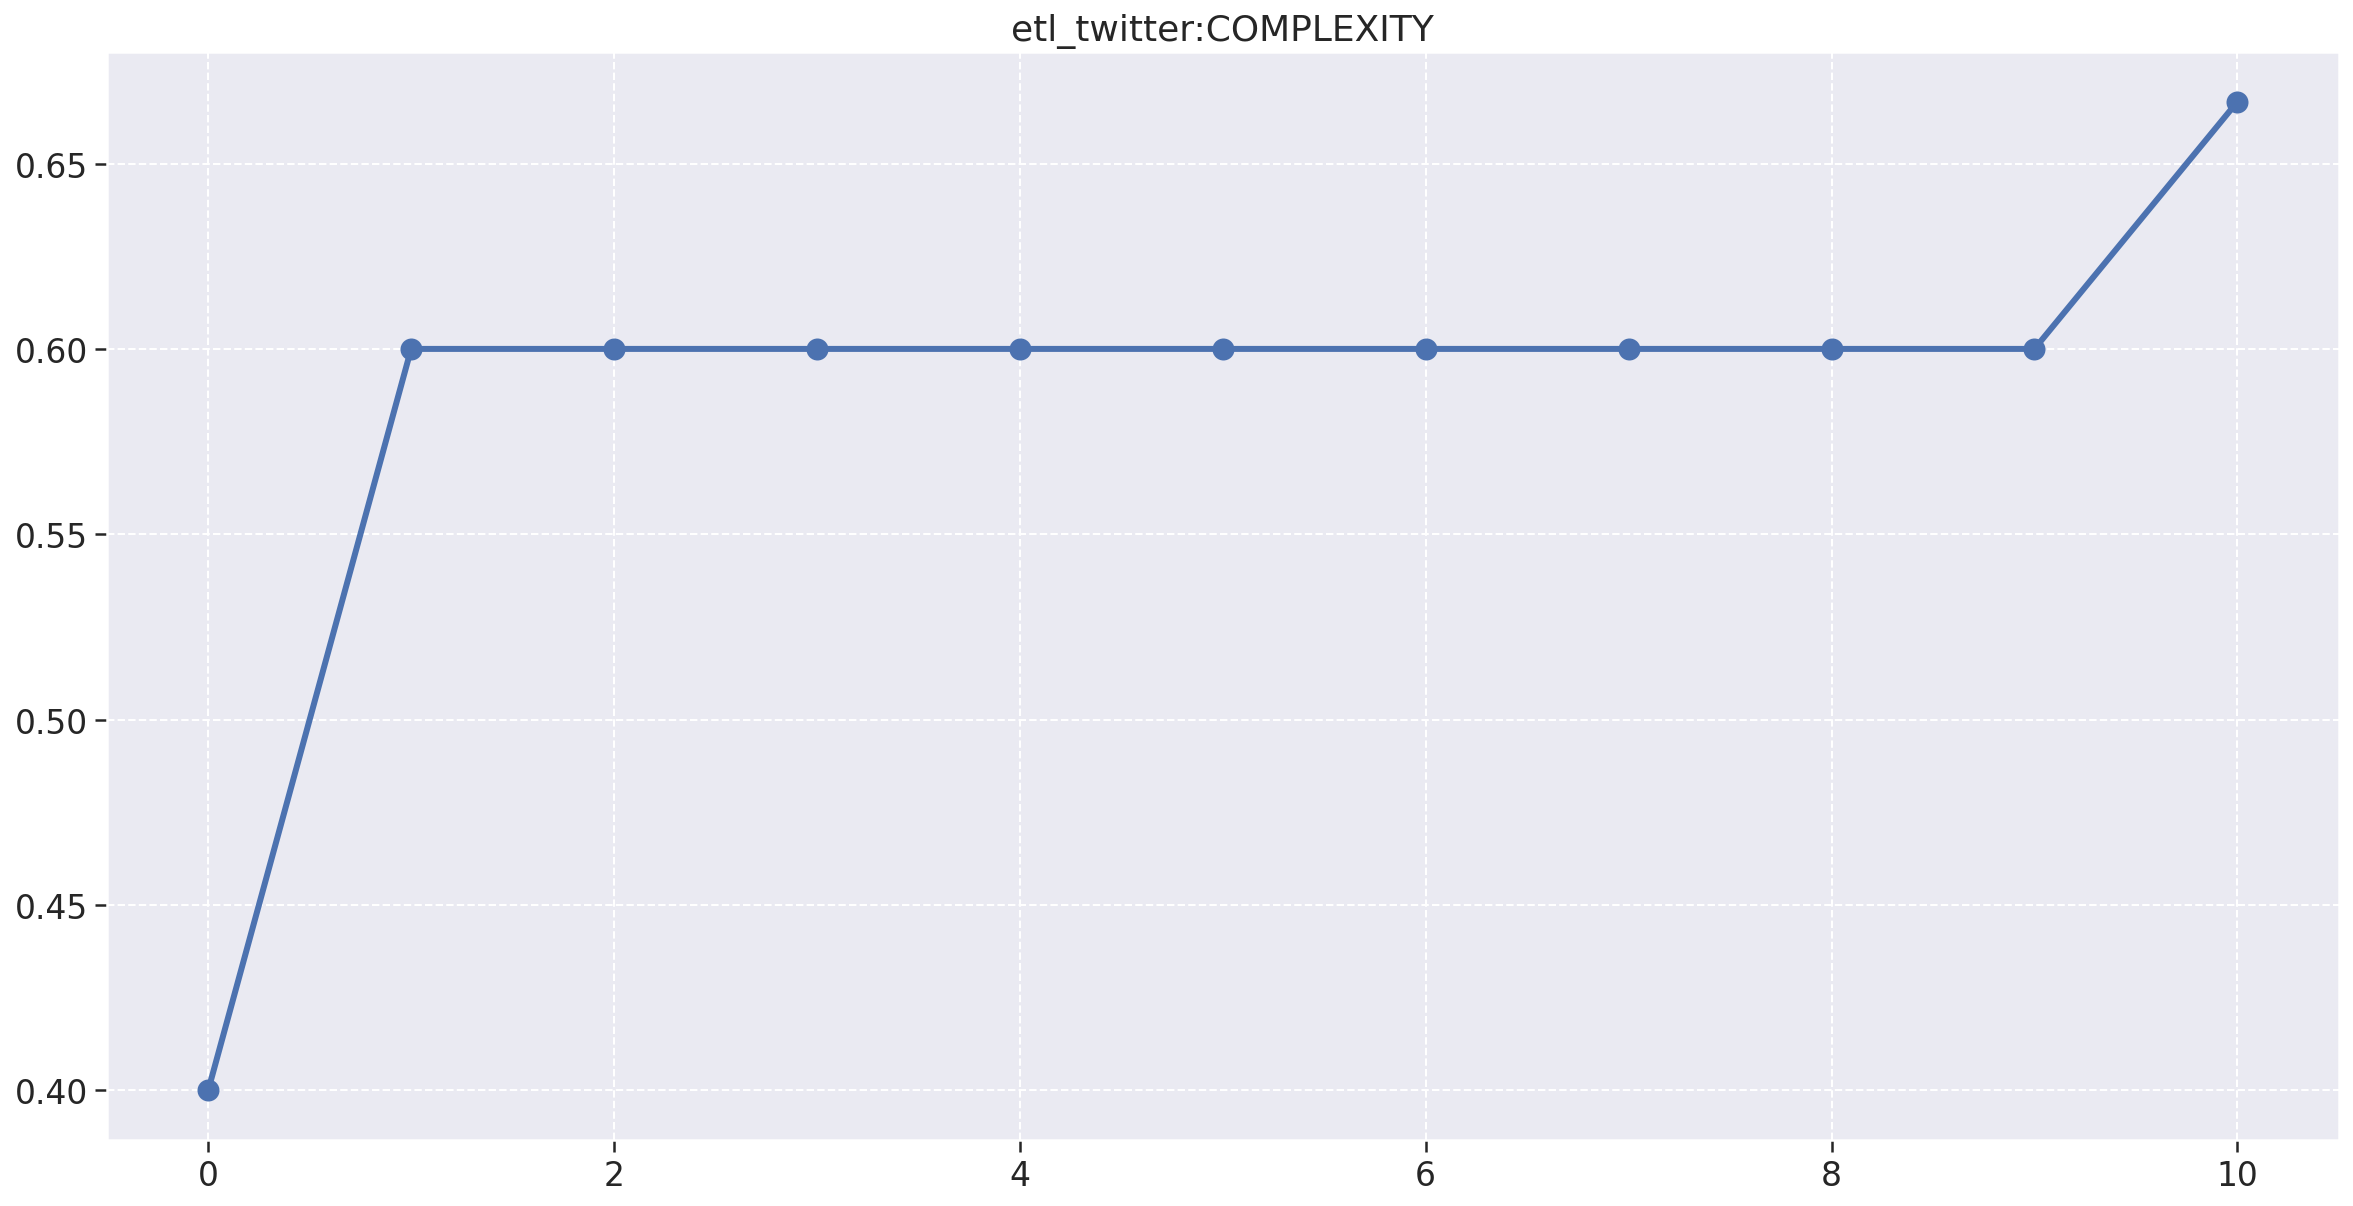

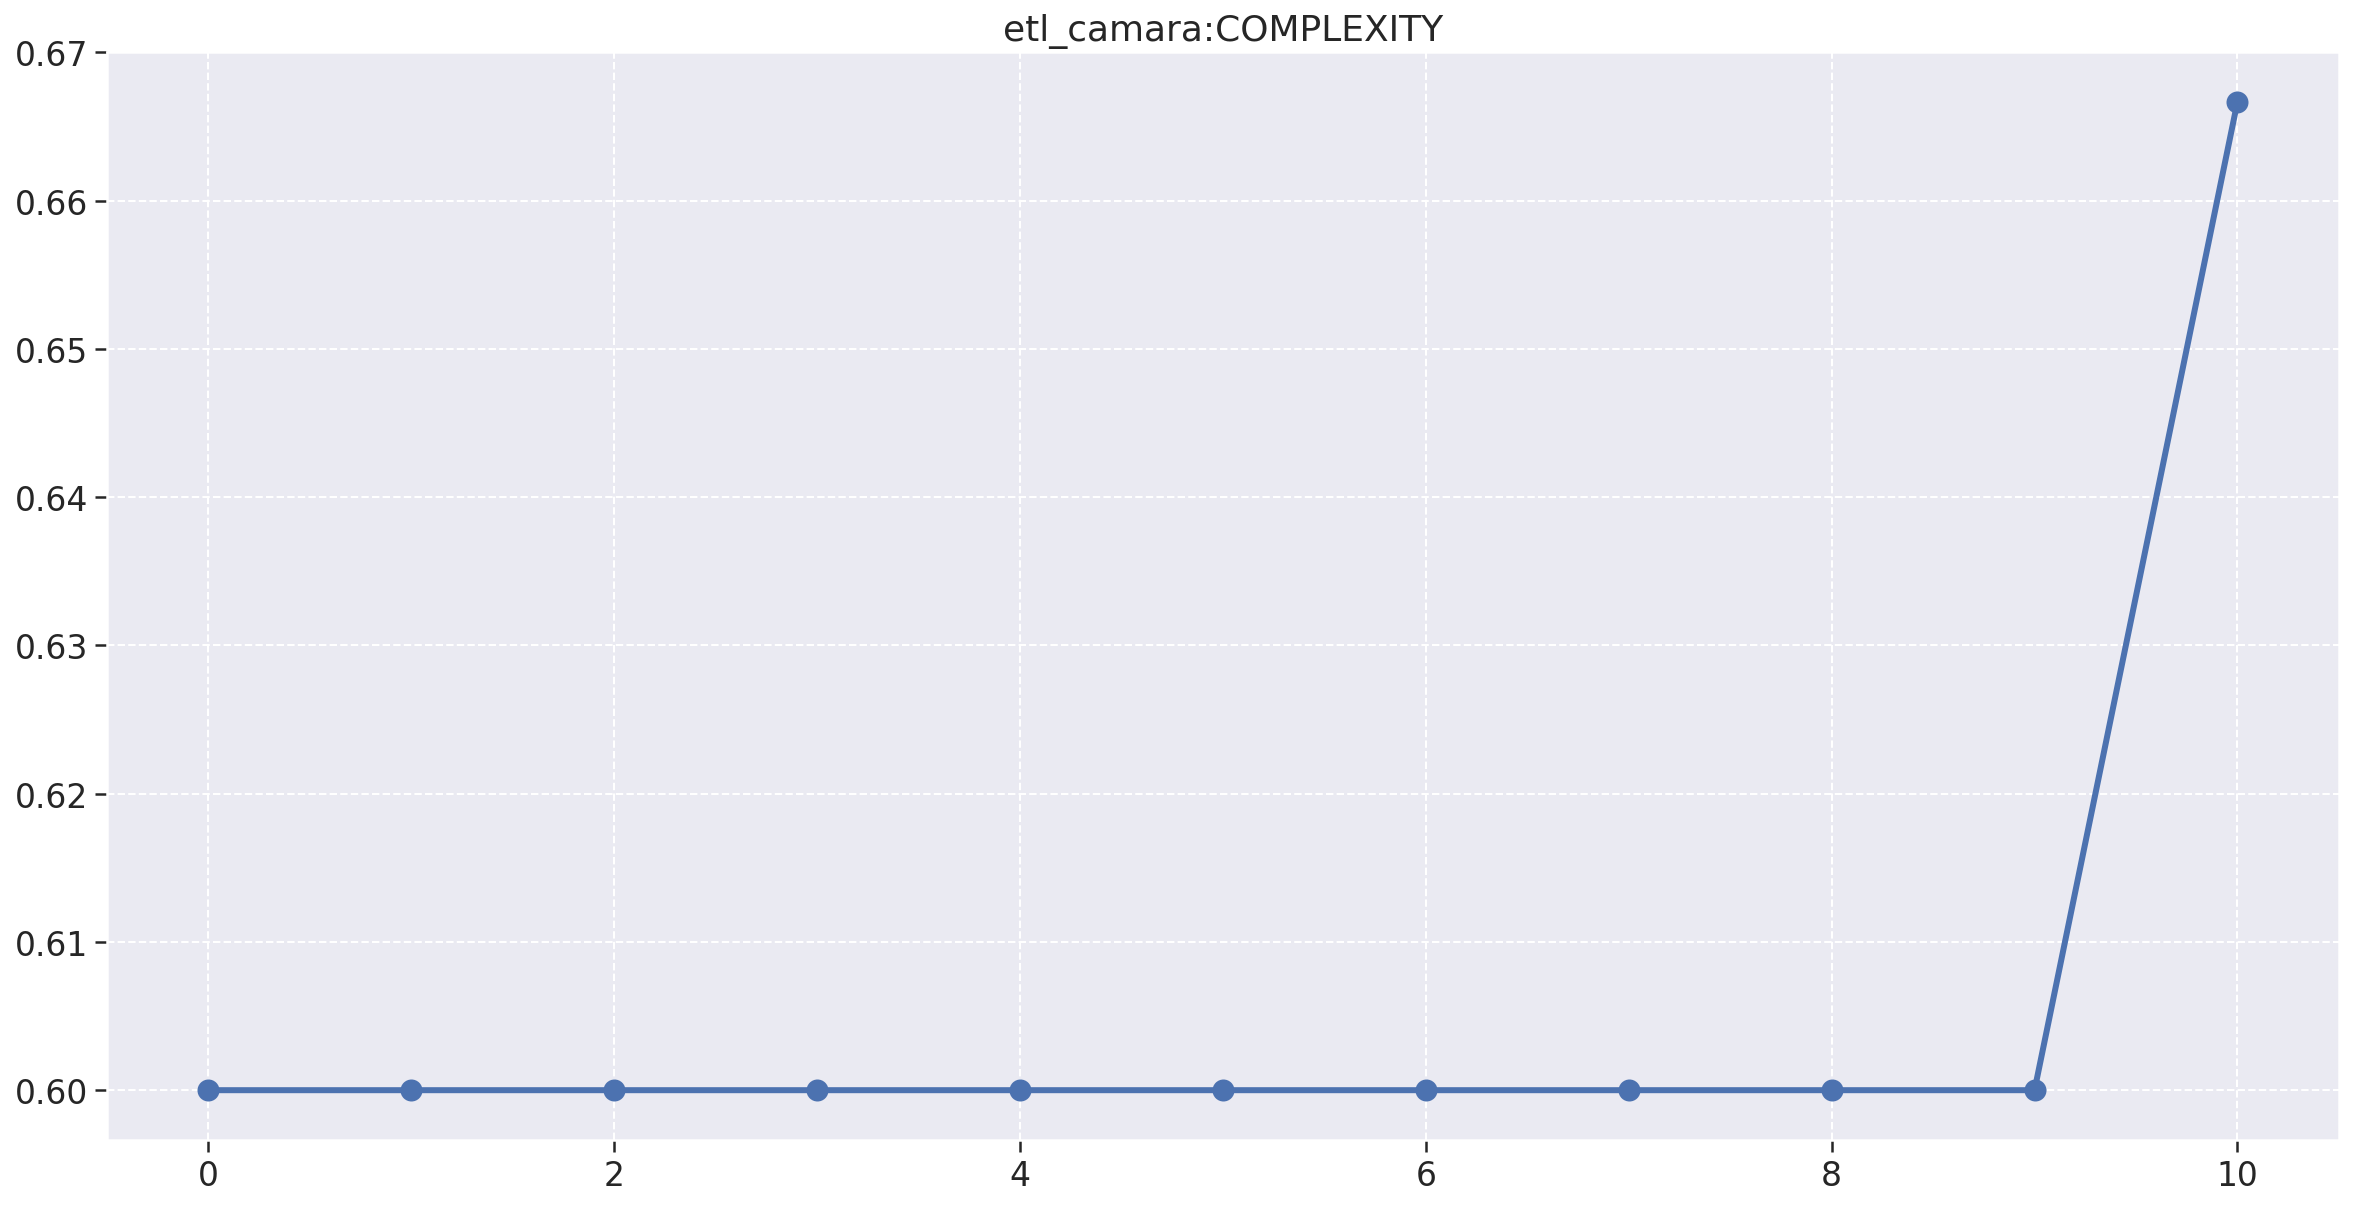

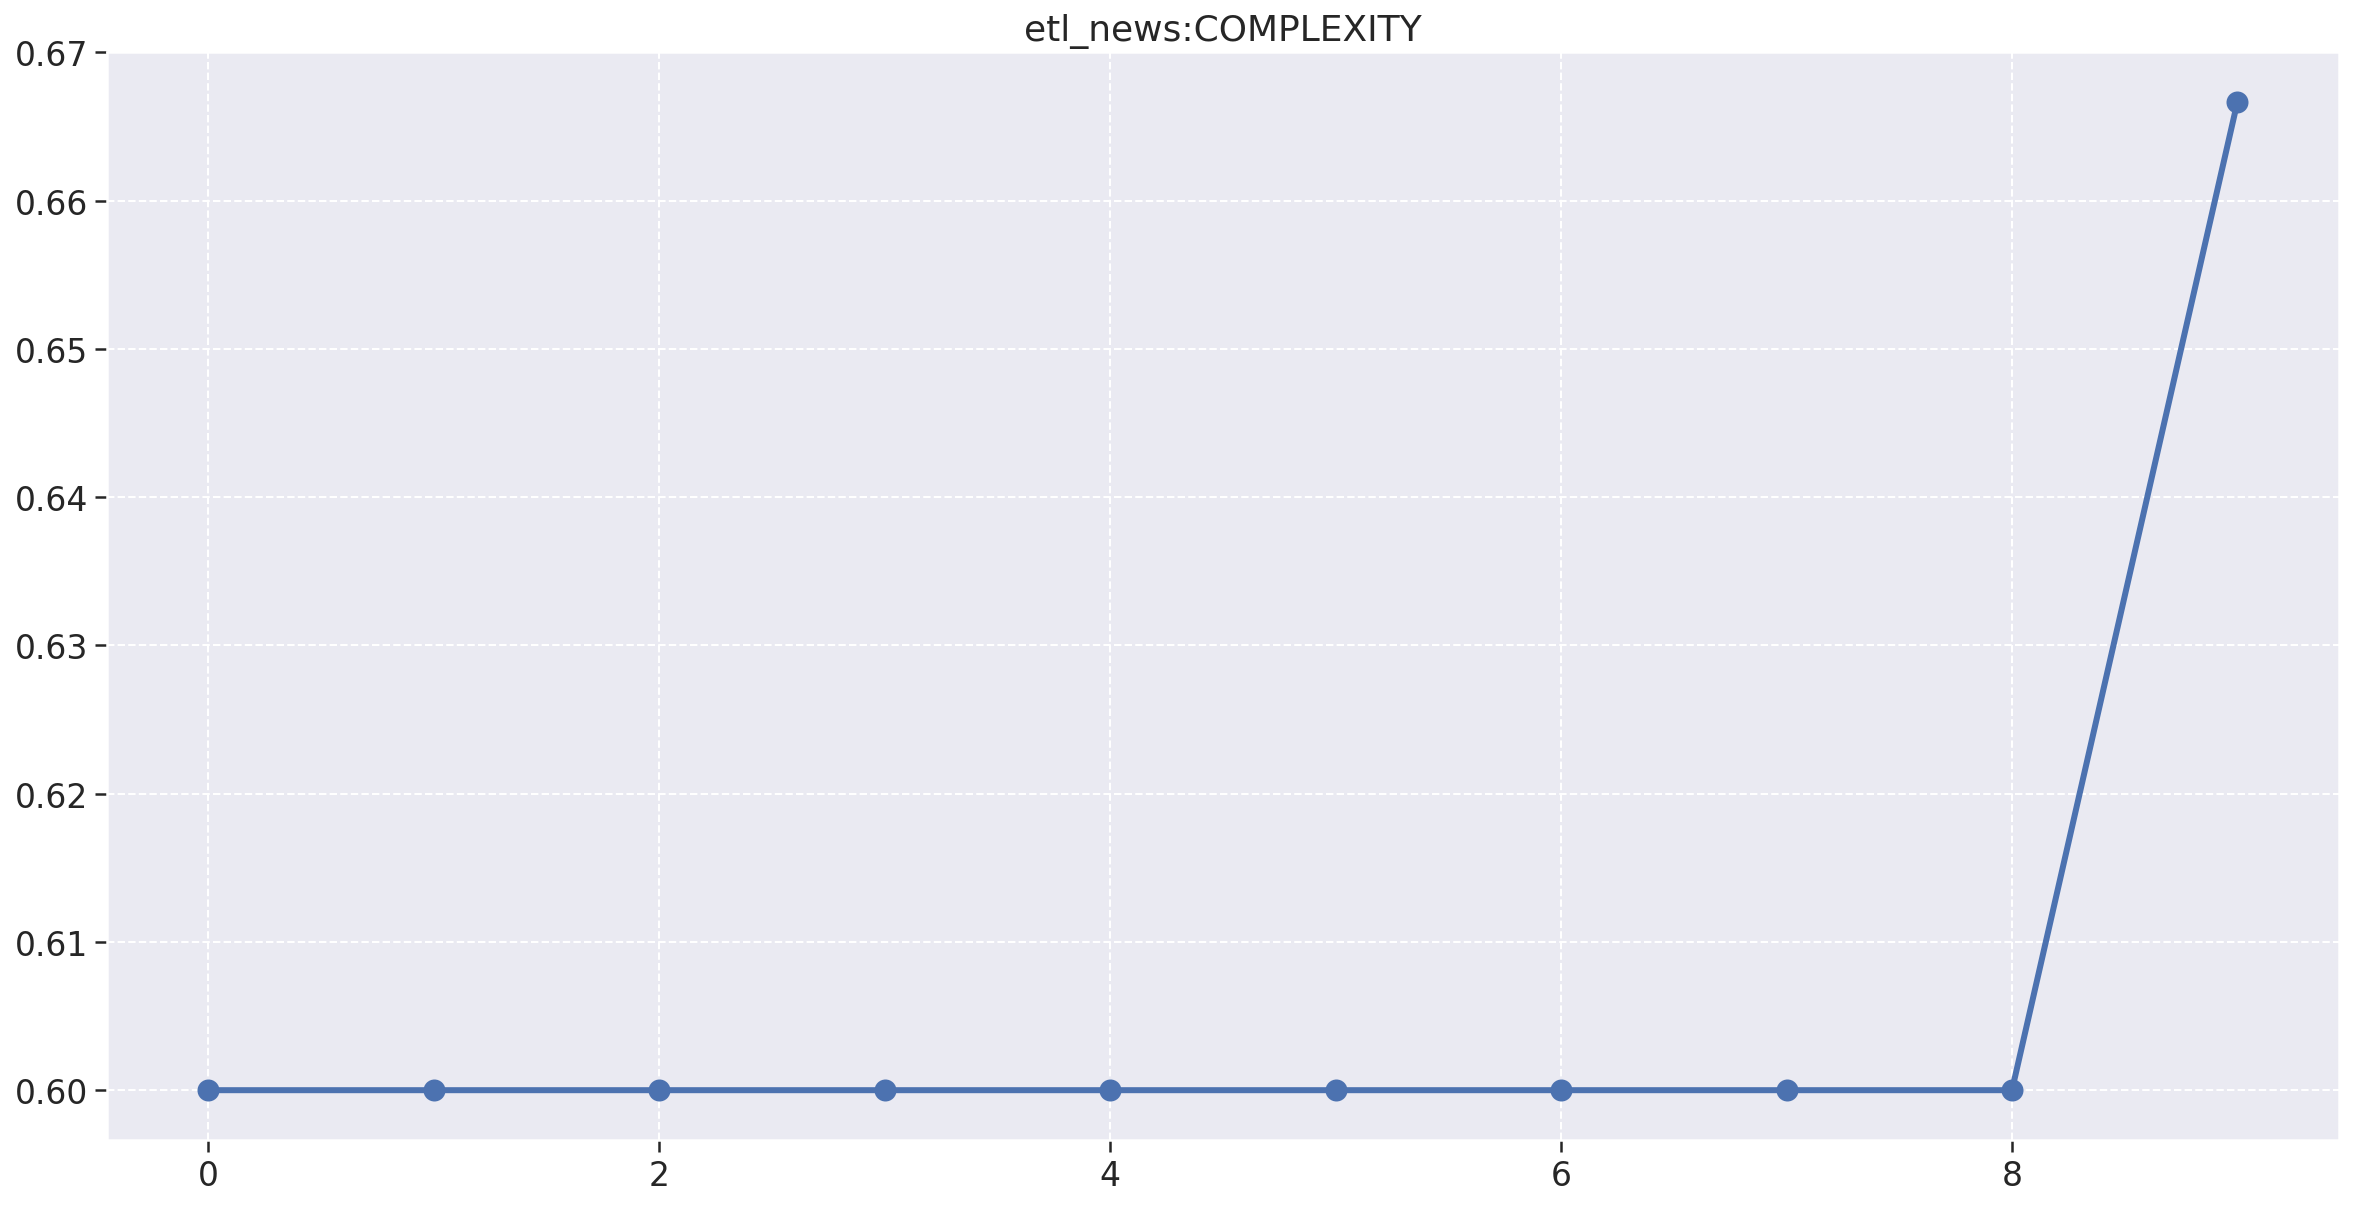

In [671]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMPLEXITY")
    plt.plot(metrics_df['m1'],linewidth=3, marker='o', markersize=10)

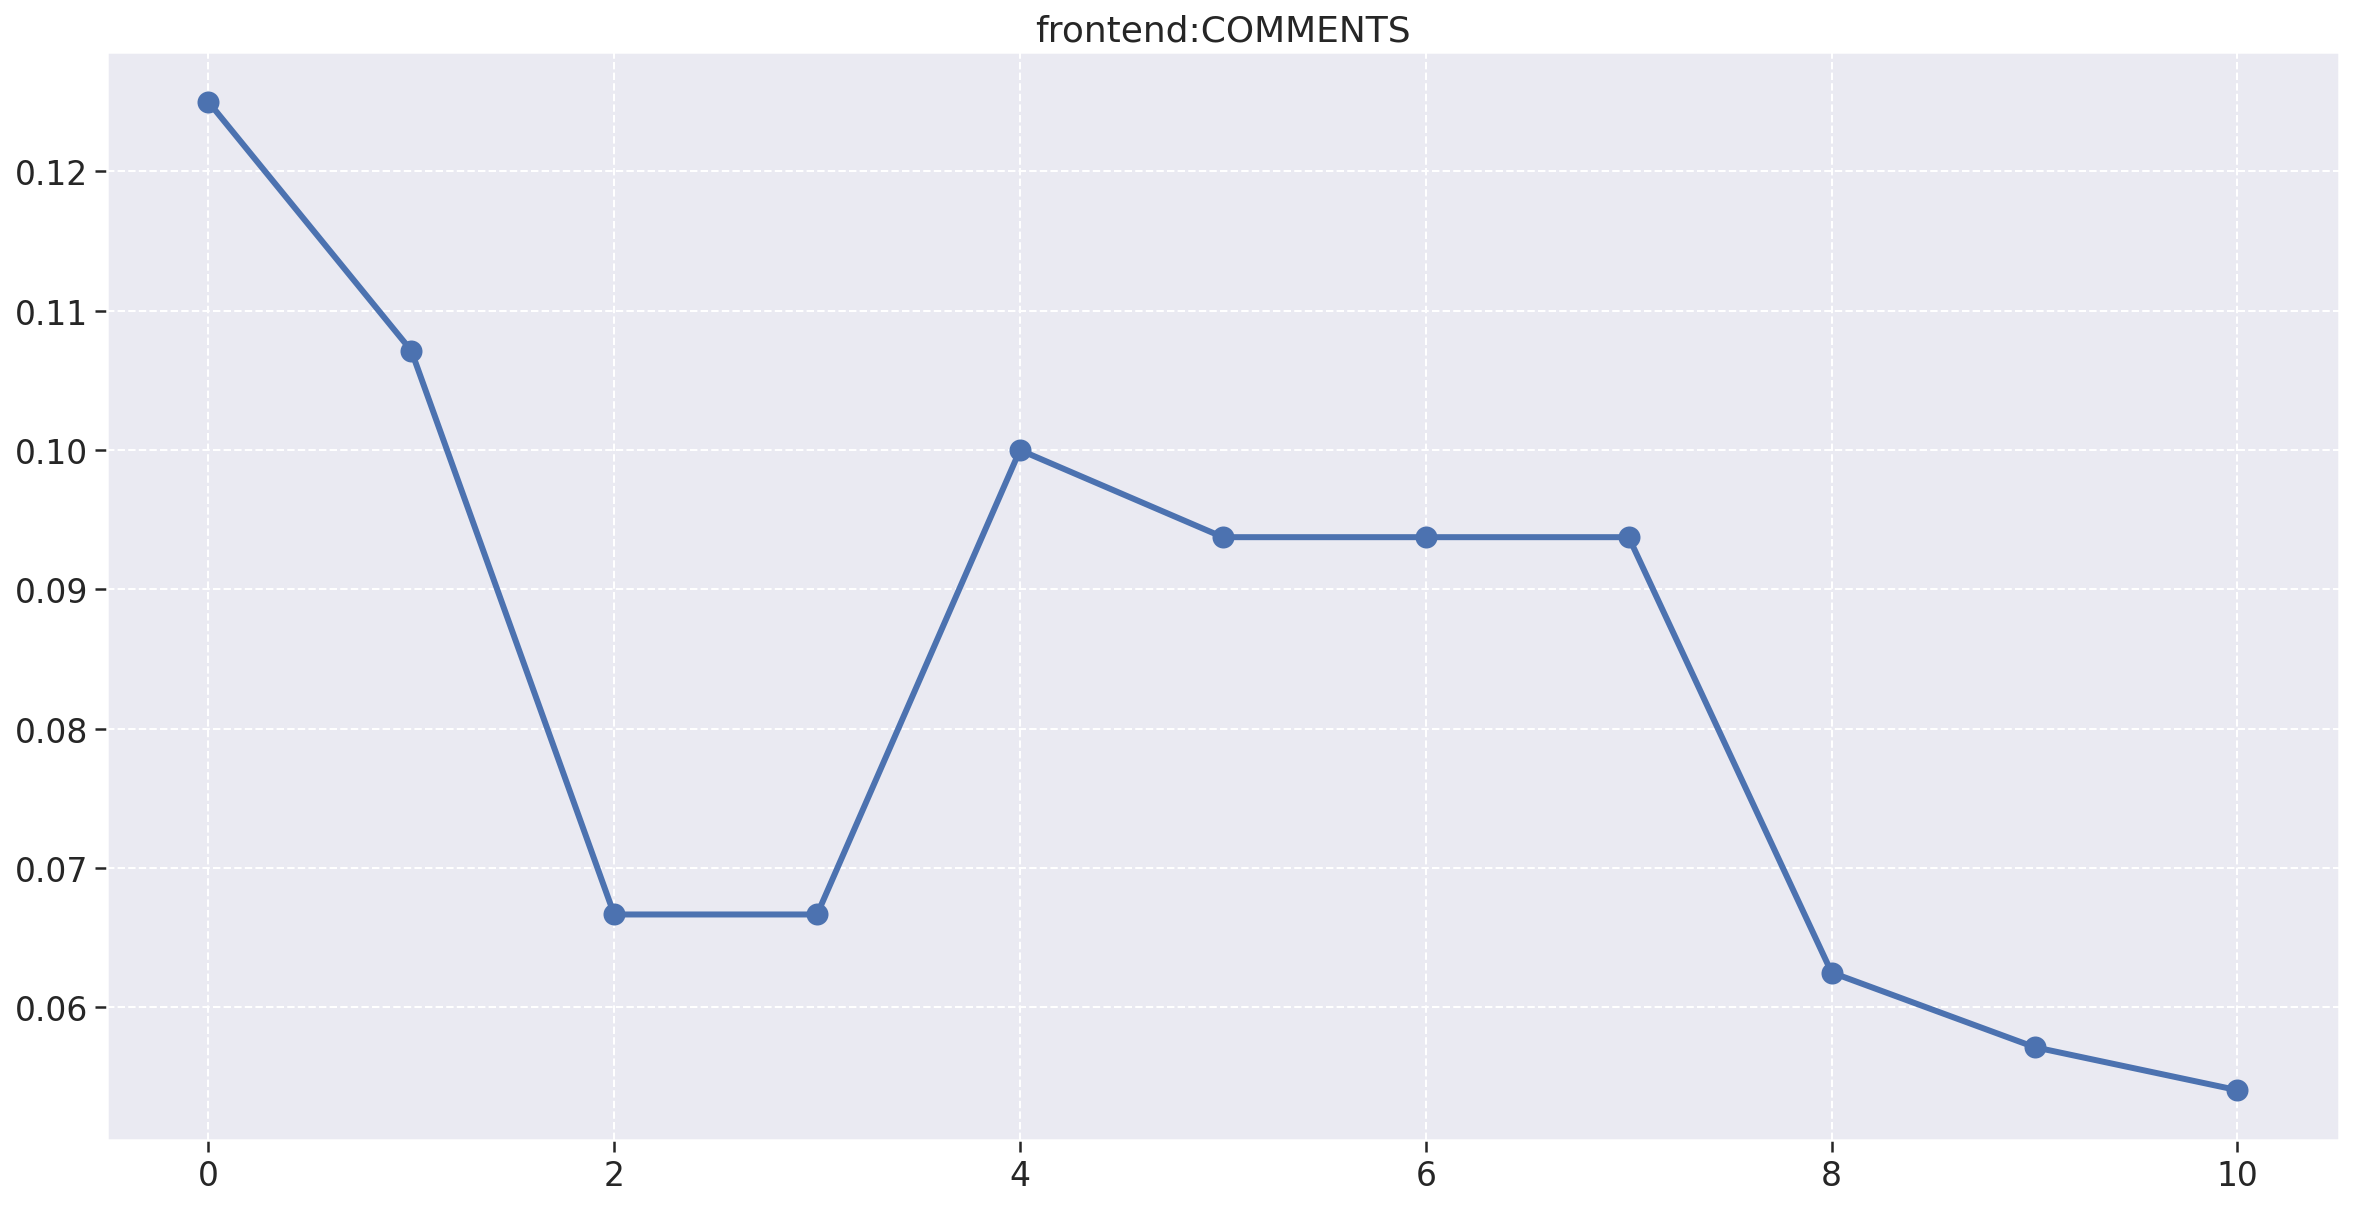

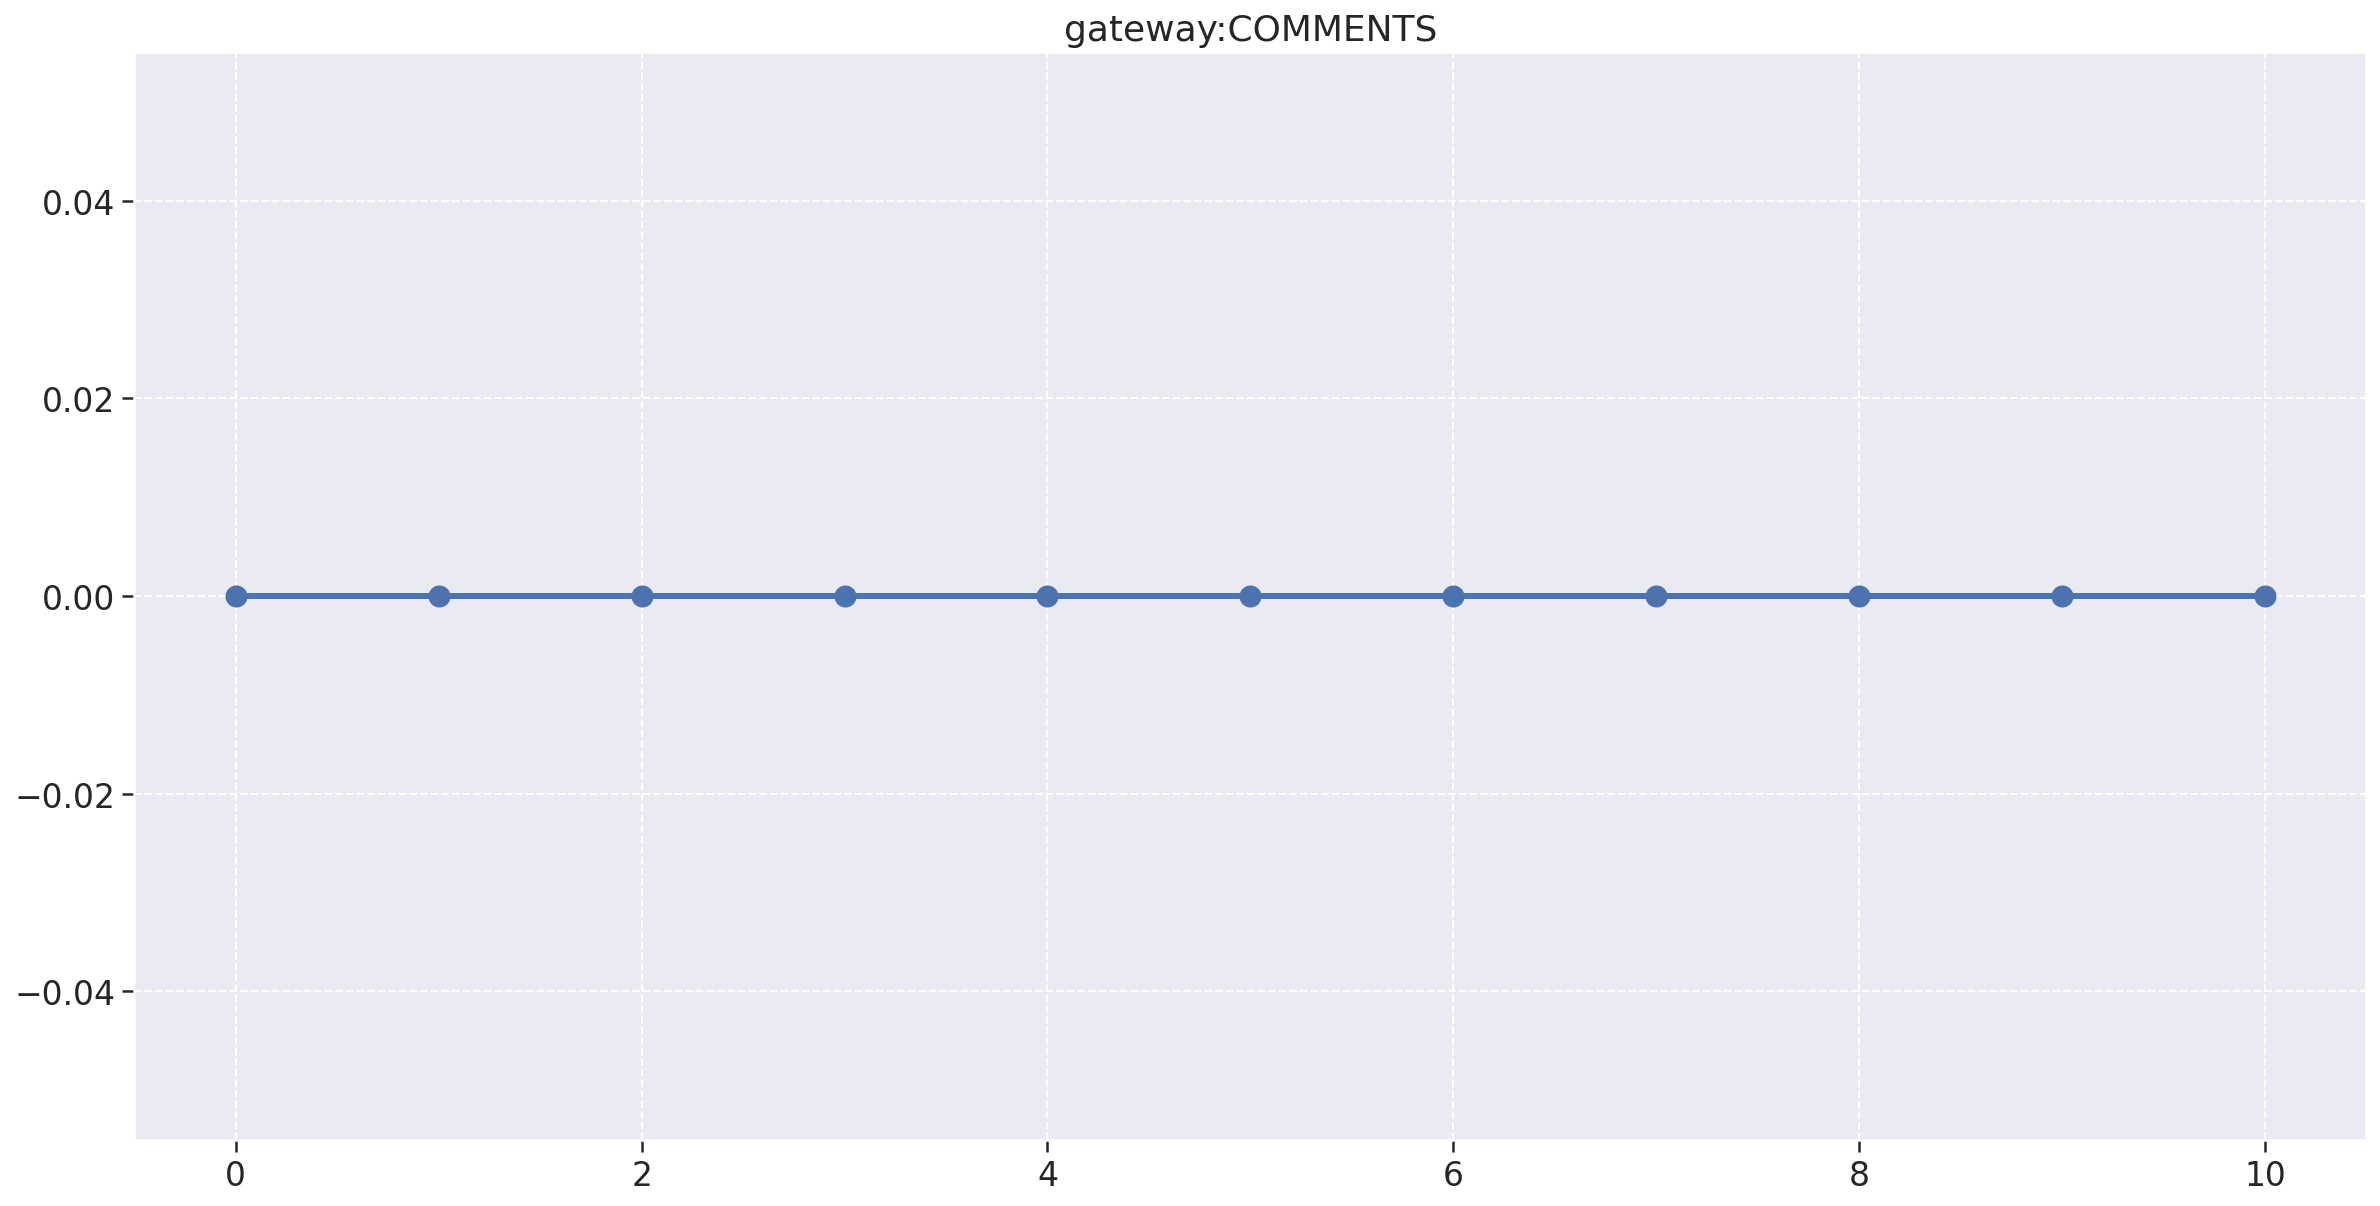

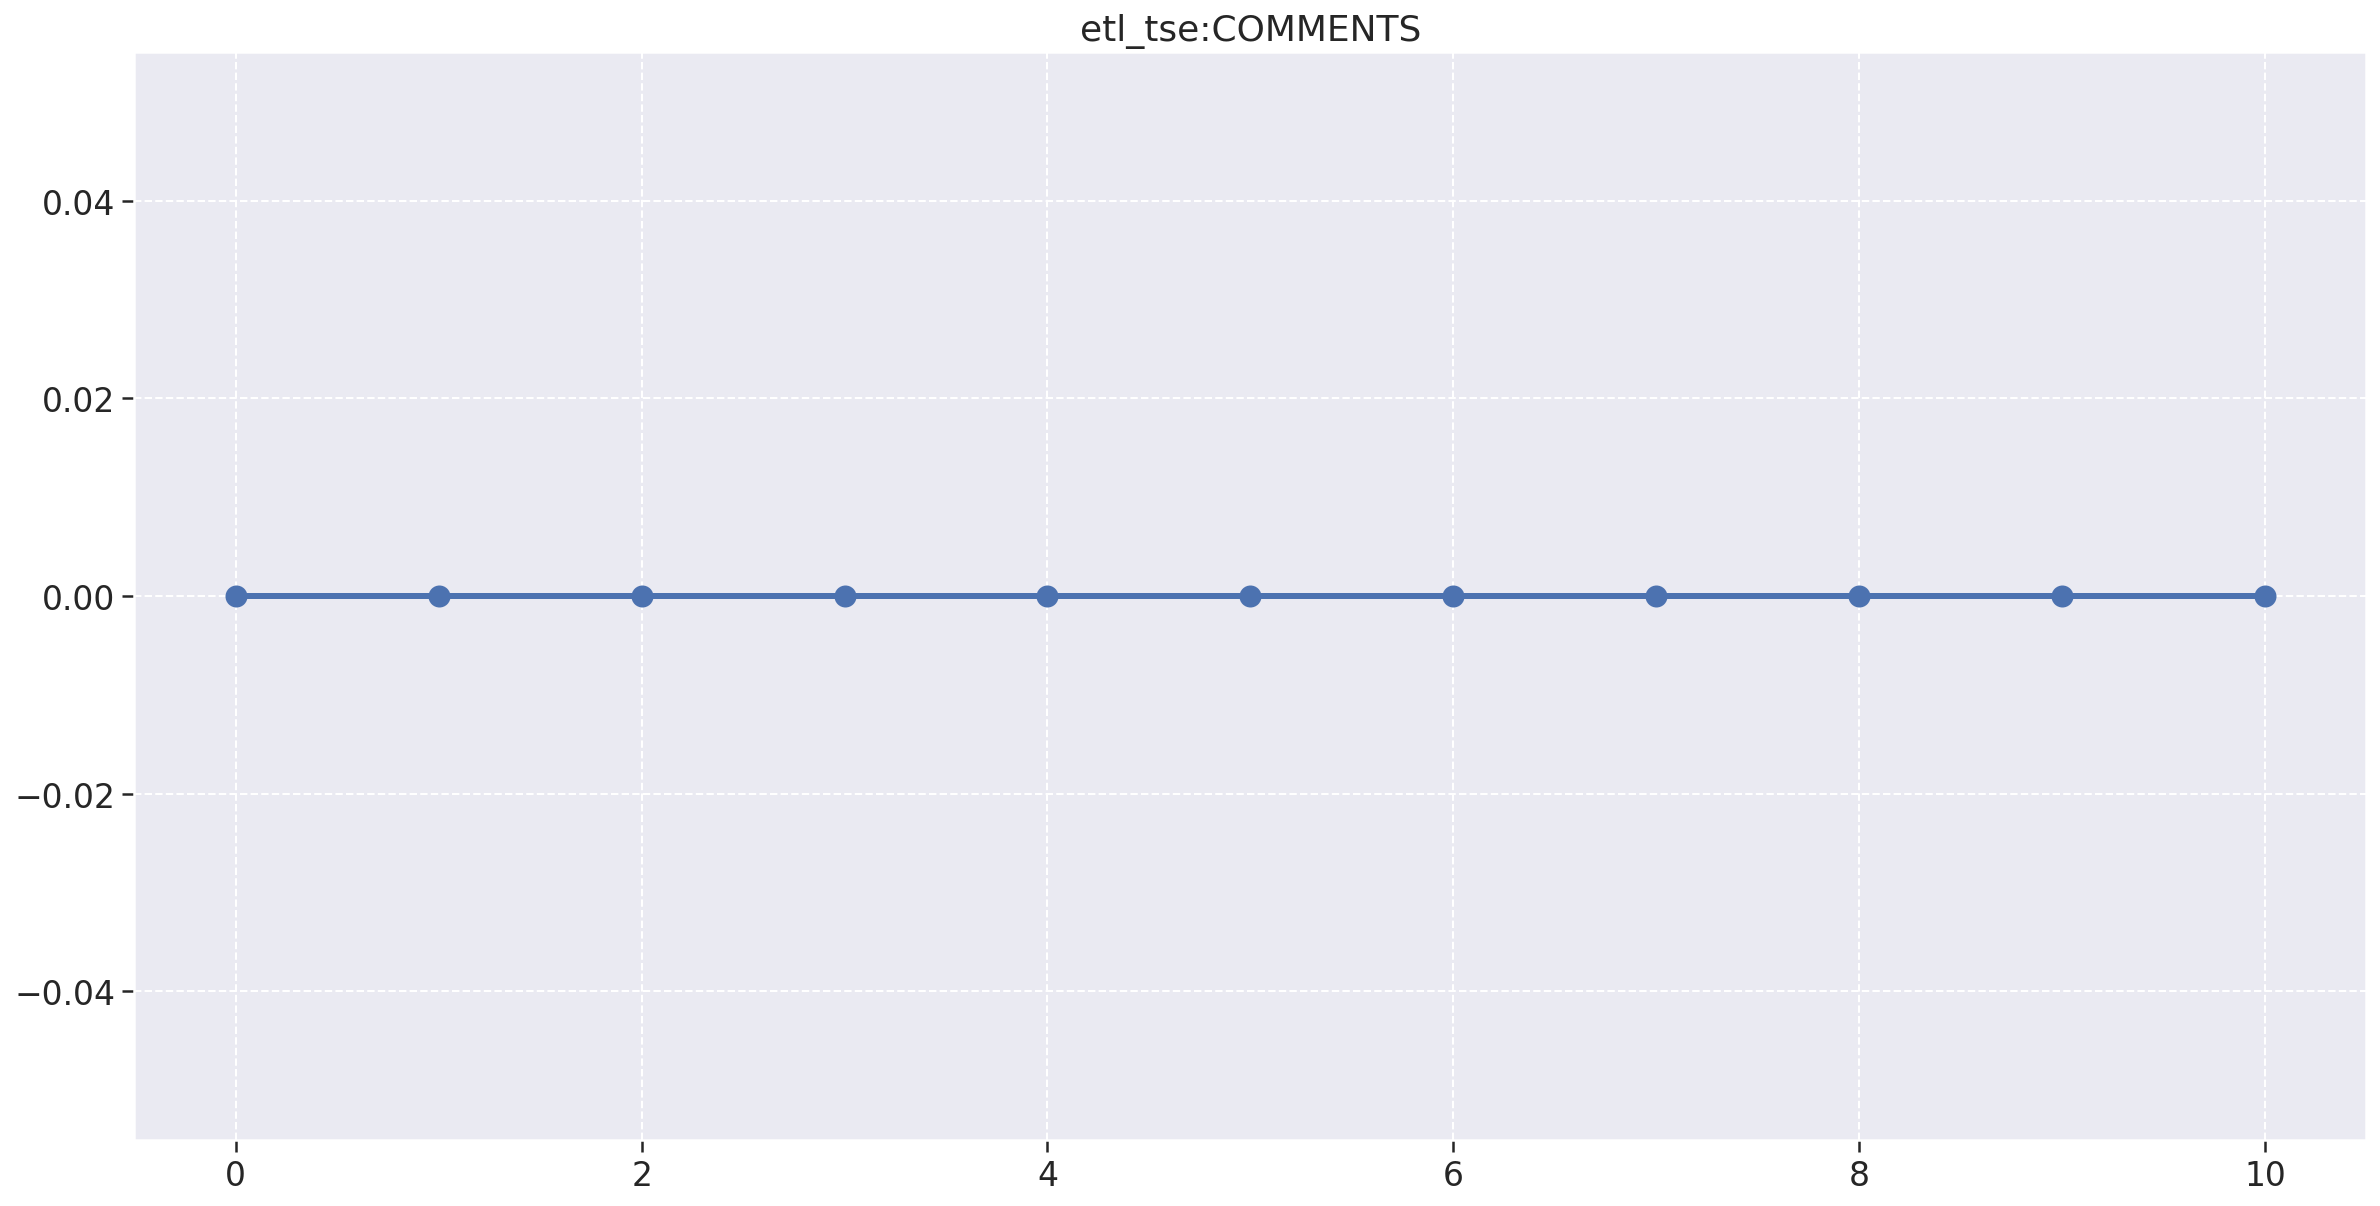

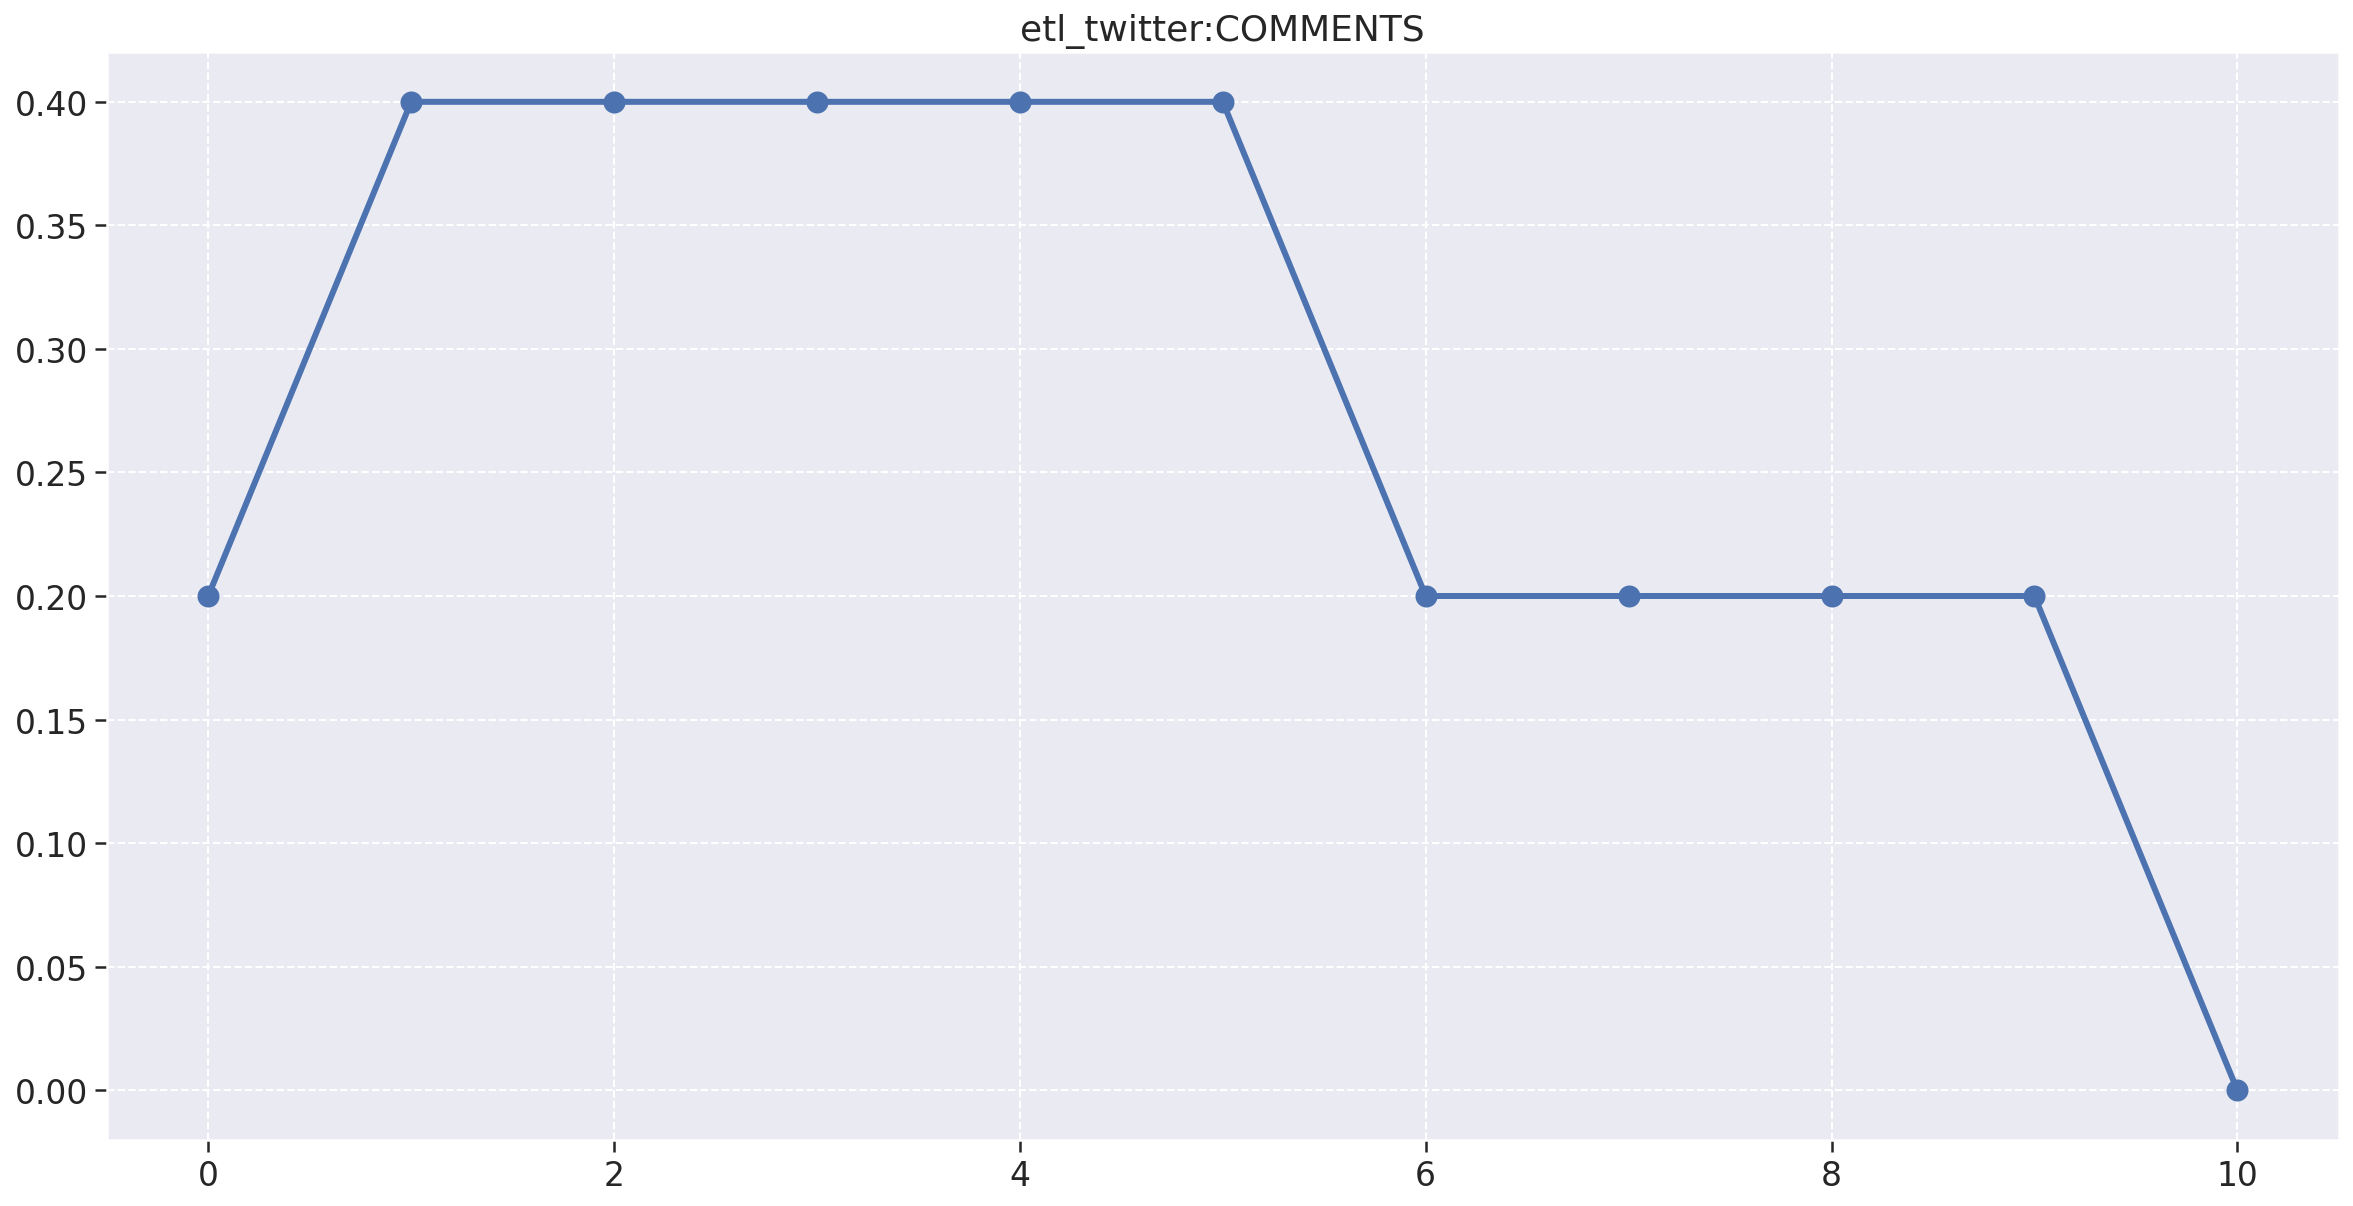

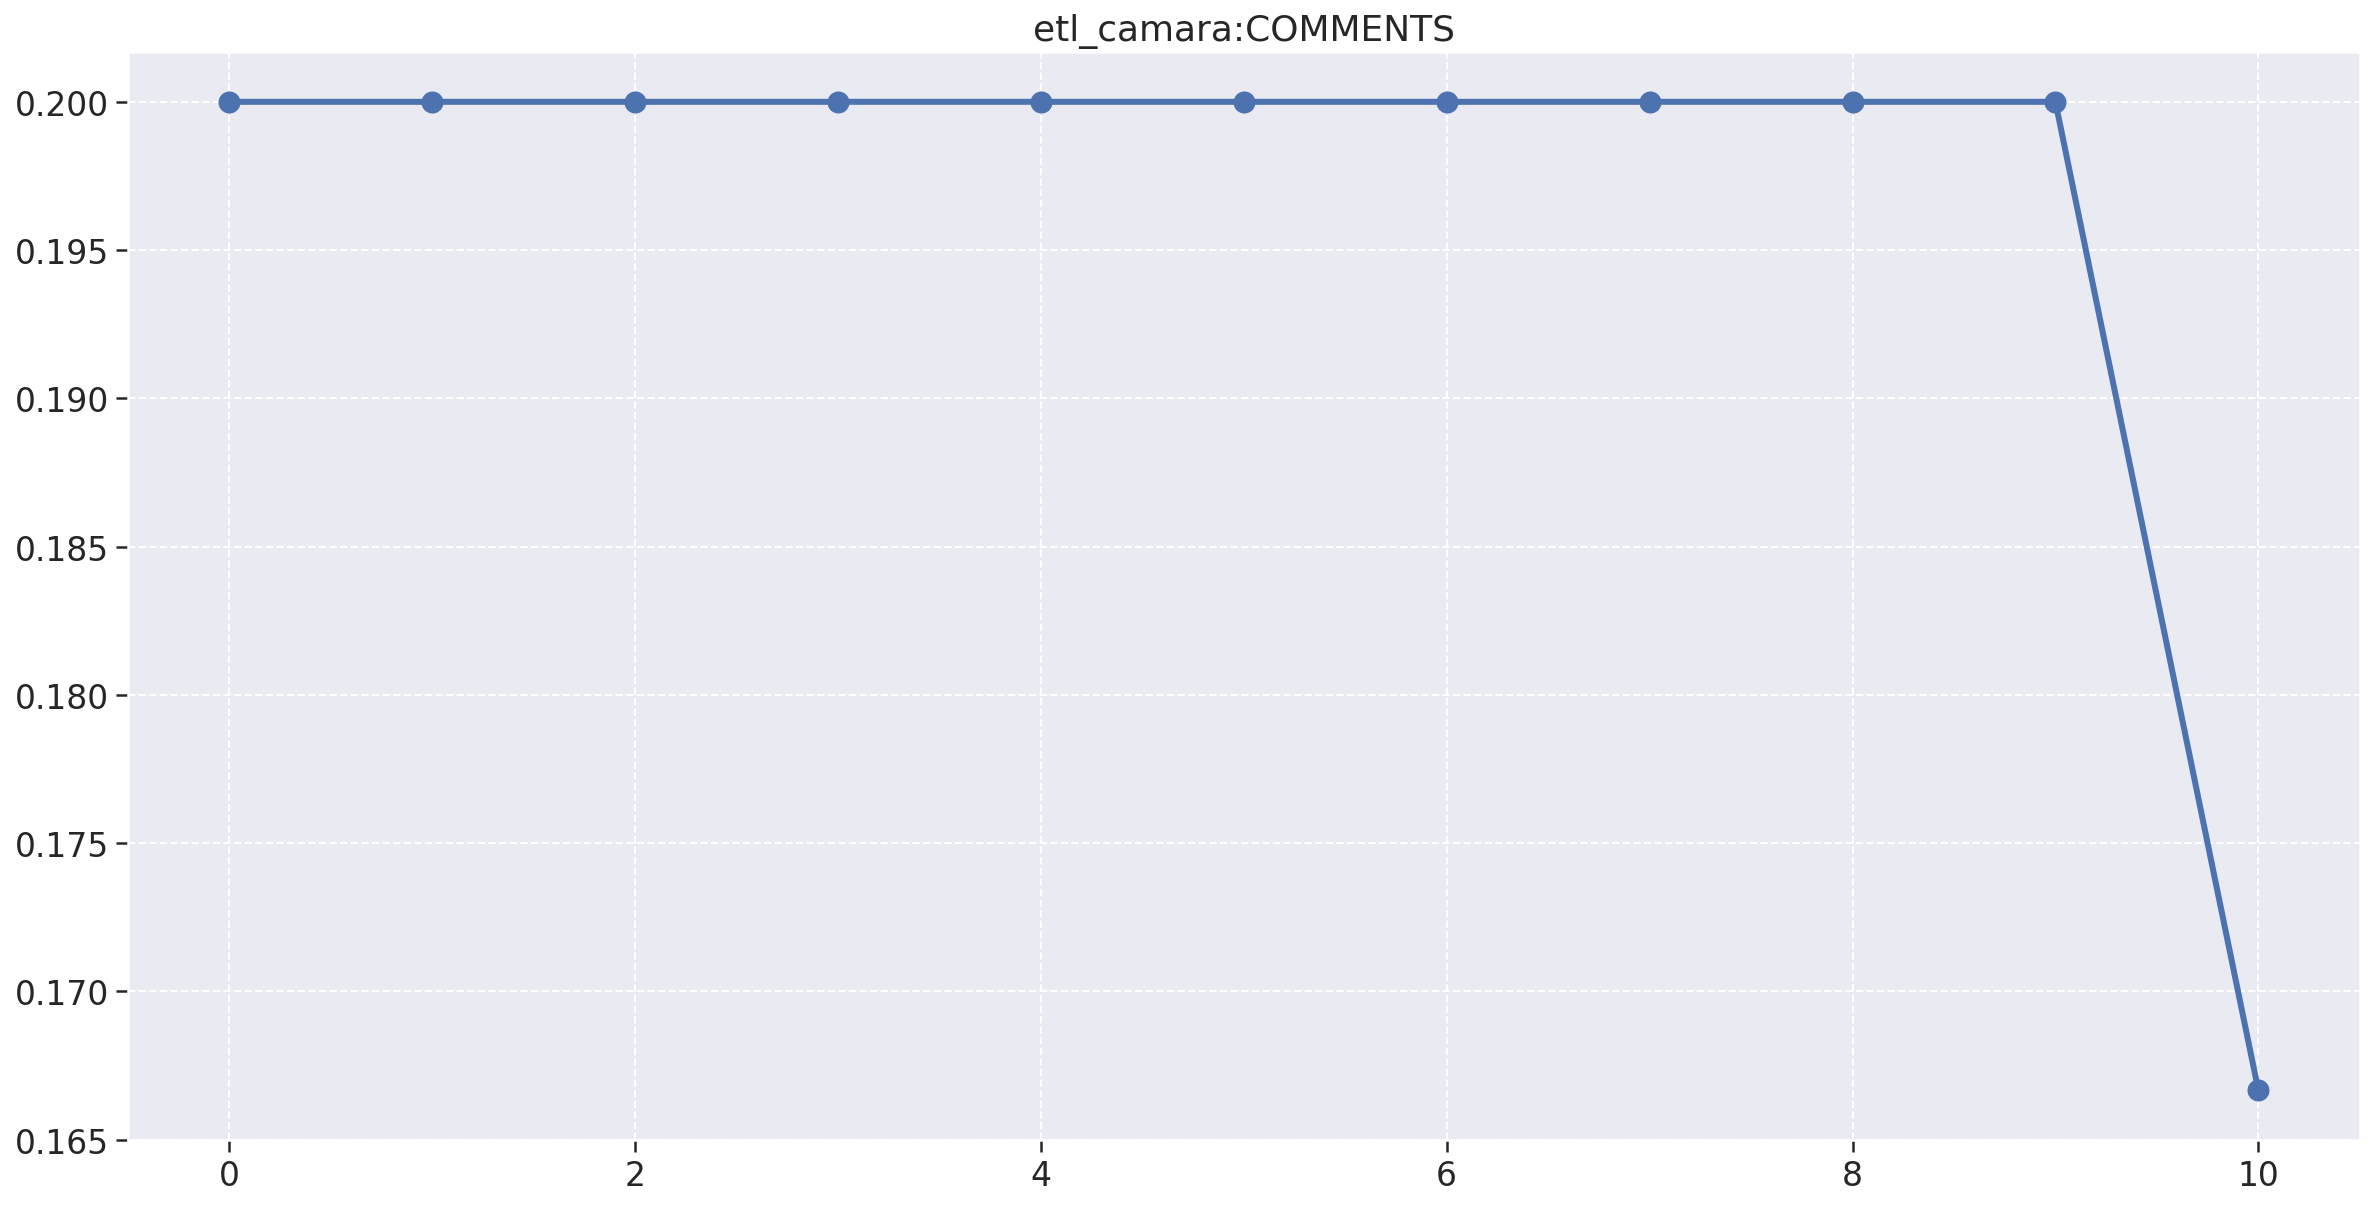

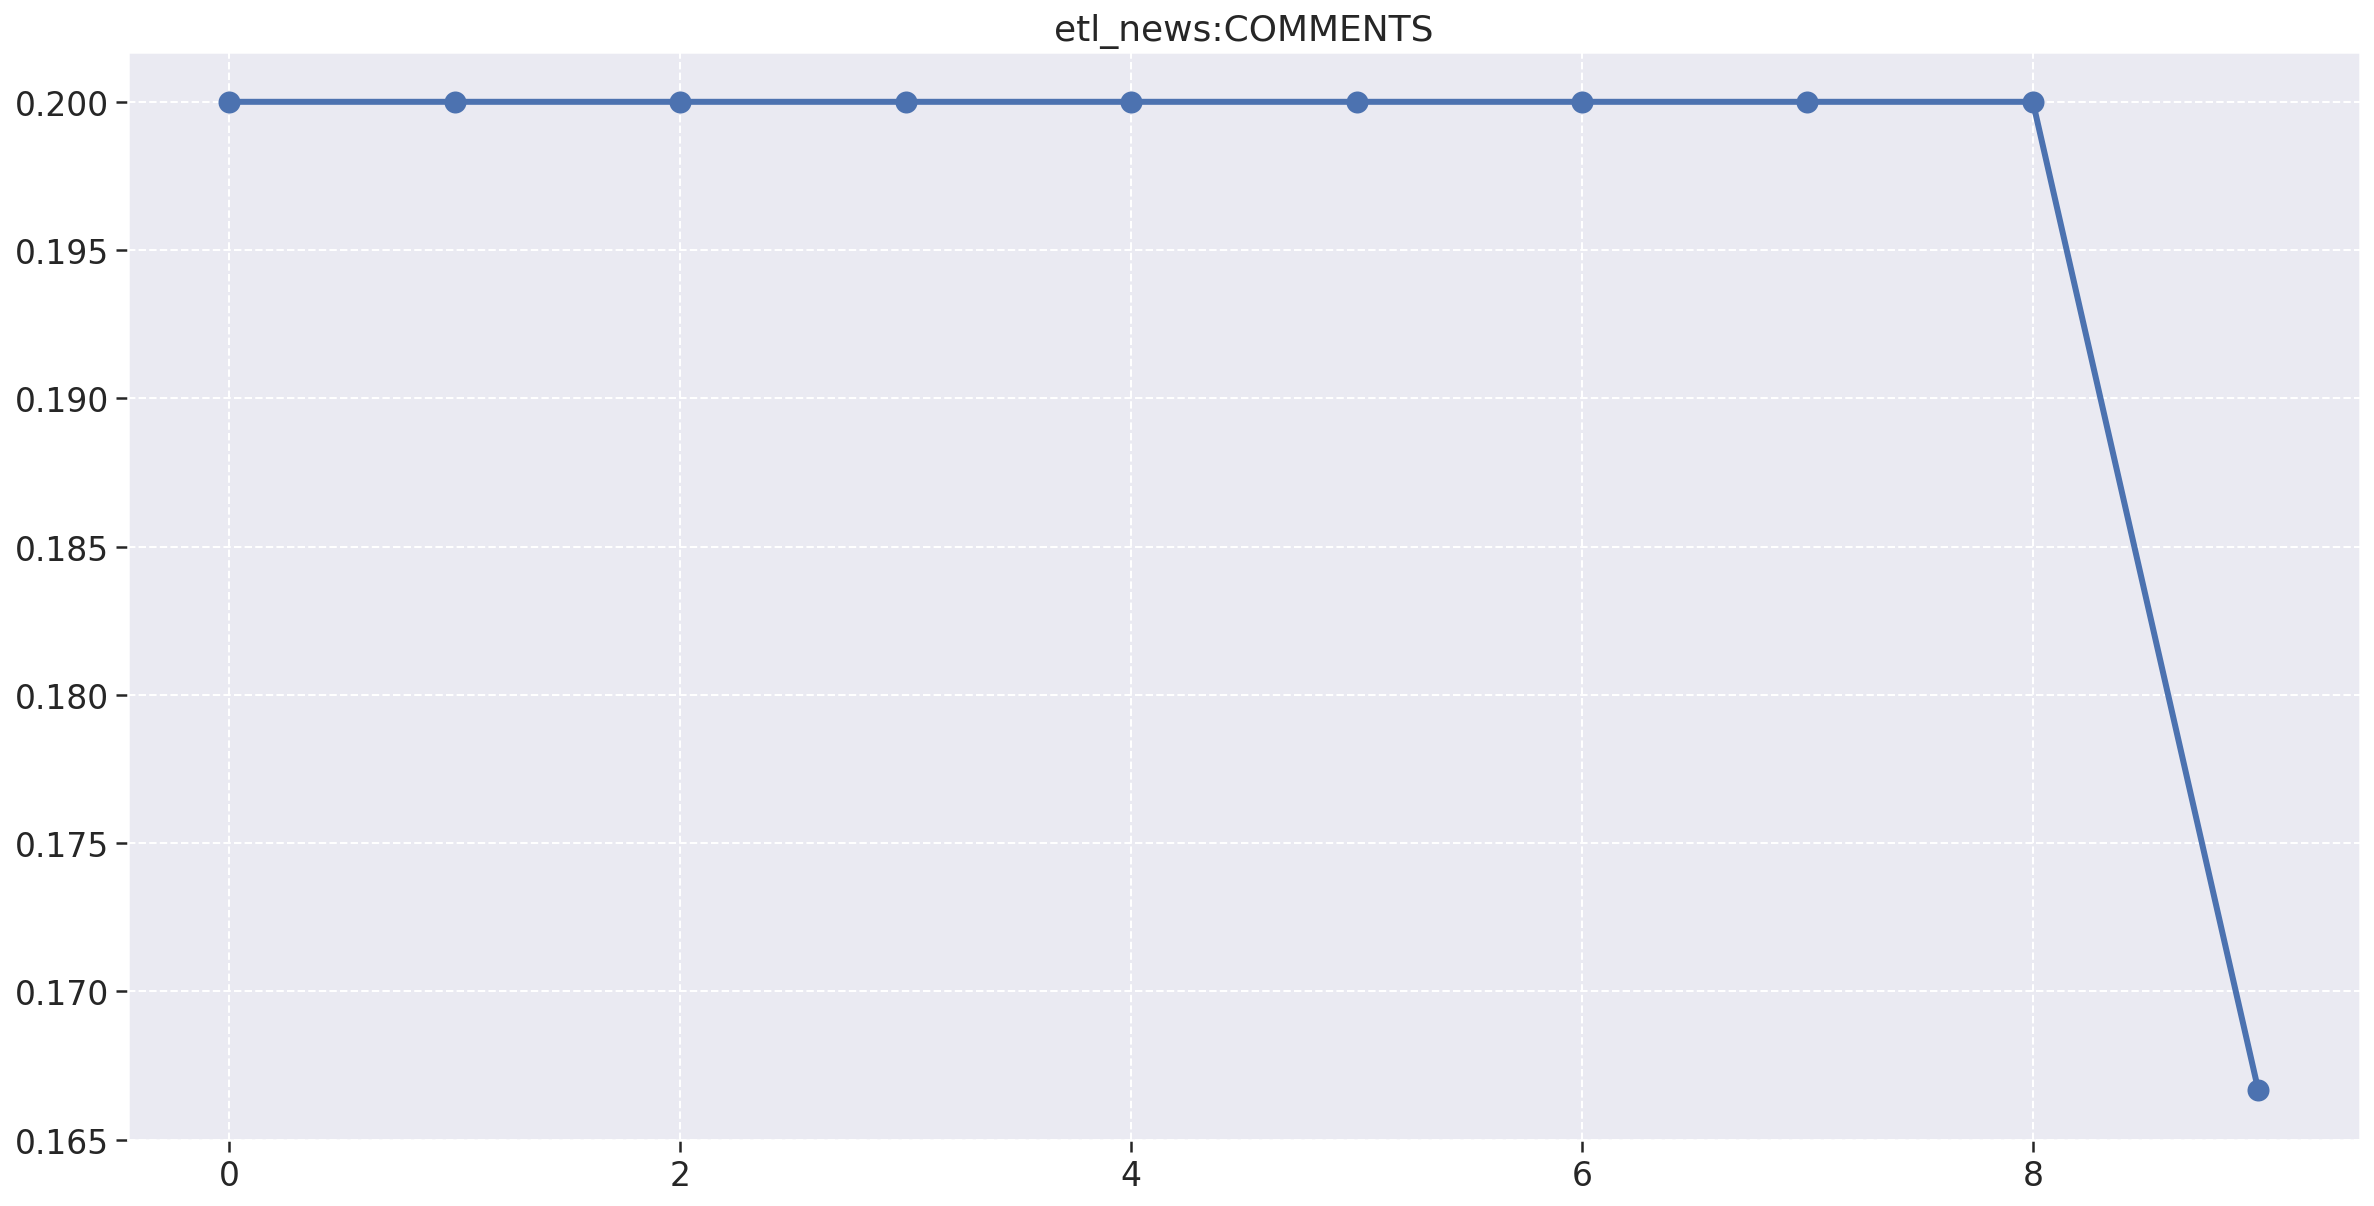

In [672]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMMENTS")
    plt.plot(metrics_df['m2'], linewidth=3, marker='o', markersize=10)

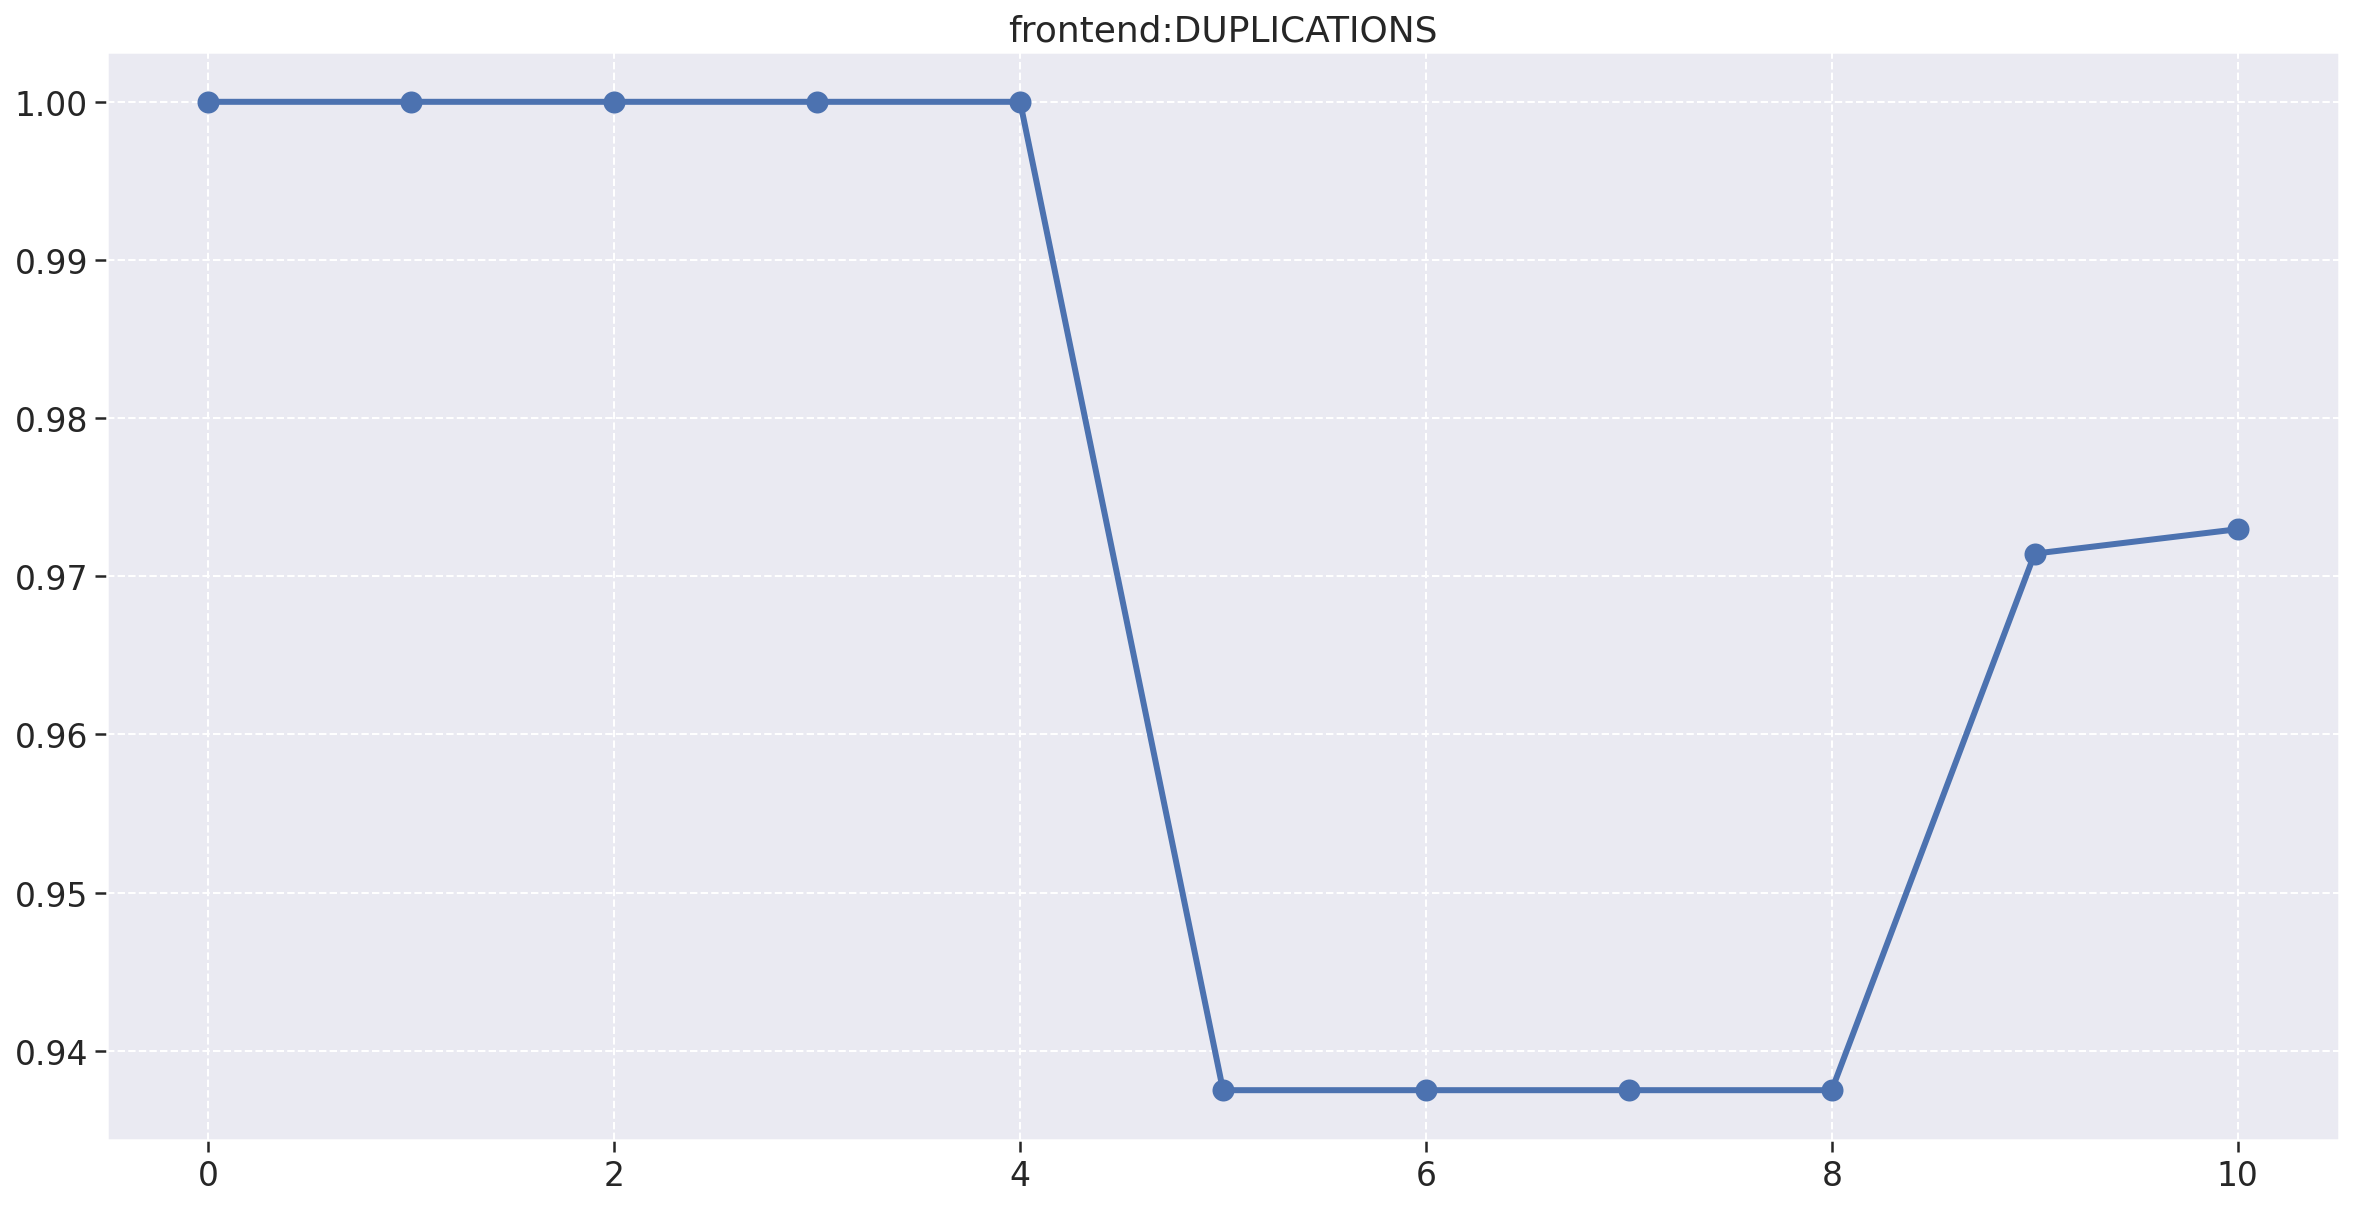

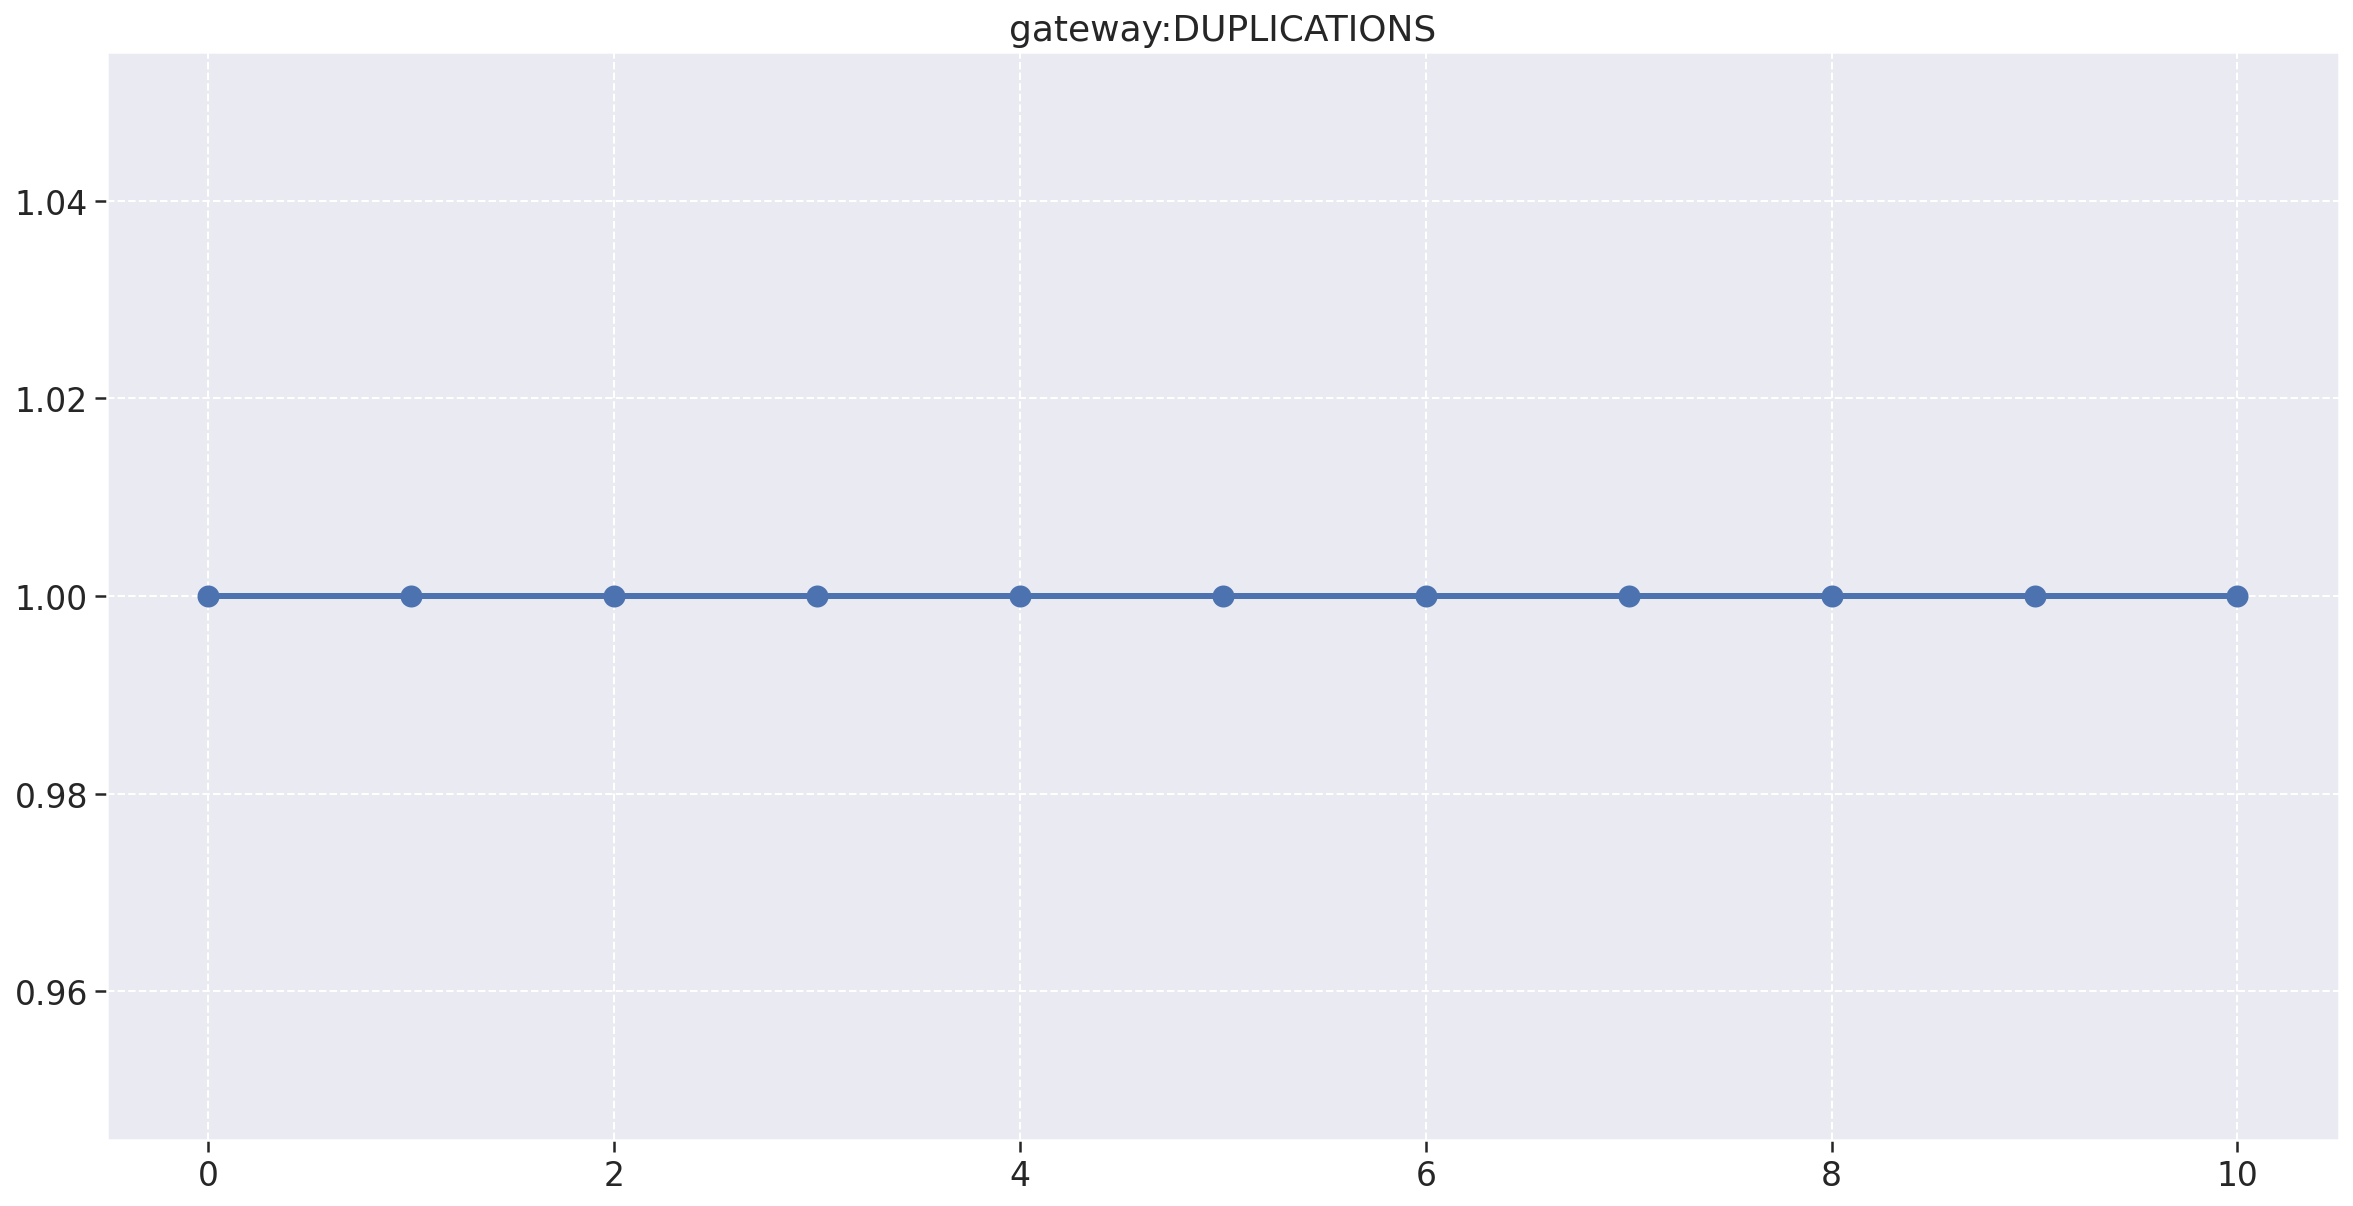

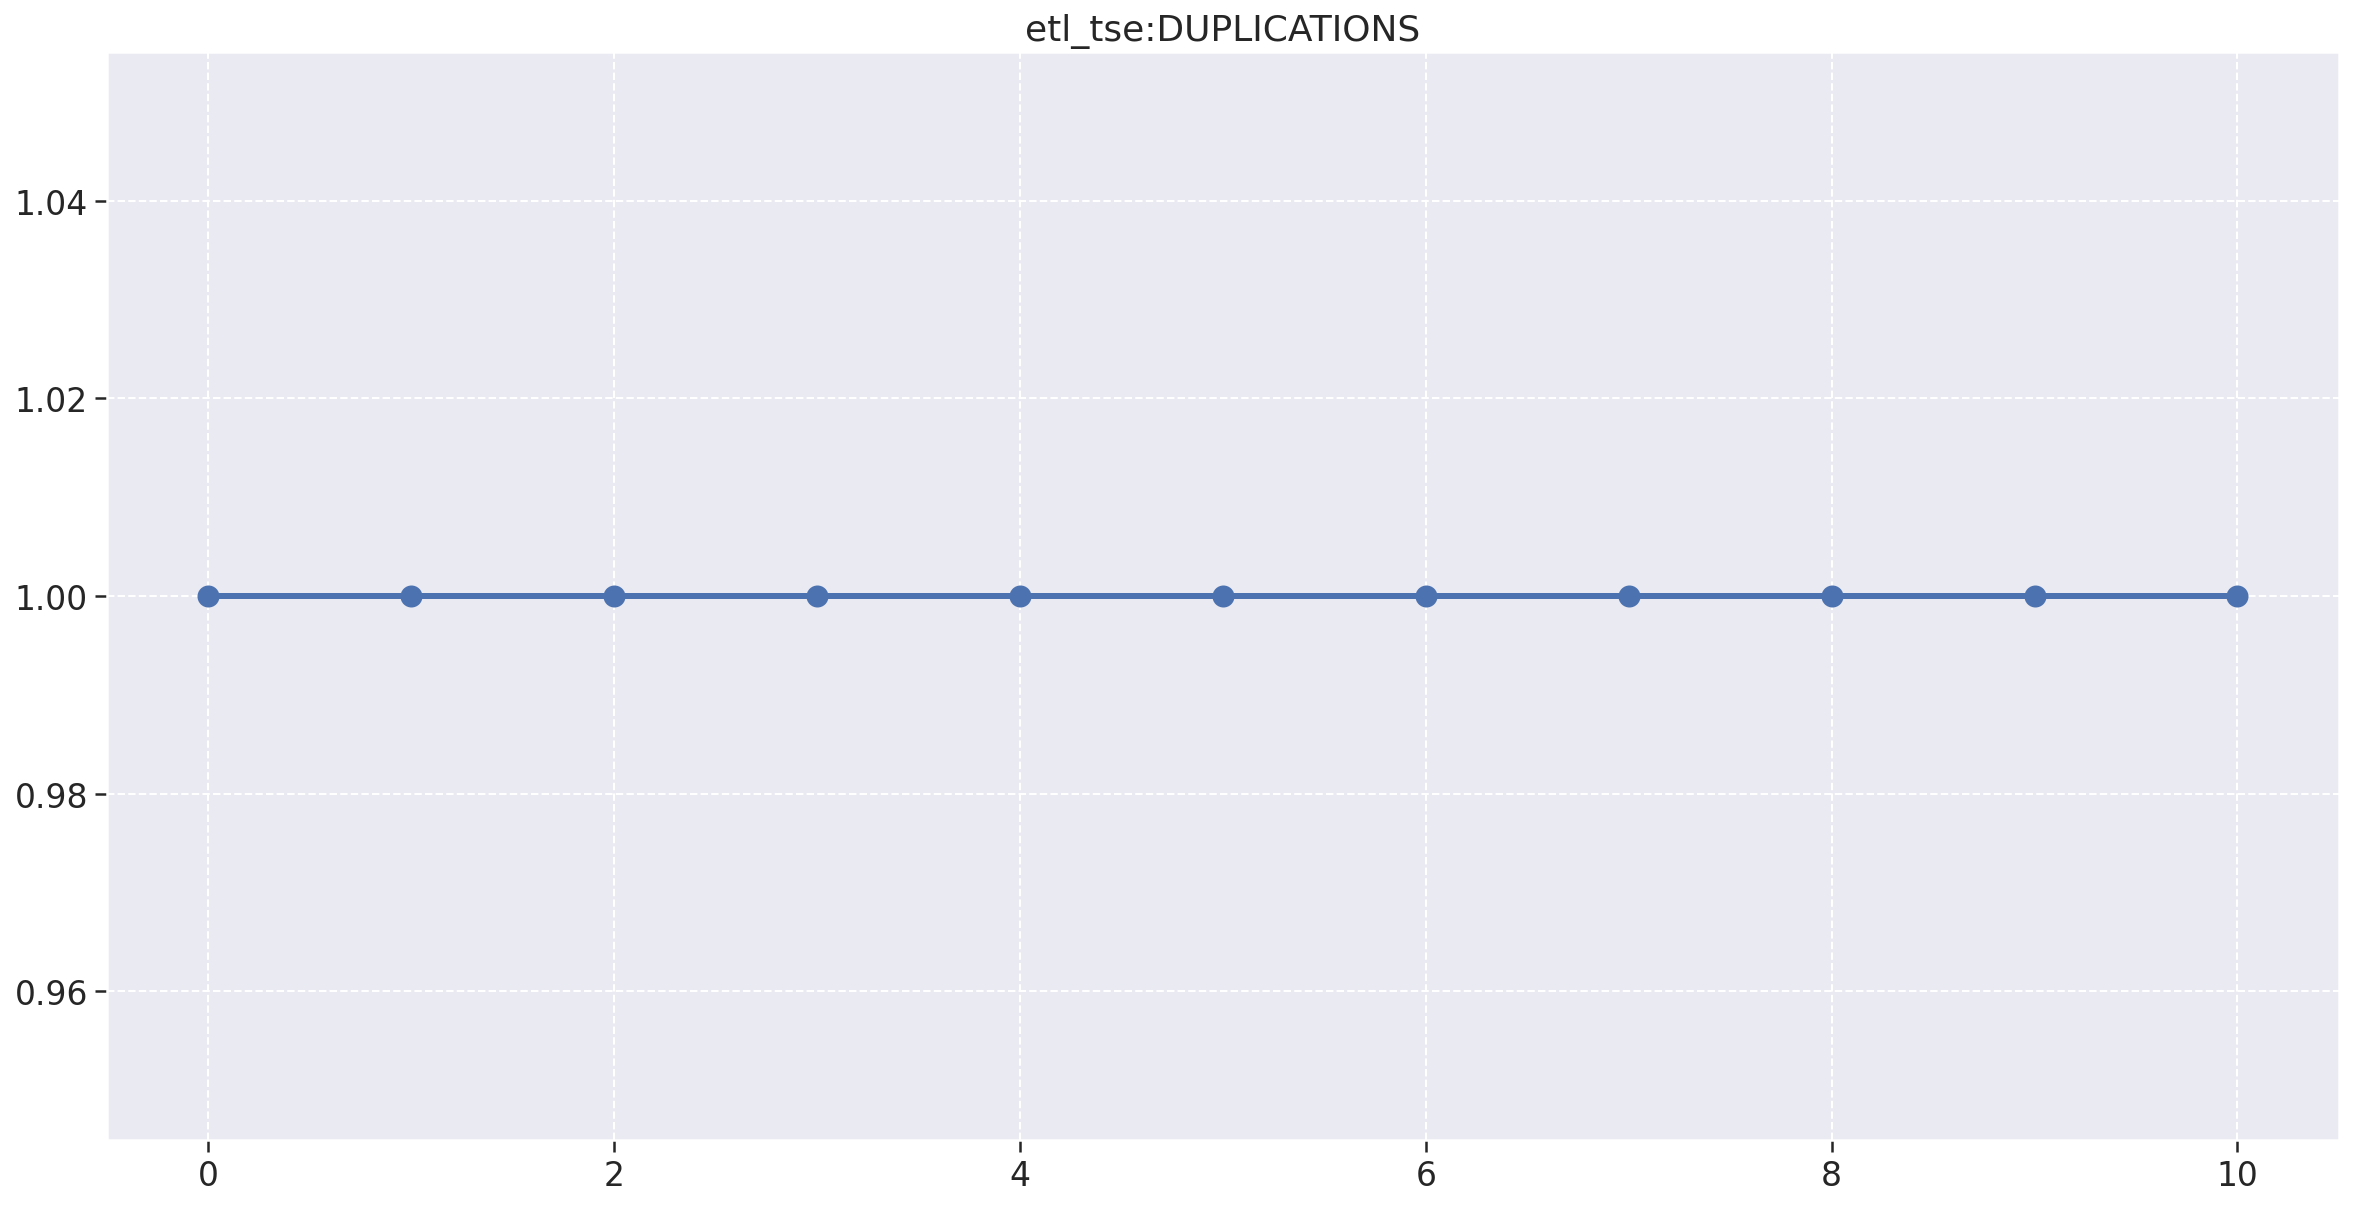

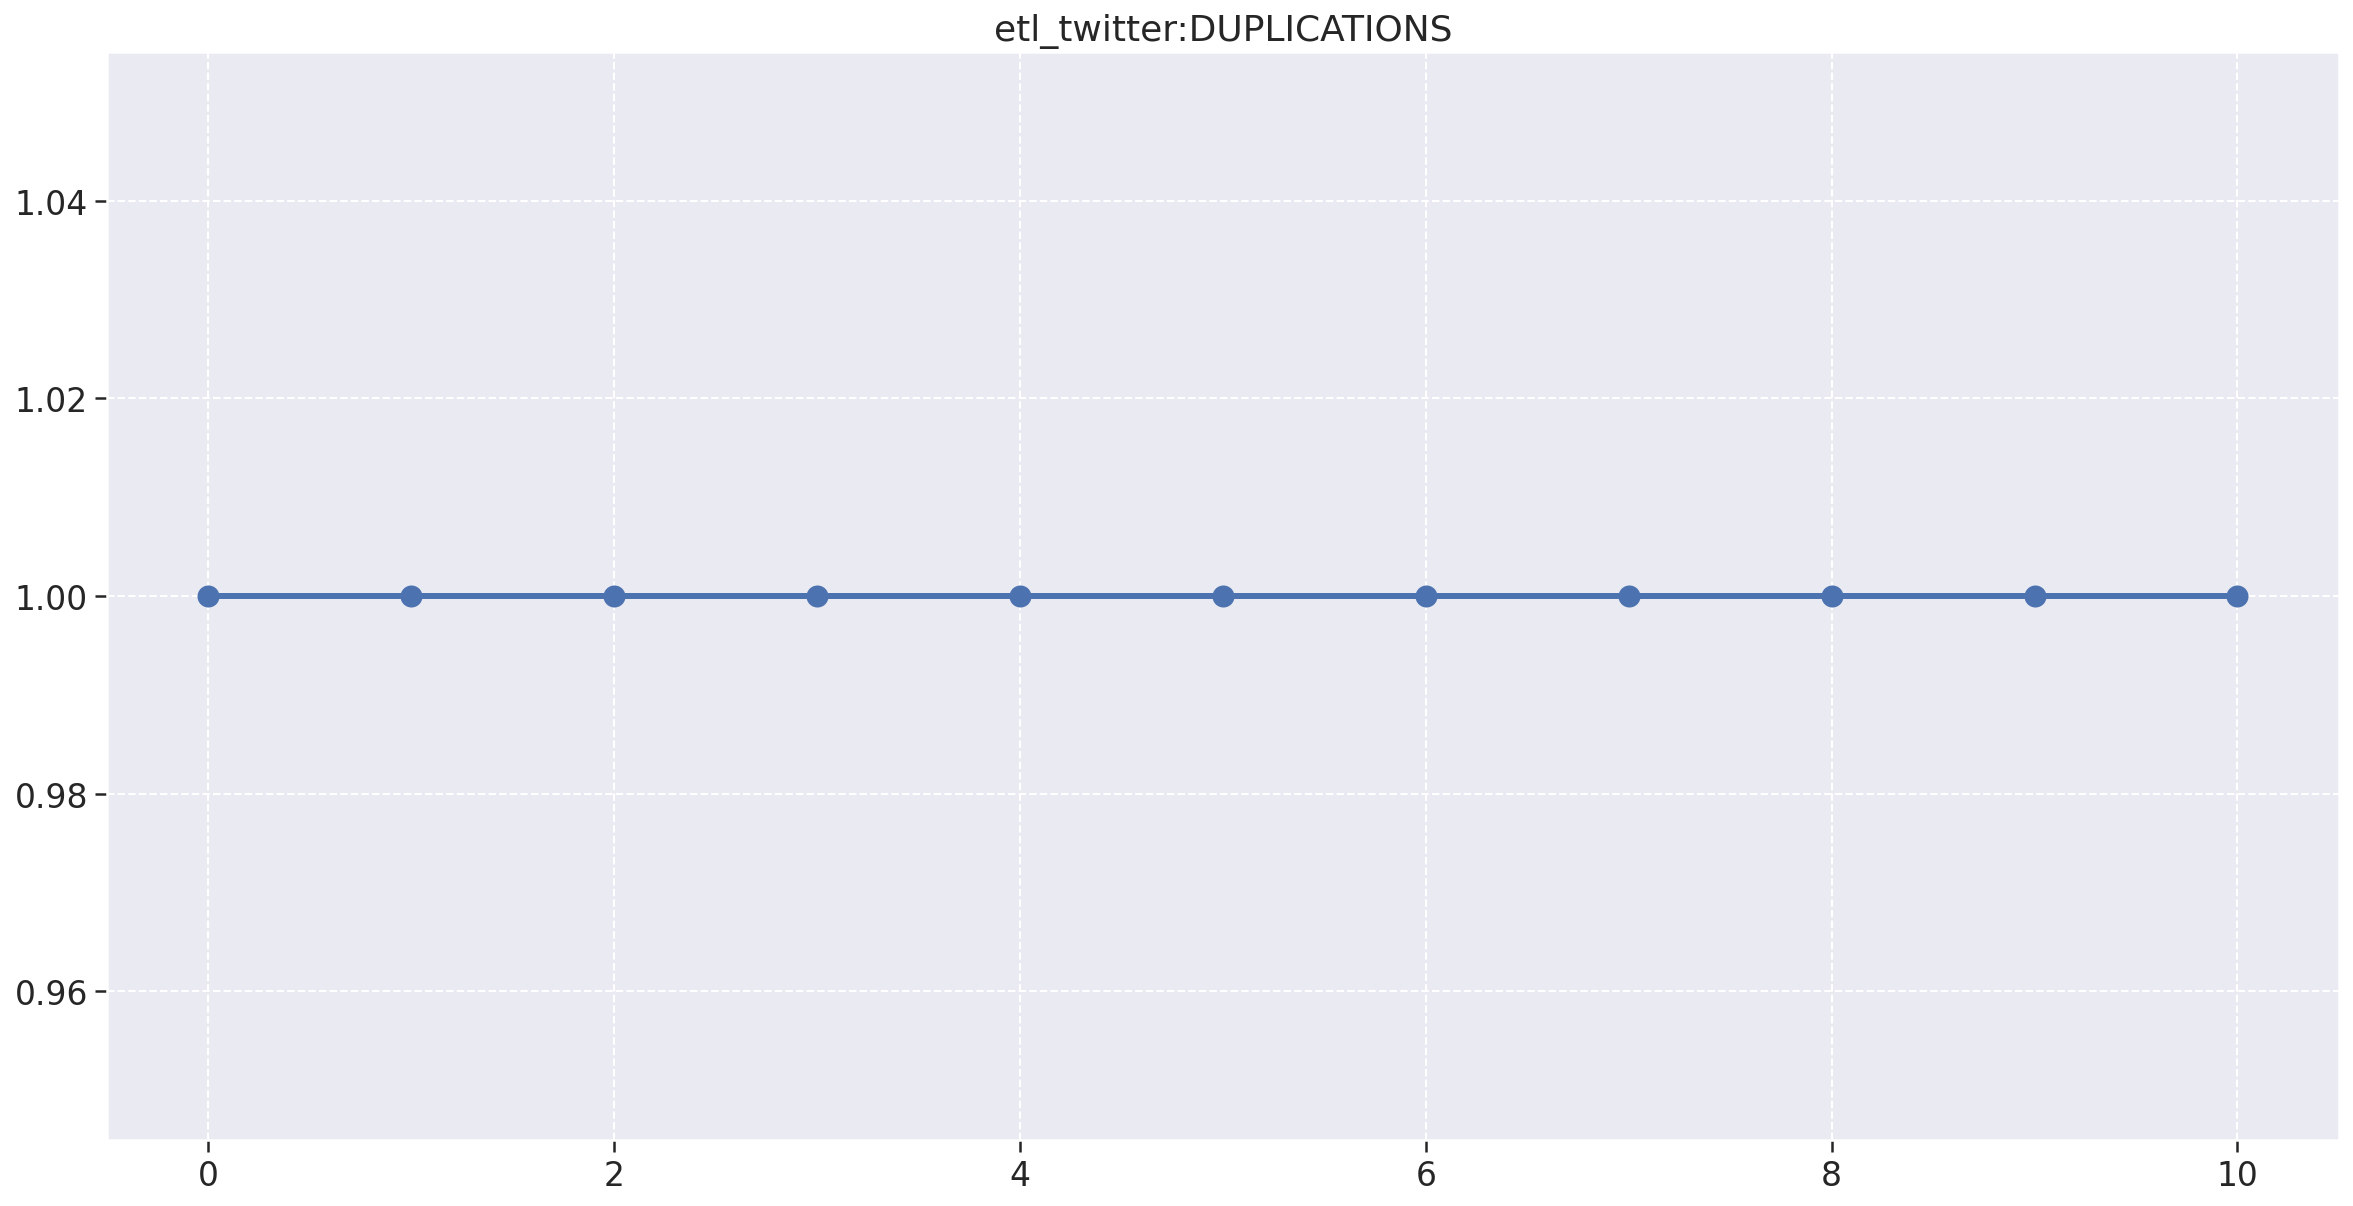

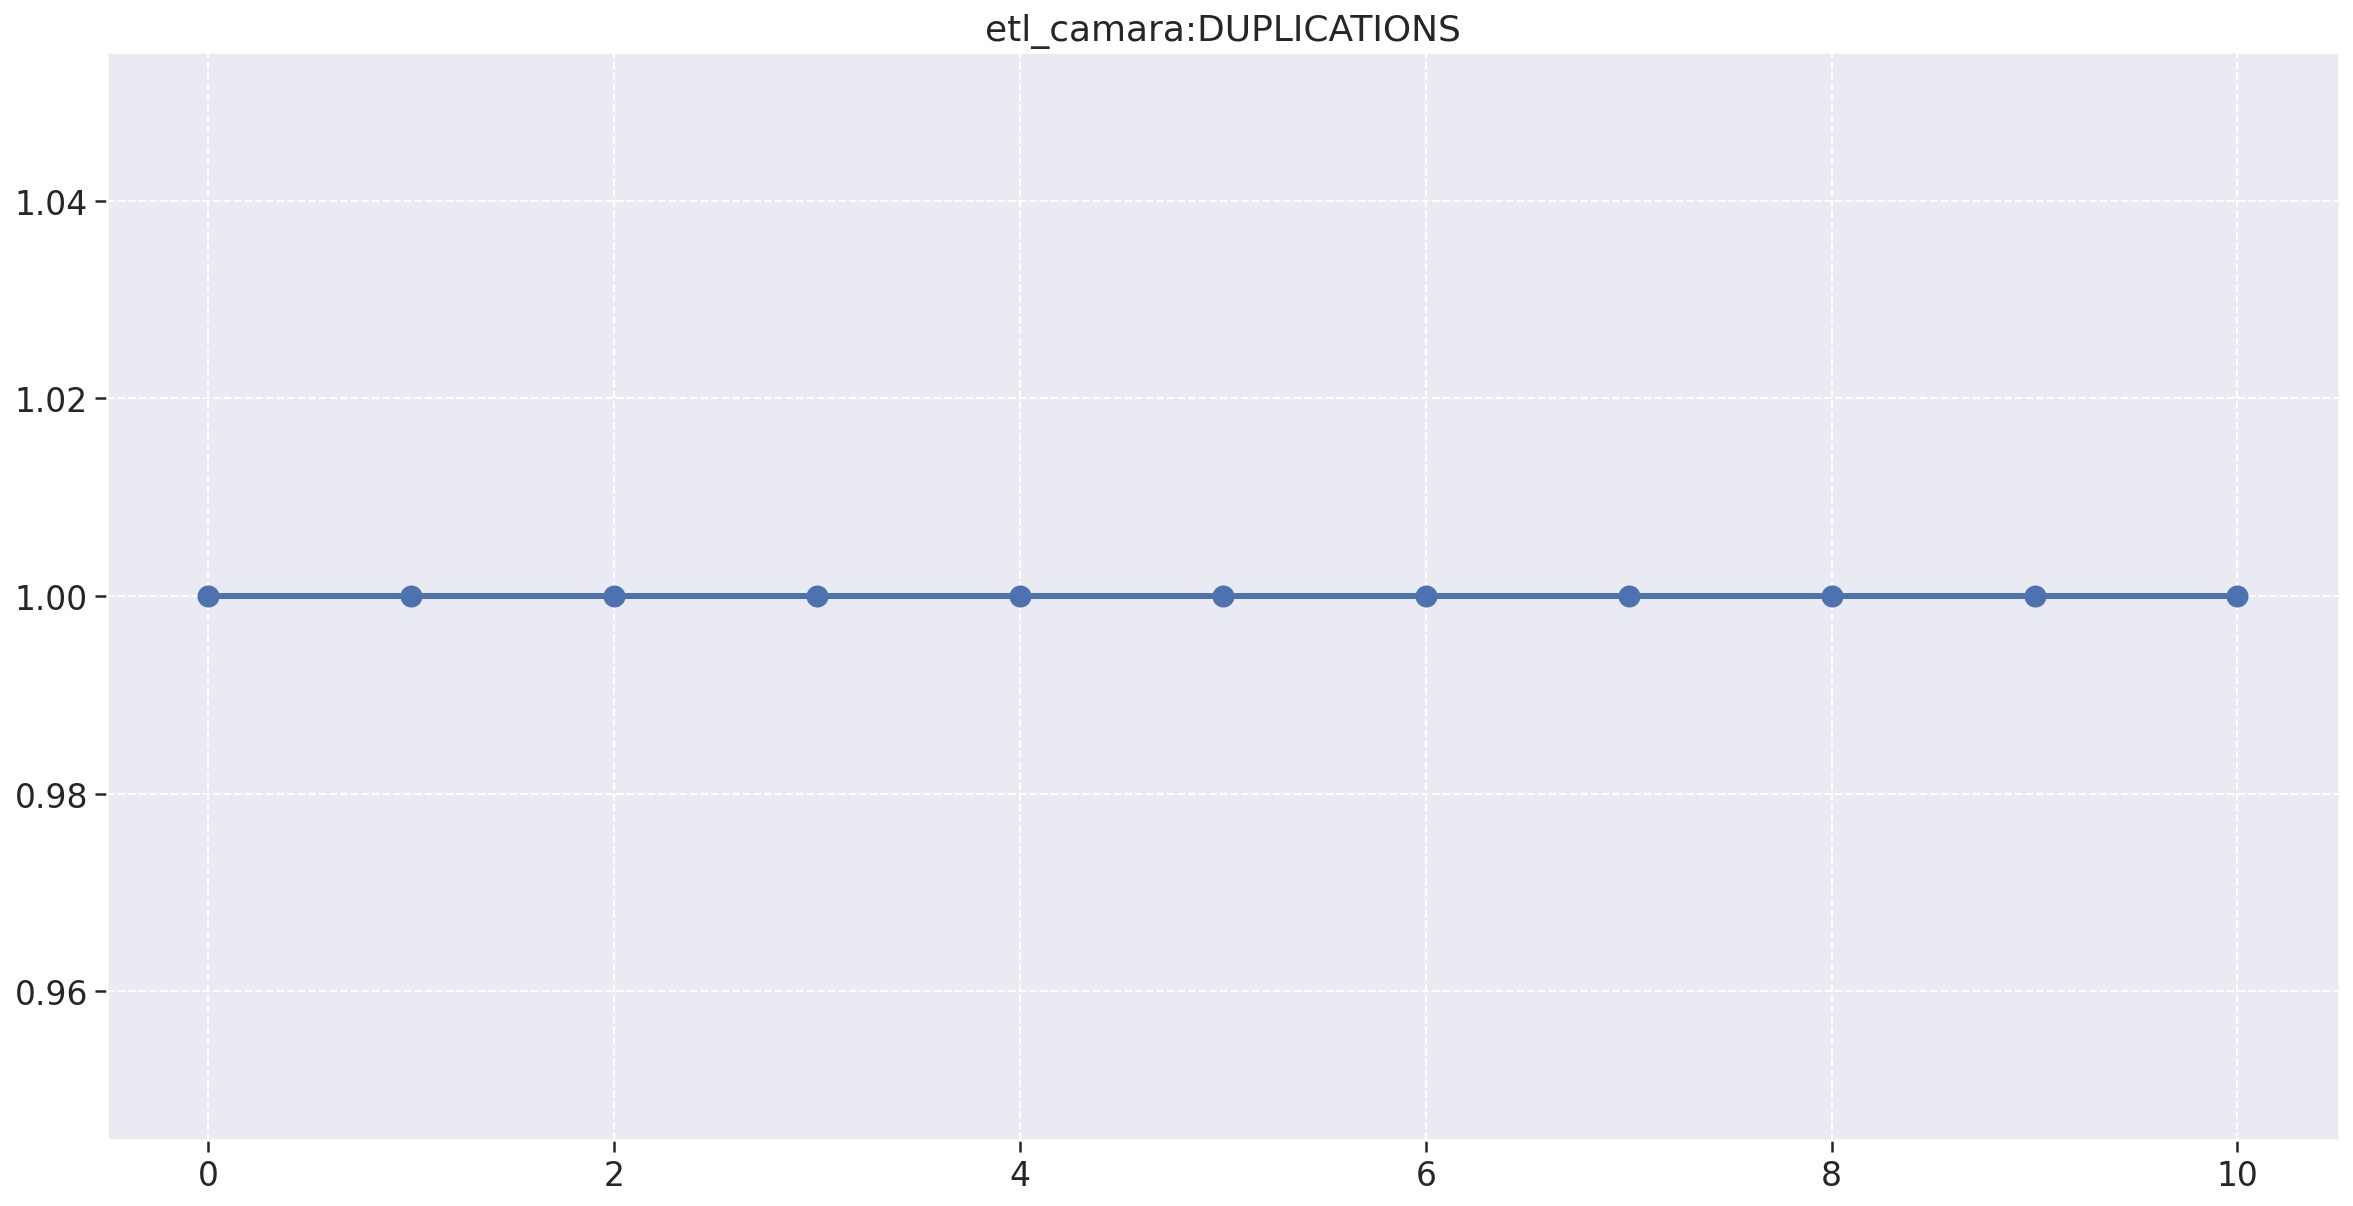

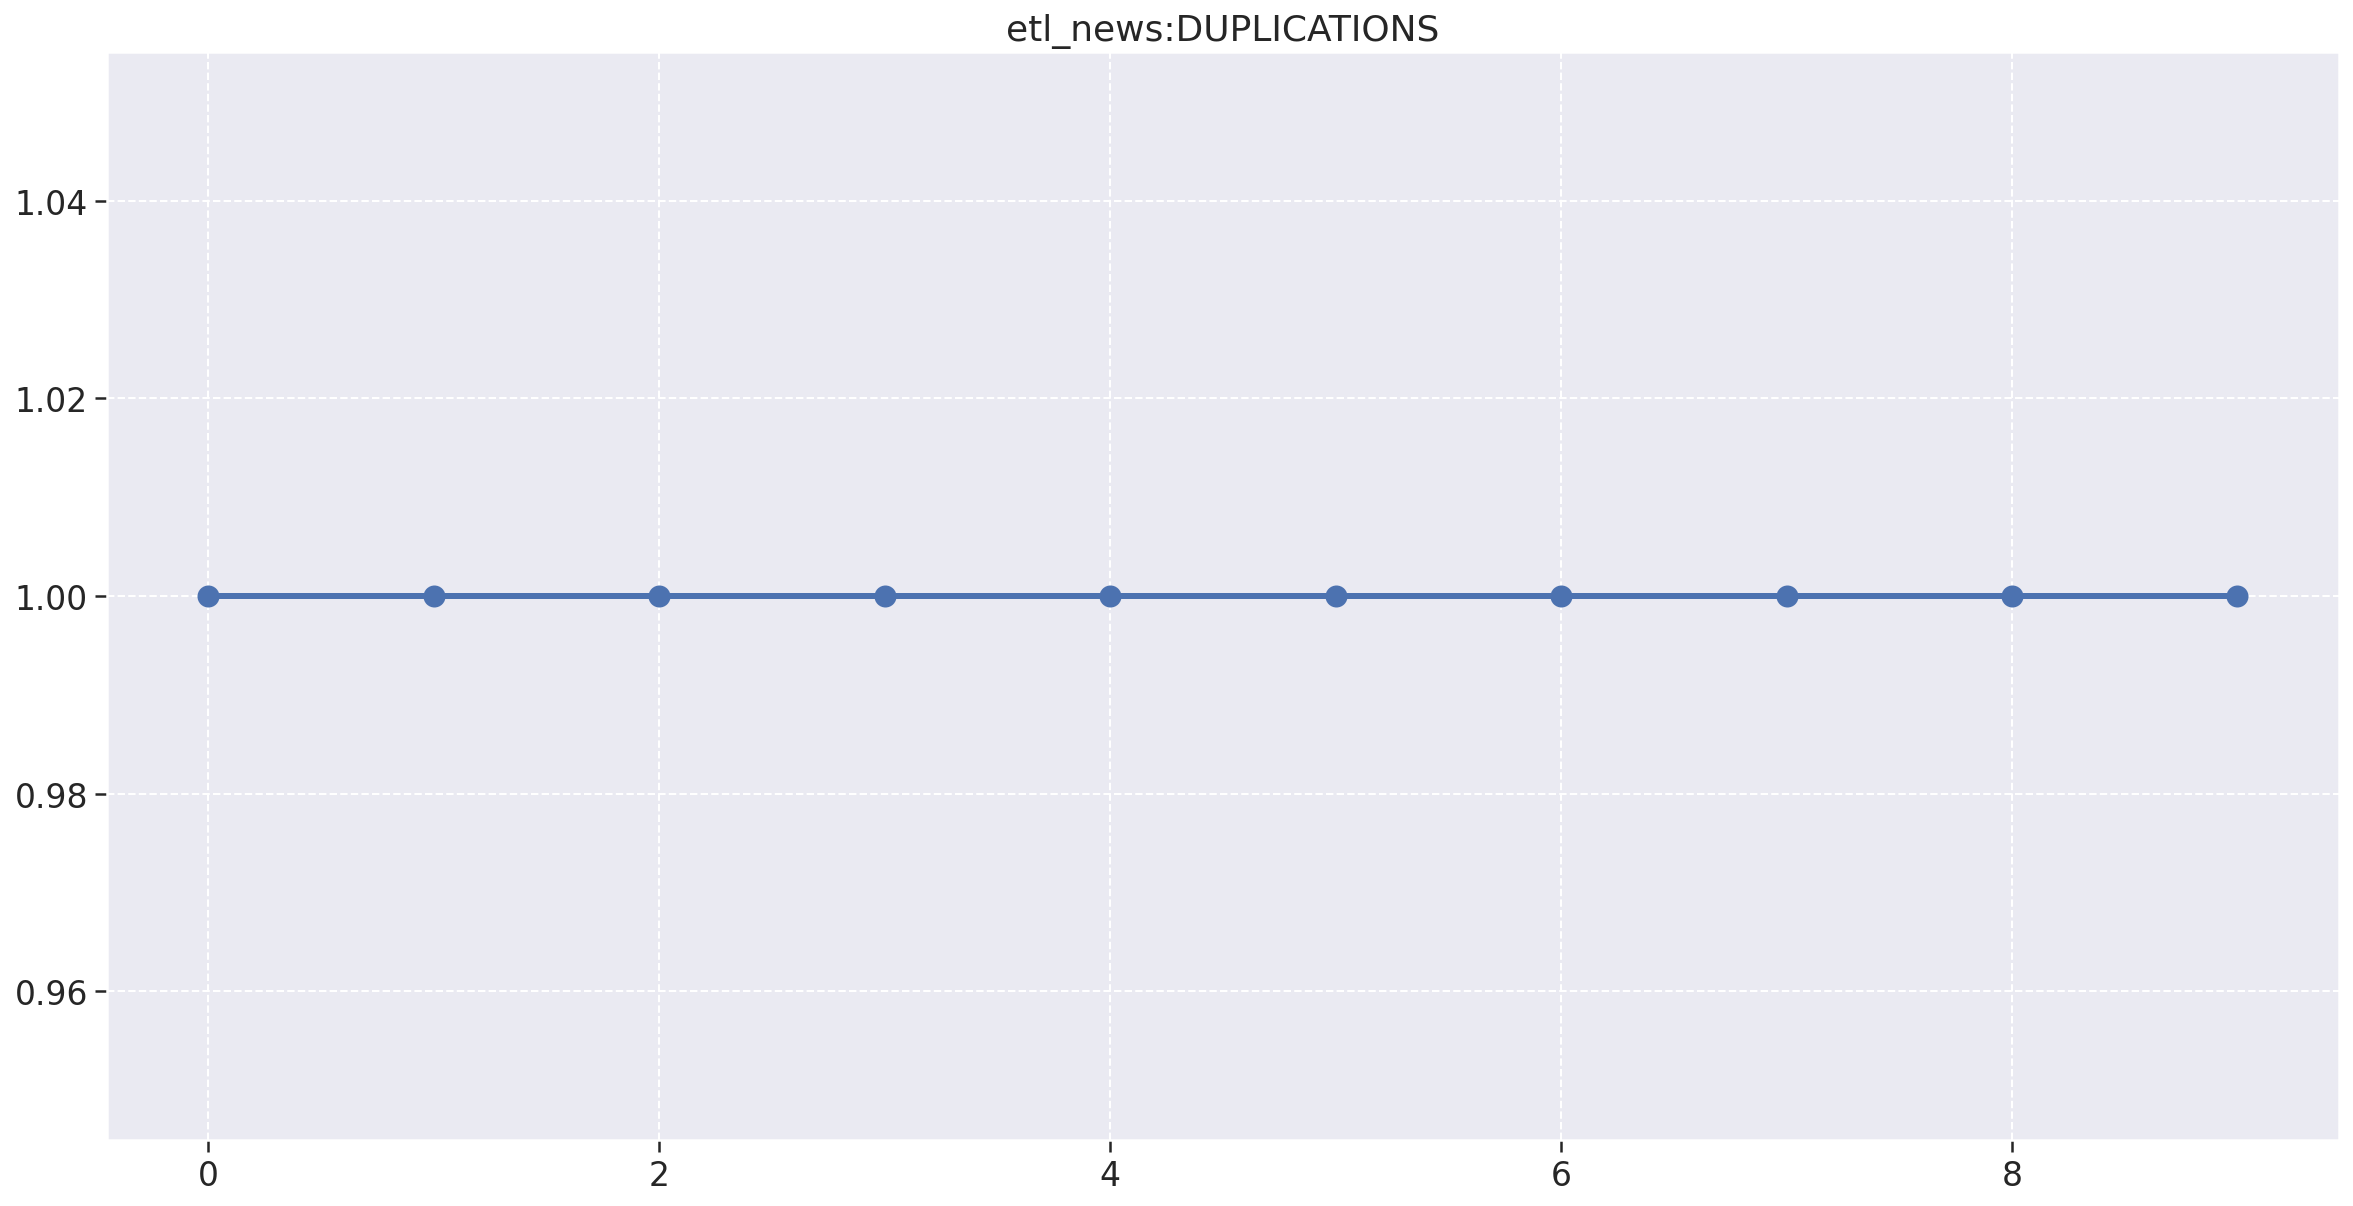

In [673]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:DUPLICATIONS")
    plt.plot(metrics_df['m3'], linewidth=3, marker='o', markersize=10)

### Sub characteristic aggregation


In [674]:
psc1 = 1
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

for repository, metrics_df in repository_metrics.items(): 
    metrics_df['asc1'] = ((metrics_df['m1']*pm1)+(metrics_df['m2']*pm2)+(metrics_df['m3']*pm3))*psc1


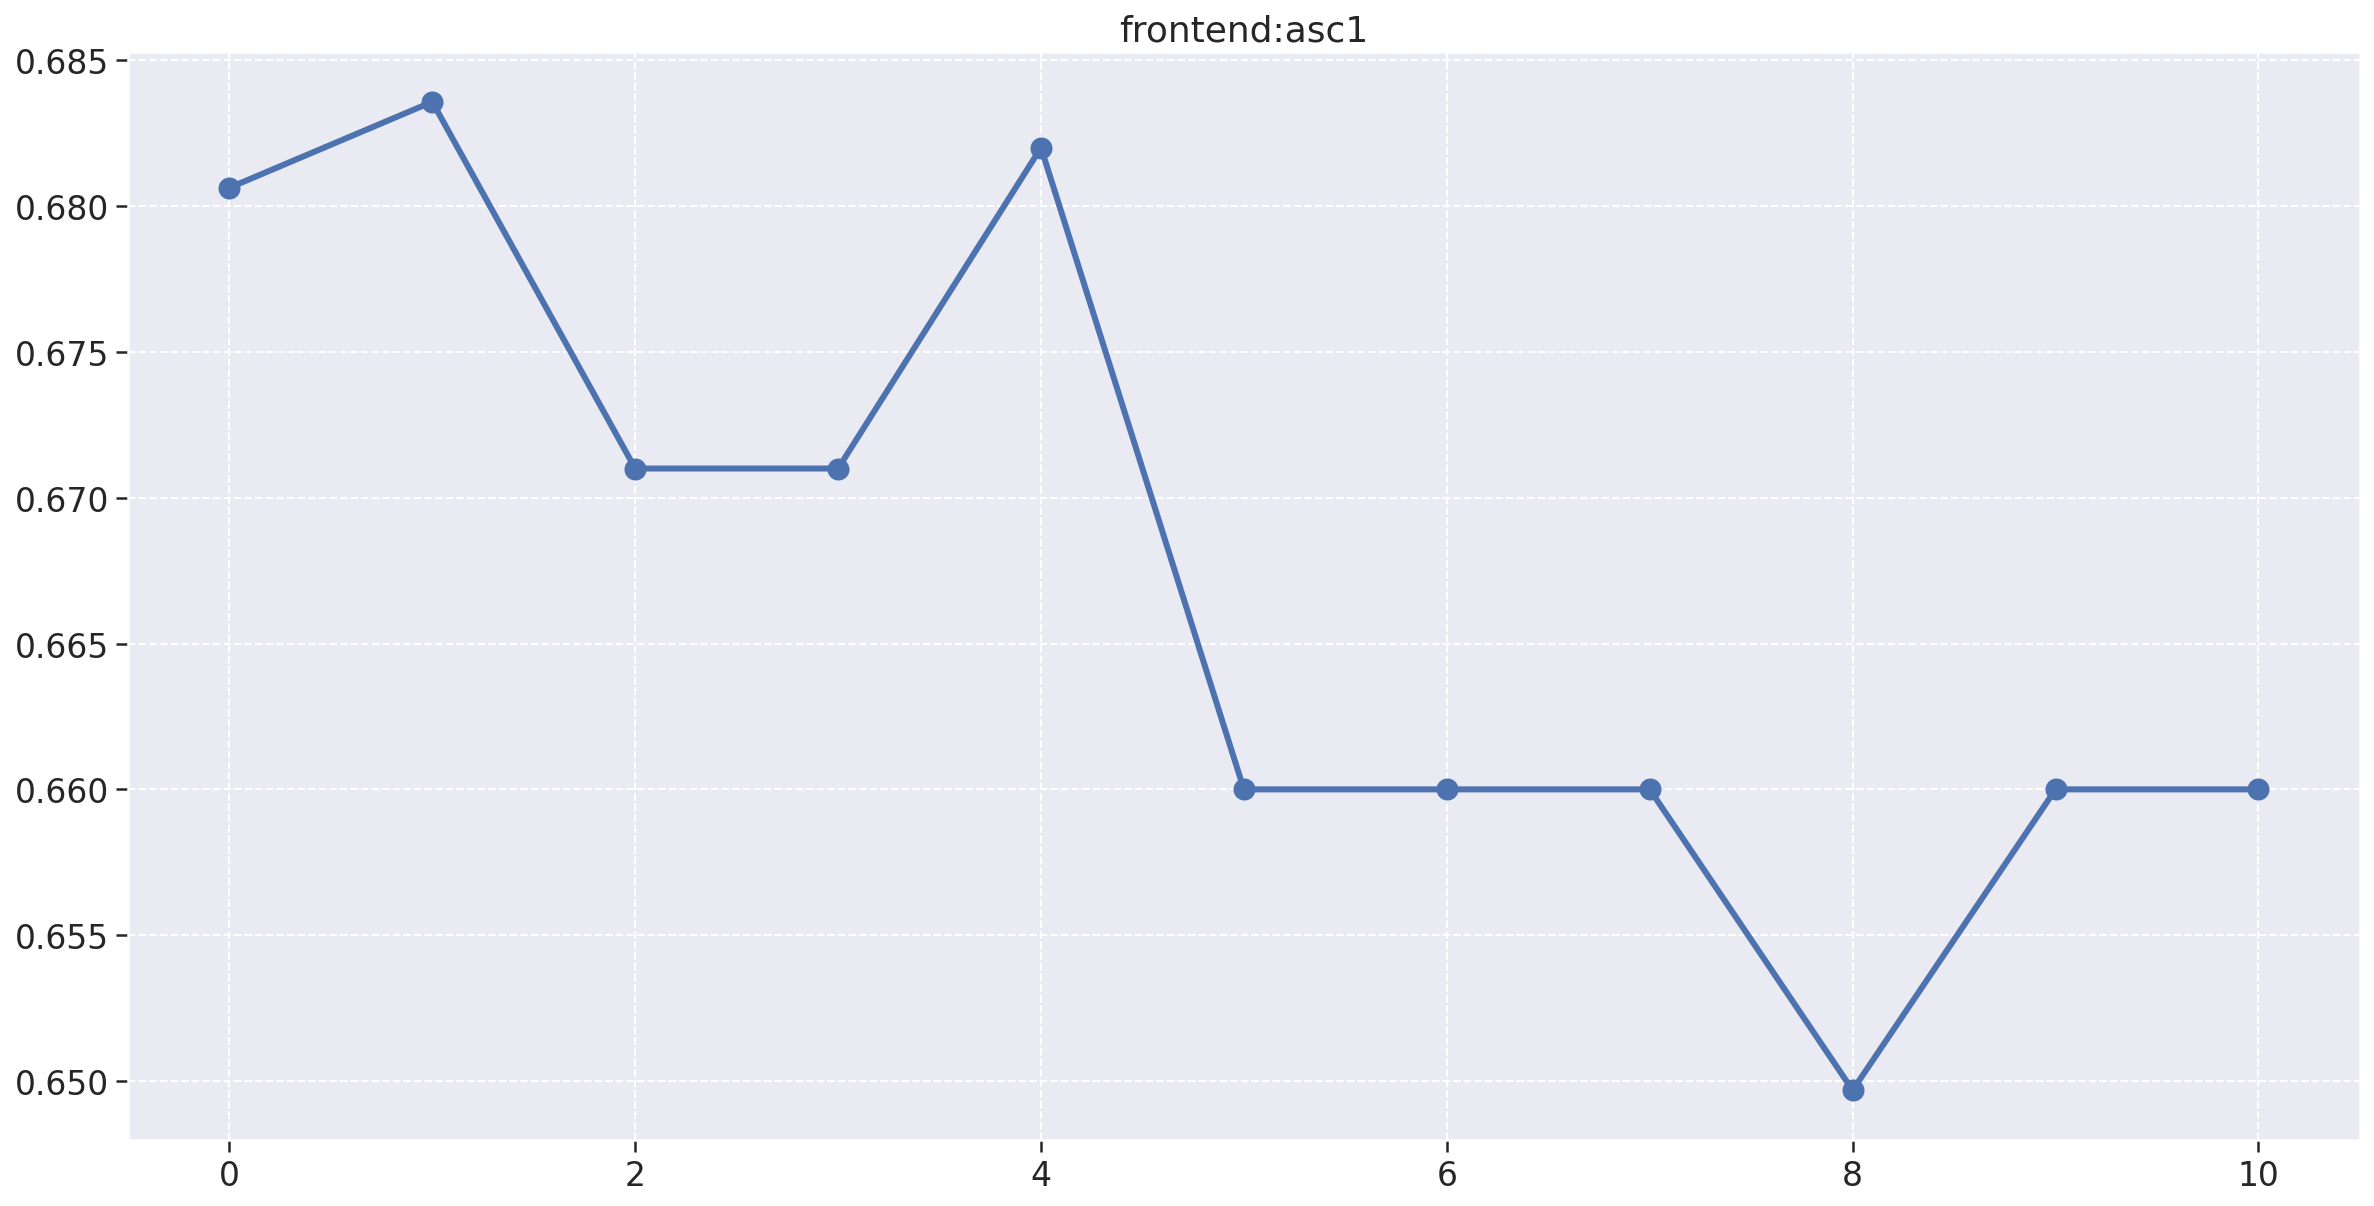

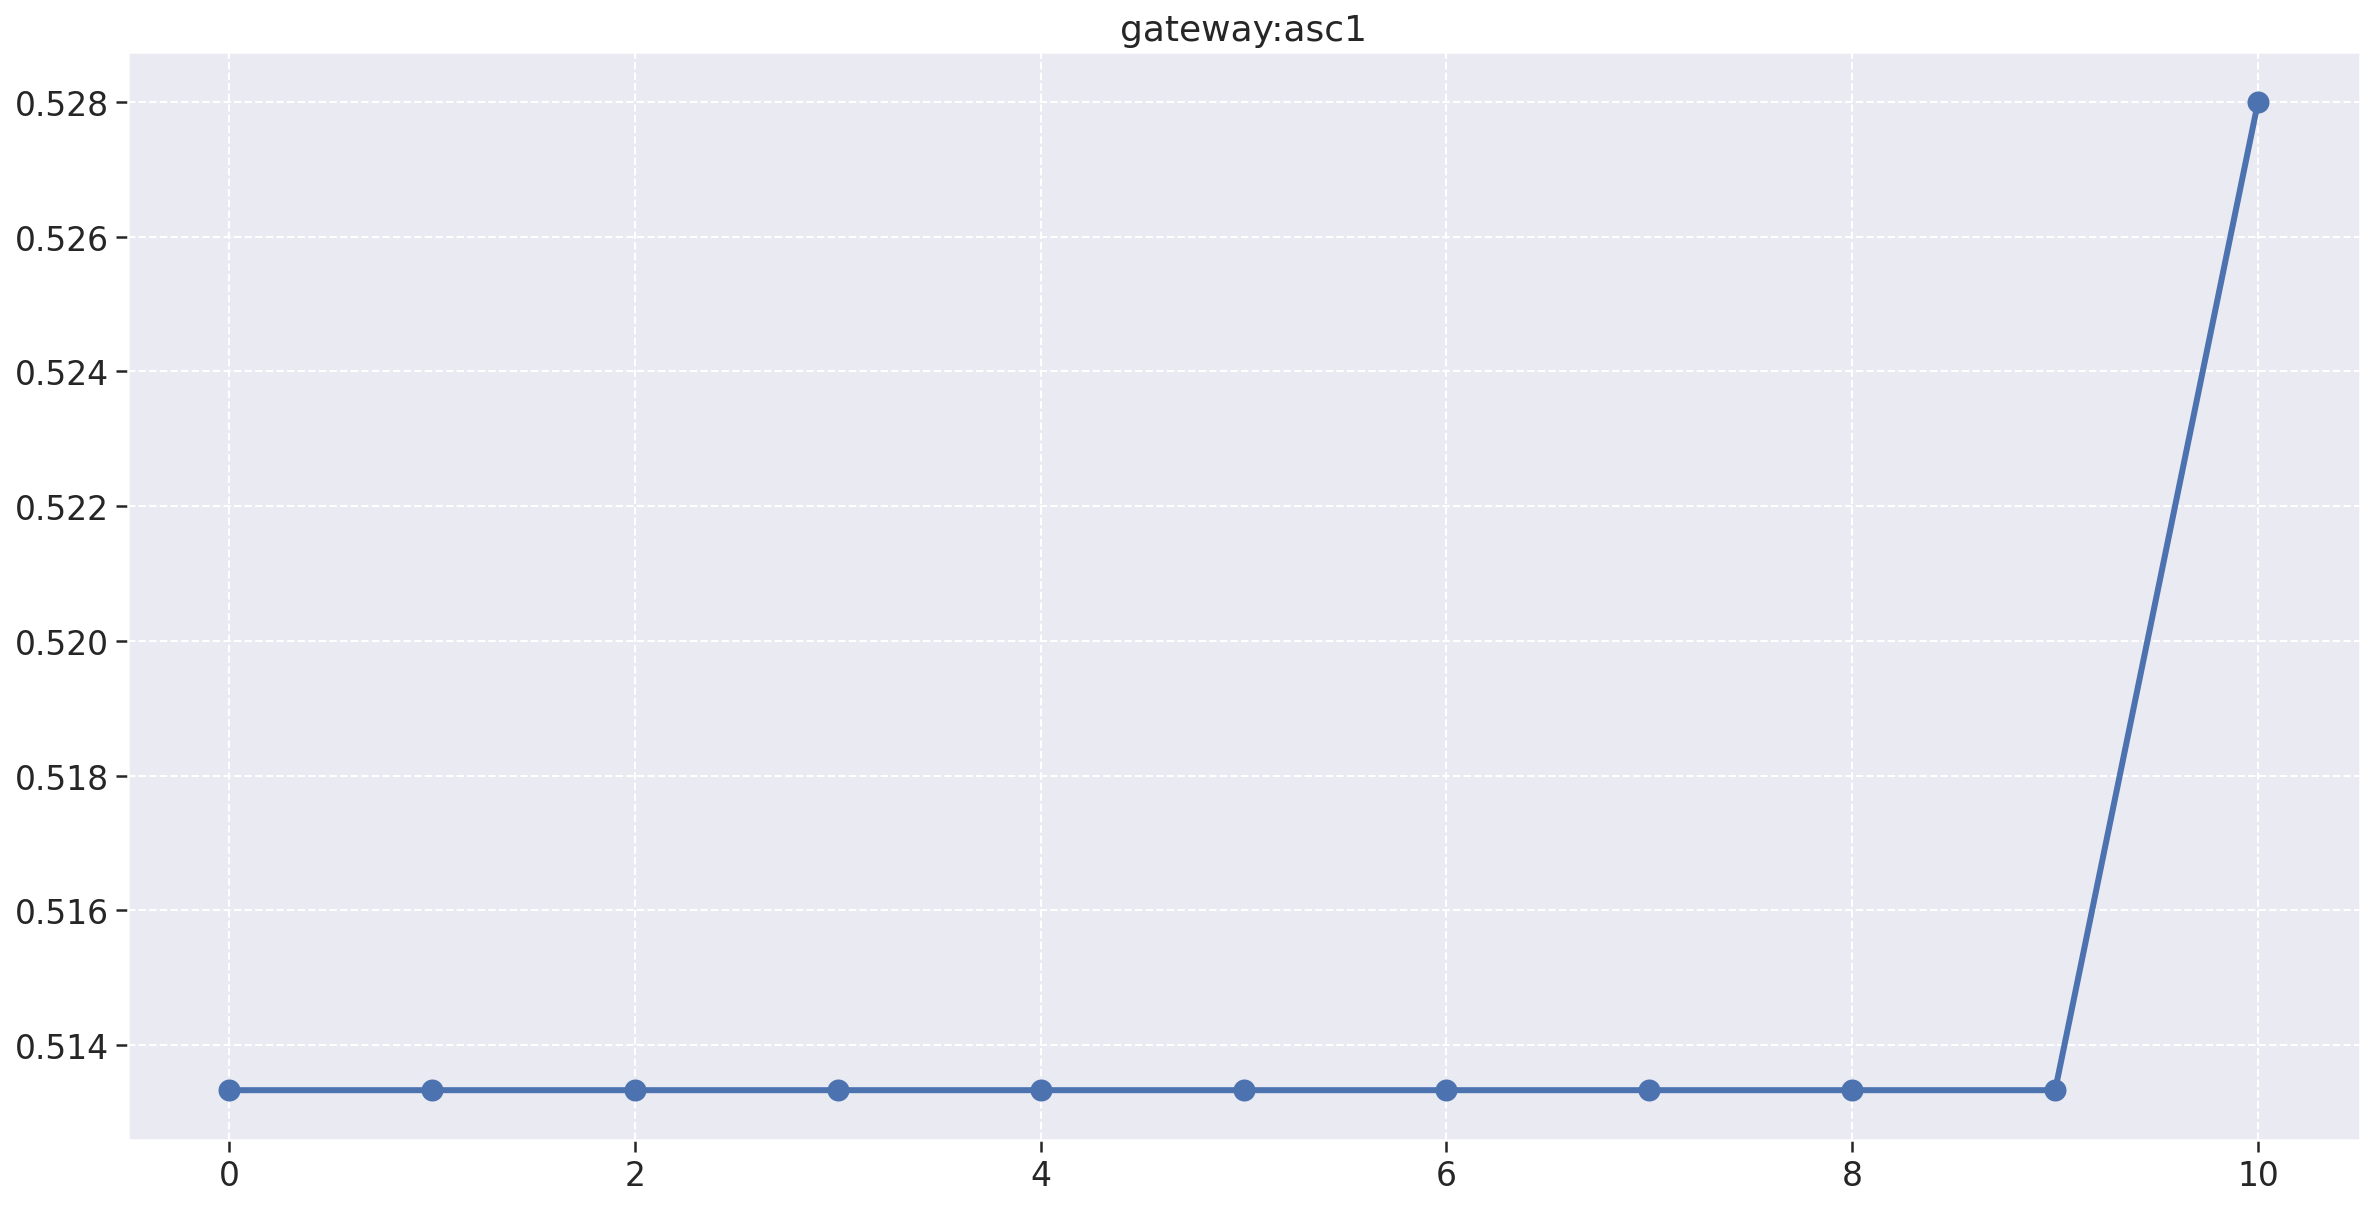

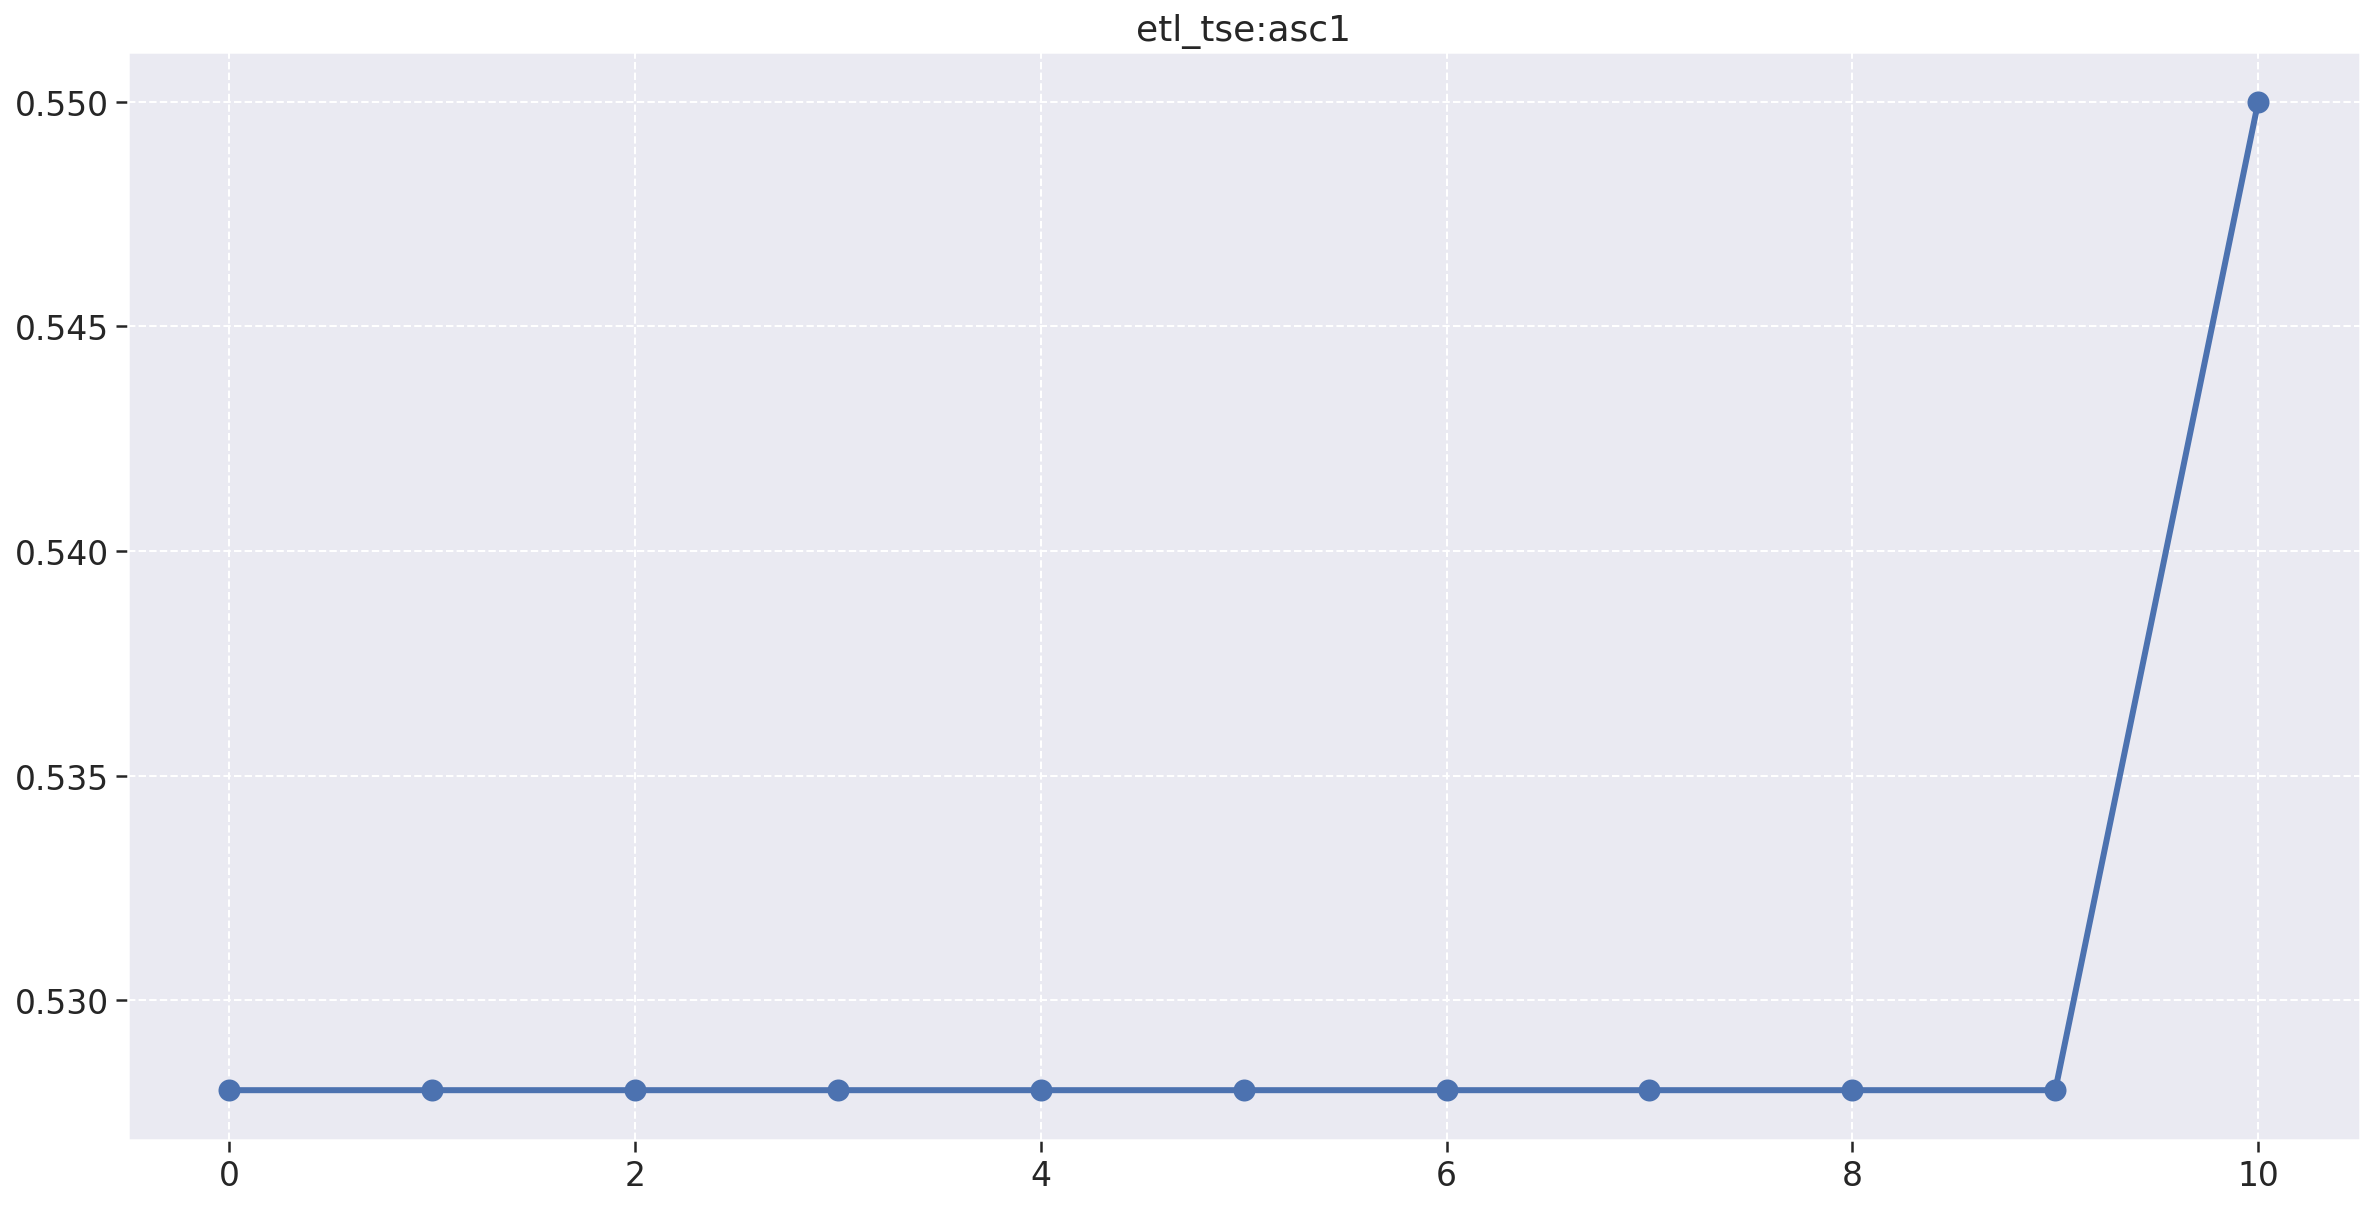

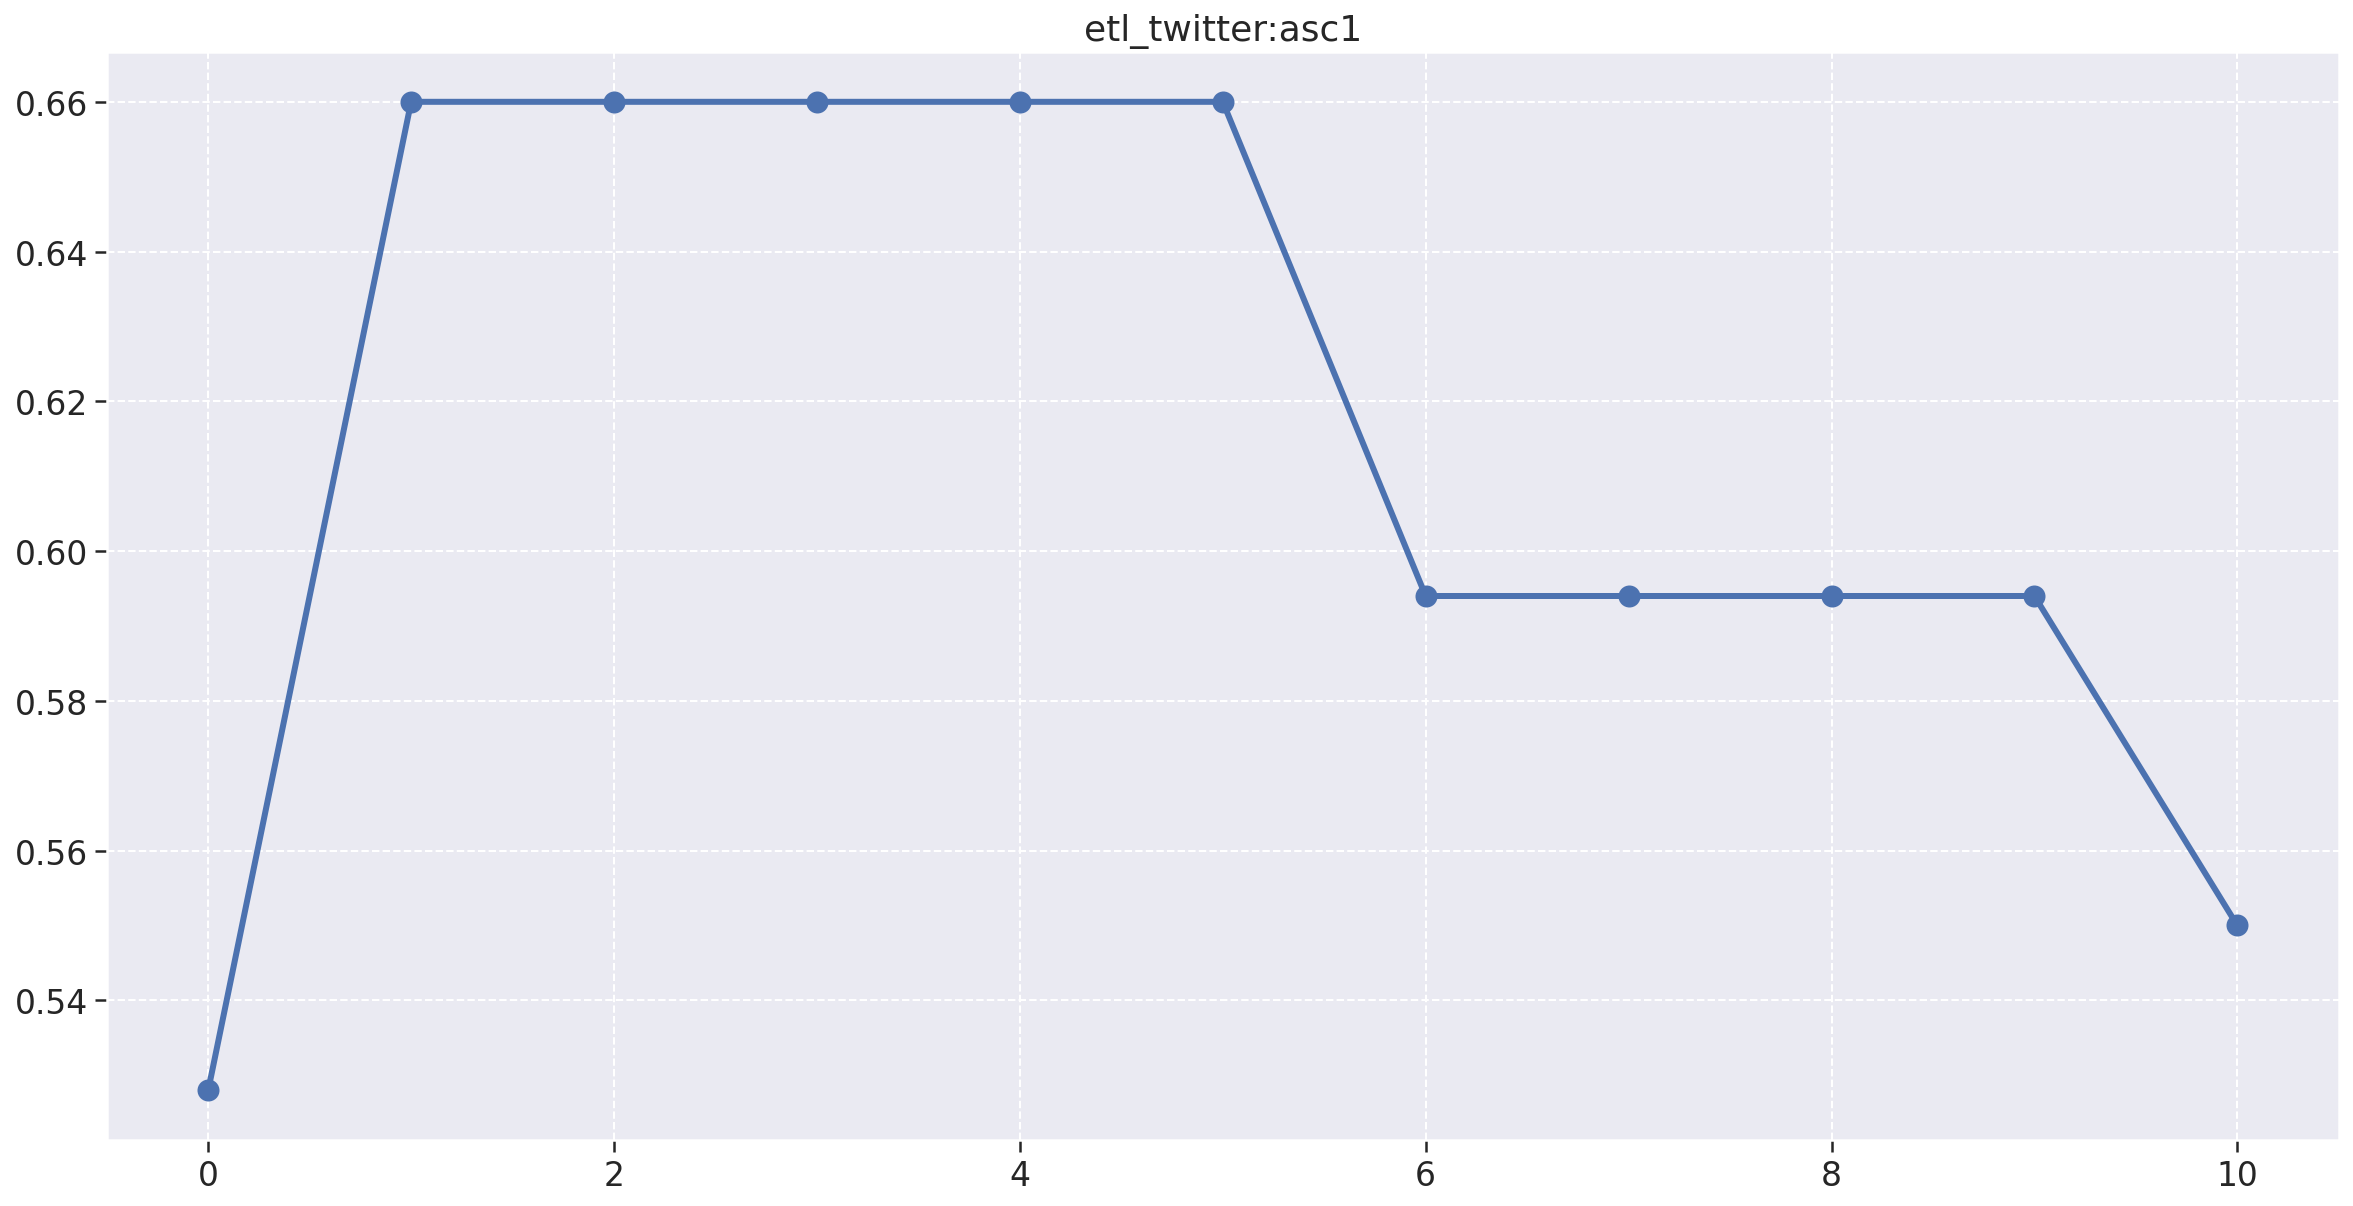

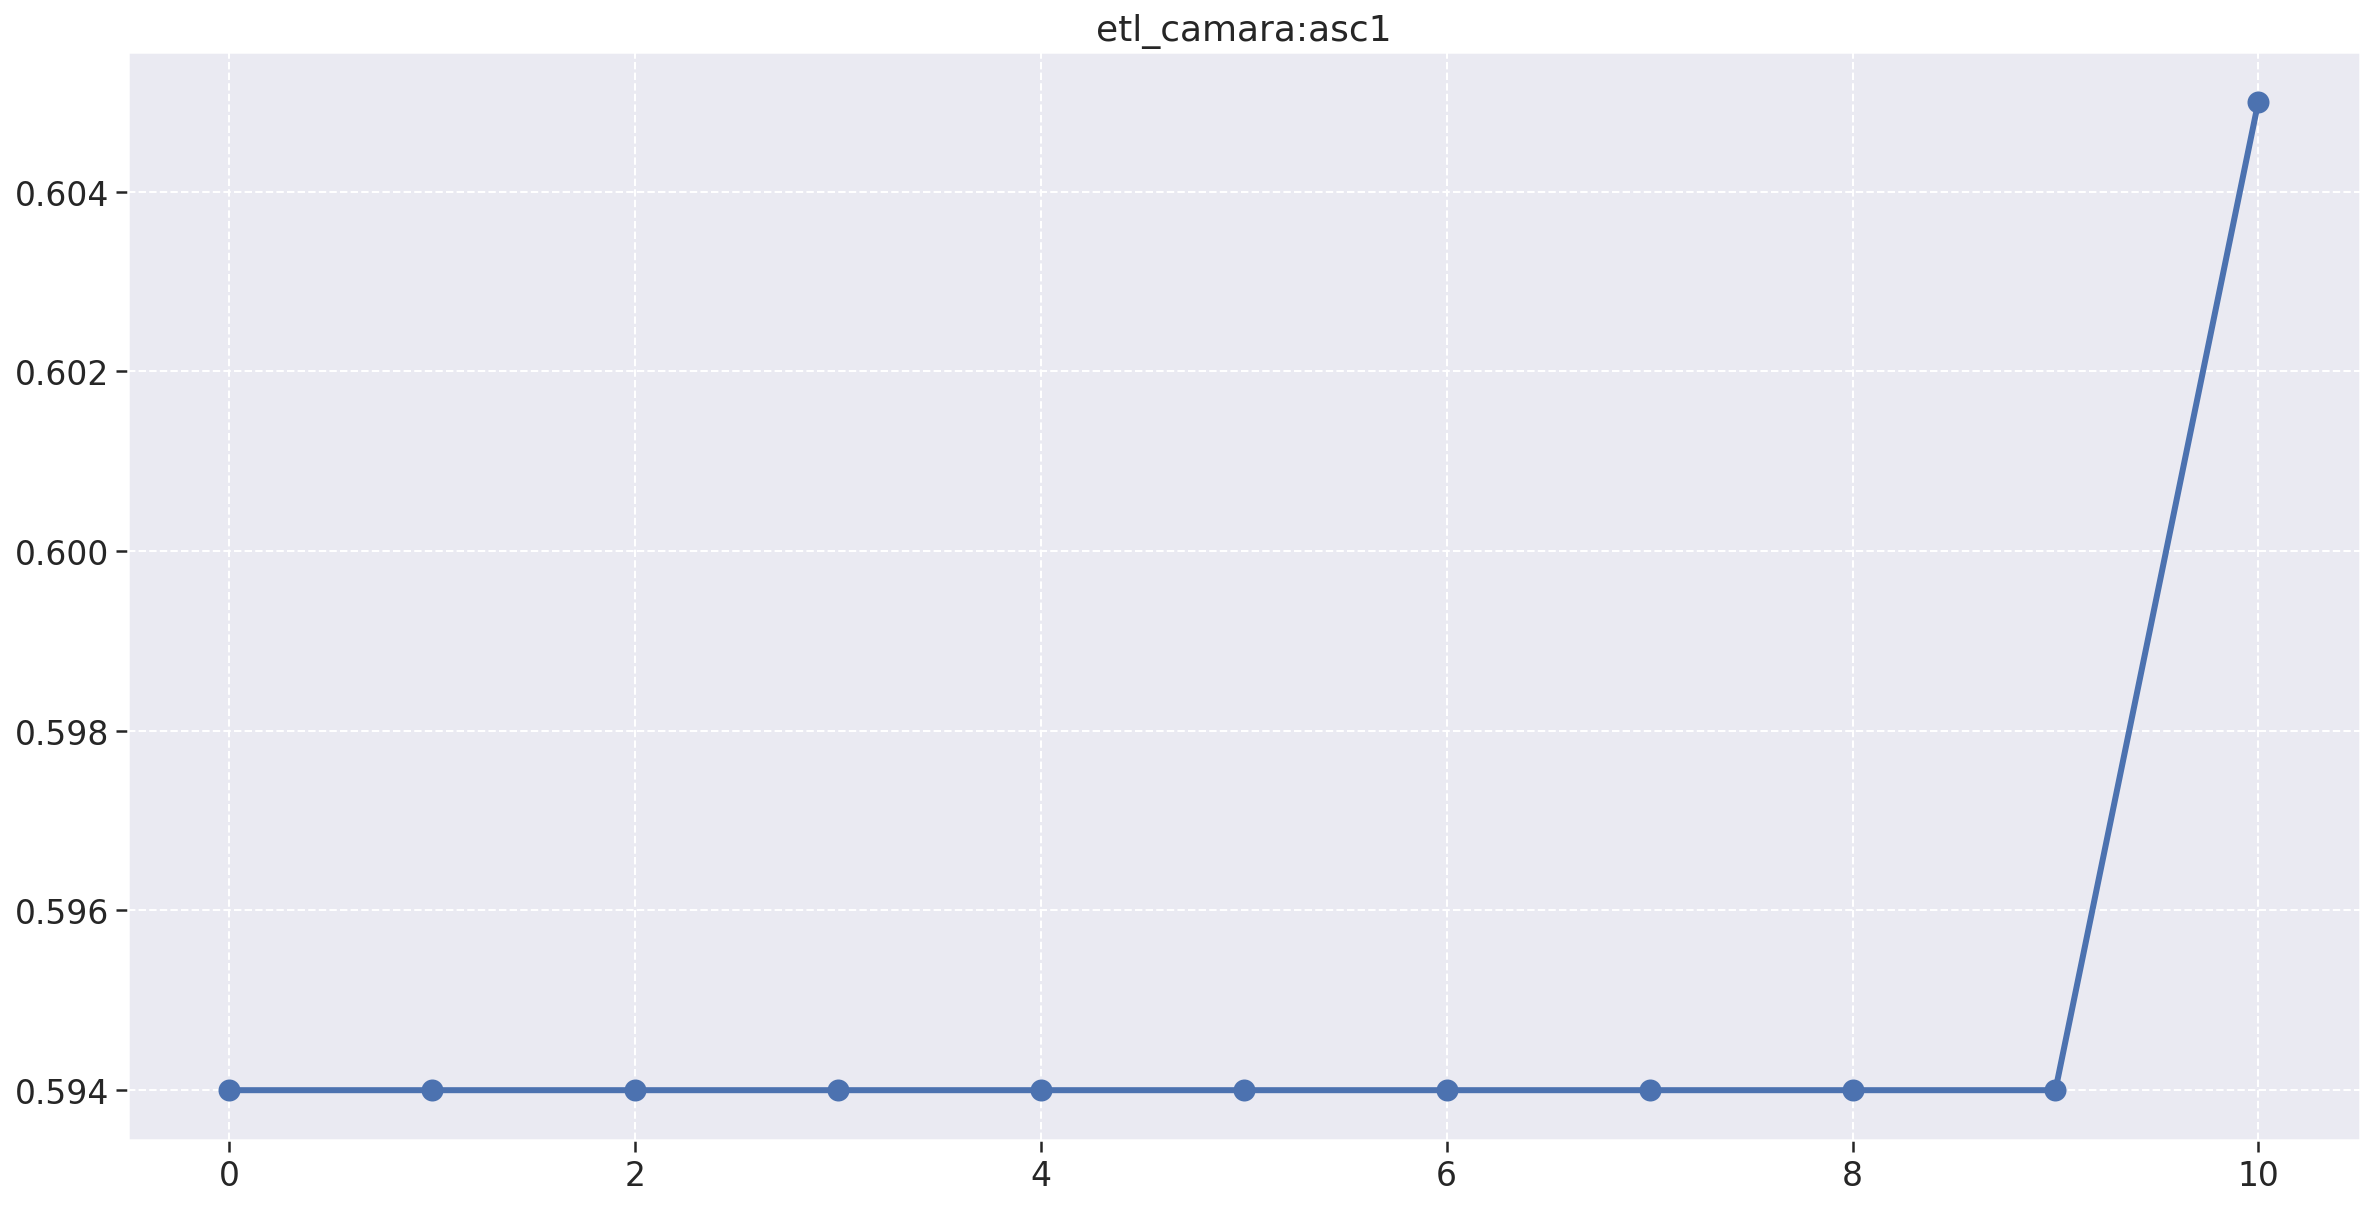

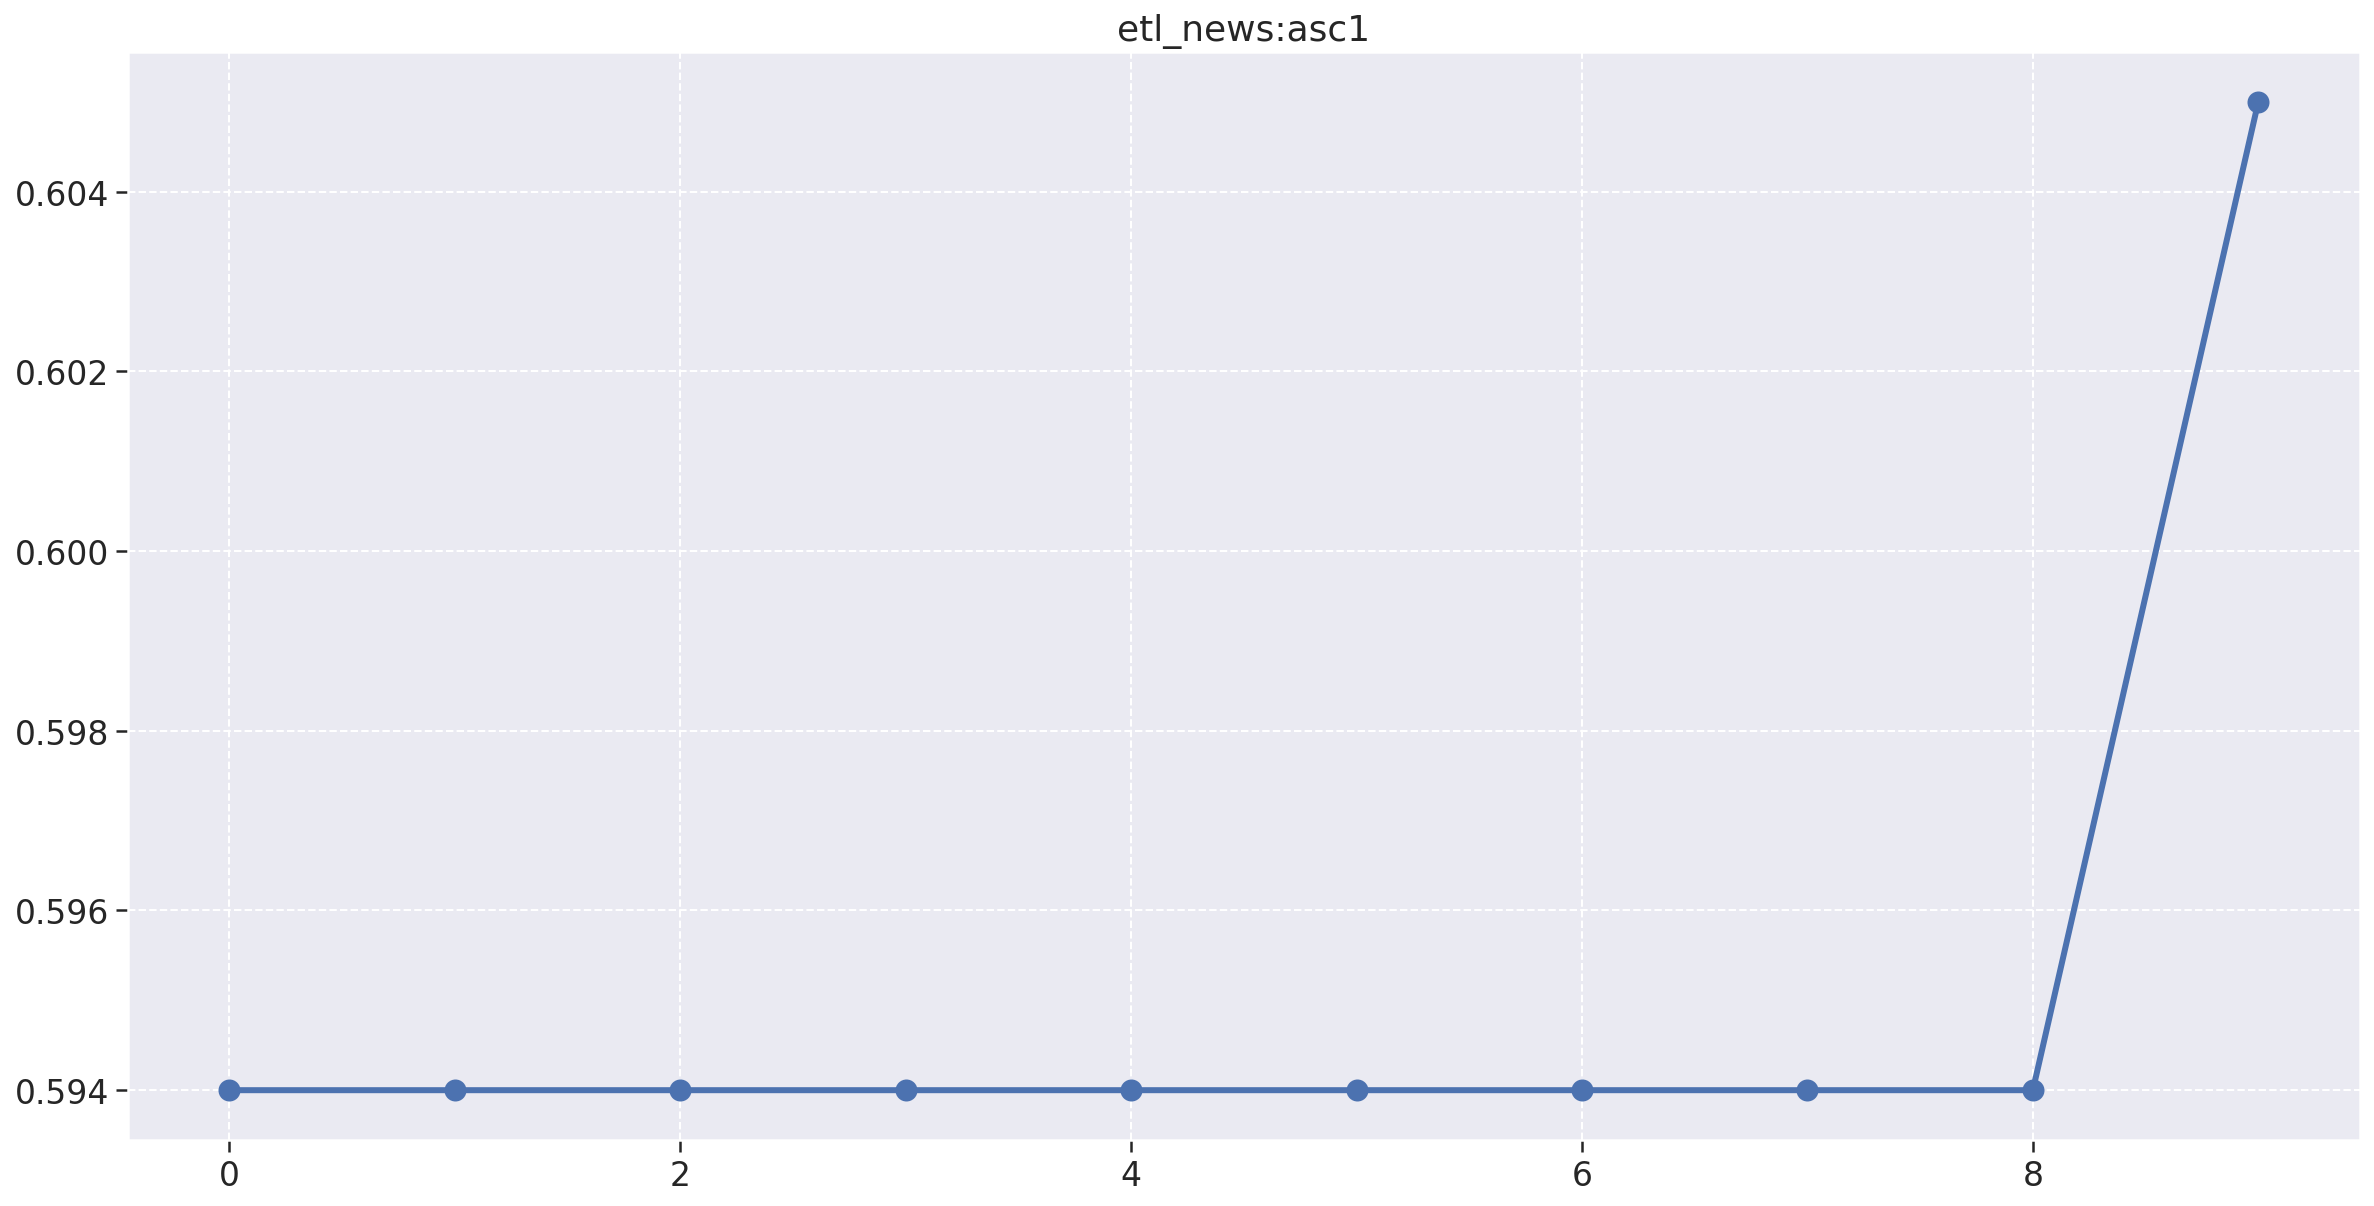

In [675]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:asc1")
    plt.plot(metrics_df['asc1'], linewidth=3, marker='o', markersize=10)

In [676]:
all_metrics_df = pd.DataFrame()

for repository, metrics_df in repository_metrics.items():
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

all_metrics_df['ac1'] = all_metrics_df['asc1'] * 1
all_metrics_df['total'] = all_metrics_df['asc1'] * 1

In [677]:
all_metrics_df

,m1,m2,m3,repository,version,ncloc,asc1,ac1,total
0,0.937500,0.125000,1.000000,frontend,2021-03-23 00:00:00,522,0.680625,0.680625,0.680625
1,0.964286,0.107143,1.000000,frontend,2021-04-18 00:00:00,1242,0.683571,0.683571,0.683571
2,0.966667,0.066667,1.000000,frontend,2021-05-01 00:00:00,1406,0.671000,0.671000,0.671000
3,0.966667,0.066667,1.000000,frontend,2021-05-02 00:00:00,1406,0.671000,0.671000,0.671000
4,0.966667,0.100000,1.000000,frontend,2021-05-04 00:00:00,1392,0.682000,0.682000,0.682000
5,0.968750,0.093750,0.937500,frontend,2021-05-09 00:00:00,1780,0.660000,0.660000,0.660000
6,0.968750,0.093750,0.937500,frontend,2021-05-09 01:00:00,1780,0.660000,0.660000,0.660000
7,0.968750,0.093750,0.937500,frontend,2021-05-09 02:00:00,1780,0.660000,0.660000,0.660000
8,0.968750,0.062500,0.937500,frontend,2021-05-10 00:00:00,1842,0.649687,0.649687,0.649687
9,0.971429,0.057143,0.971429,frontend,2021-05-10 01:00:00,2052,0.660000,0.660000,0.660000


In [678]:
all_metrics_df.to_csv('fga-eps-mds-2020-2-Parlamentaqui-qualidade-total-produto-18-05-2021-00:00.csv', index = False)

##  PRODUCTIVITY

In [679]:
jsons = glob('productivity/*.json') # add the path here

In [680]:
jsons

['productivity/gateway_issues.json',
 'productivity/documentation_issues.json',
 'productivity/frontend_issues.json']

In [681]:
# read the json files
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

In [682]:
gateway = read_json(jsons[0])
documentation = read_json(jsons[1])
frontend = read_json(jsons[2])

In [683]:
df_gateway = pd.DataFrame(gateway)
df_documentation = pd.DataFrame(documentation)
df_frontend = pd.DataFrame(frontend)

In [684]:
df_frontend

,number,title,labels,state,created_at,closed_at
0,2,US45 | Lista de deputados da home,"[FEATURE, HARD, MDS]",closed,2021-03-06T16:14:46Z,2021-03-13T16:29:19Z
1,3,Informações do perfil do deputado.,"[FEATURE, HARD, MDS]",closed,2021-03-06T16:15:47Z,2021-04-10T02:18:18Z
2,4,Documentação: Identidade visual,[DOCS],closed,2021-03-06T16:24:03Z,2021-03-20T18:38:19Z
3,5,Migrar lean inception,[DOCS],closed,2021-03-06T16:27:49Z,2021-03-20T18:37:59Z
4,6,Documento de visão,"[DOCS, FEATURE]",closed,2021-03-06T16:35:14Z,2021-03-20T18:38:01Z
5,7,Navegação superior,"[FEATURE, MDS, MEDIUM]",closed,2021-03-06T20:46:33Z,2021-03-13T16:13:06Z
6,8,Caminho de navegação,"[FEATURE, HARD, MDS]",closed,2021-03-06T20:53:07Z,2021-03-13T16:27:07Z
7,15,Instanciar/Criar componentes da tela de result...,"[EASY, FEATURE, MDS, US]",closed,2021-03-13T16:41:50Z,2021-03-20T18:38:17Z
8,16,Criar componente de ultimos tweets da página i...,"[EASY, FEATURE, MDS, US]",closed,2021-03-13T16:47:38Z,2021-03-20T18:38:06Z
9,17,Fazer breadcrumb ser conectado com o router,"[HARD, HOTFIX, MDS]",closed,2021-03-13T16:56:07Z,2021-03-20T18:38:20Z


In [685]:
repository_dataframes = {} 

repository_dataframes[f"frontend"] = df_frontend
repository_dataframes[f"documentation"] = df_documentation
repository_dataframes[f"gateway"] = df_gateway

In [686]:
repository_dataframes['frontend']

,number,title,labels,state,created_at,closed_at
0,2,US45 | Lista de deputados da home,"[FEATURE, HARD, MDS]",closed,2021-03-06T16:14:46Z,2021-03-13T16:29:19Z
1,3,Informações do perfil do deputado.,"[FEATURE, HARD, MDS]",closed,2021-03-06T16:15:47Z,2021-04-10T02:18:18Z
2,4,Documentação: Identidade visual,[DOCS],closed,2021-03-06T16:24:03Z,2021-03-20T18:38:19Z
3,5,Migrar lean inception,[DOCS],closed,2021-03-06T16:27:49Z,2021-03-20T18:37:59Z
4,6,Documento de visão,"[DOCS, FEATURE]",closed,2021-03-06T16:35:14Z,2021-03-20T18:38:01Z
5,7,Navegação superior,"[FEATURE, MDS, MEDIUM]",closed,2021-03-06T20:46:33Z,2021-03-13T16:13:06Z
6,8,Caminho de navegação,"[FEATURE, HARD, MDS]",closed,2021-03-06T20:53:07Z,2021-03-13T16:27:07Z
7,15,Instanciar/Criar componentes da tela de result...,"[EASY, FEATURE, MDS, US]",closed,2021-03-13T16:41:50Z,2021-03-20T18:38:17Z
8,16,Criar componente de ultimos tweets da página i...,"[EASY, FEATURE, MDS, US]",closed,2021-03-13T16:47:38Z,2021-03-20T18:38:06Z
9,17,Fazer breadcrumb ser conectado com o router,"[HARD, HOTFIX, MDS]",closed,2021-03-13T16:56:07Z,2021-03-20T18:38:20Z


In [687]:
for repo, df in repository_dataframes.items():
    repository_dataframes[f"{repo}"]["created_at"] = pd.to_datetime(df["created_at"])
    repository_dataframes[f"{repo}"]["closed_at"] = pd.to_datetime(df["closed_at"])
    repository_dataframes[f"{repo}"]["time_open"] = df["closed_at"] - df["created_at"]
    repository_dataframes[f"{repo}"]["repository"] = f"{repo}"

In [688]:
repository_dataframes['frontend']

,number,title,labels,state,created_at,closed_at,time_open,repository
0,2,US45 | Lista de deputados da home,"[FEATURE, HARD, MDS]",closed,2021-03-06 16:14:46+00:00,2021-03-13 16:29:19+00:00,7 days 00:14:33,frontend
1,3,Informações do perfil do deputado.,"[FEATURE, HARD, MDS]",closed,2021-03-06 16:15:47+00:00,2021-04-10 02:18:18+00:00,34 days 10:02:31,frontend
2,4,Documentação: Identidade visual,[DOCS],closed,2021-03-06 16:24:03+00:00,2021-03-20 18:38:19+00:00,14 days 02:14:16,frontend
3,5,Migrar lean inception,[DOCS],closed,2021-03-06 16:27:49+00:00,2021-03-20 18:37:59+00:00,14 days 02:10:10,frontend
4,6,Documento de visão,"[DOCS, FEATURE]",closed,2021-03-06 16:35:14+00:00,2021-03-20 18:38:01+00:00,14 days 02:02:47,frontend
5,7,Navegação superior,"[FEATURE, MDS, MEDIUM]",closed,2021-03-06 20:46:33+00:00,2021-03-13 16:13:06+00:00,6 days 19:26:33,frontend
6,8,Caminho de navegação,"[FEATURE, HARD, MDS]",closed,2021-03-06 20:53:07+00:00,2021-03-13 16:27:07+00:00,6 days 19:34:00,frontend
7,15,Instanciar/Criar componentes da tela de result...,"[EASY, FEATURE, MDS, US]",closed,2021-03-13 16:41:50+00:00,2021-03-20 18:38:17+00:00,7 days 01:56:27,frontend
8,16,Criar componente de ultimos tweets da página i...,"[EASY, FEATURE, MDS, US]",closed,2021-03-13 16:47:38+00:00,2021-03-20 18:38:06+00:00,7 days 01:50:28,frontend
9,17,Fazer breadcrumb ser conectado com o router,"[HARD, HOTFIX, MDS]",closed,2021-03-13 16:56:07+00:00,2021-03-20 18:38:20+00:00,7 days 01:42:13,frontend


In [689]:
sprint_times = [["1", pd.to_datetime("2021-03-06T00:00:00Z")],
                ["2", pd.to_datetime("2021-03-13T00:00:00Z")],
                ["3", pd.to_datetime("2021-03-20T00:00:00Z")],
                ["4", pd.to_datetime("2021-03-27T00:00:00Z")],
                ["5", pd.to_datetime("2021-04-03T00:00:00Z")],
                ["6", pd.to_datetime("2021-04-10T00:00:00Z")],
                ["7", pd.to_datetime("2021-04-17T00:00:00Z")],
                ["8", pd.to_datetime("2021-04-24T00:00:00Z")],
                ["9", pd.to_datetime("2021-05-01T00:00:00Z")],
                ["10", pd.to_datetime("2021-05-08T00:00:00Z")],
                ["11", pd.to_datetime("2021-05-15T00:00:00Z")],]

for sprint in sprint_times:
    sprint.append(sprint[1] + timedelta(days=6) + timedelta(hours=23) + timedelta(minutes=59) + timedelta(seconds=59))
    

In [690]:
def sprint_start(date):
    for sprint in sprint_times:
        if date > sprint[1] and date < sprint[2]:
            return sprint[0]
        
def close_sprint(date):
    for sprint in sprint_times:
            if date > sprint[1] and date < sprint[2] + timedelta(days=1):
                return sprint[0]

In [691]:
repository_dataframes[f"frontend"]["started_on_sprint"] = repository_dataframes[f"frontend"]["created_at"].apply(sprint_start)
repository_dataframes[f"gateway"]["started_on_sprint"] = repository_dataframes[f"gateway"]["created_at"].apply(sprint_start)
repository_dataframes[f"documentation"]["started_on_sprint"] = repository_dataframes[f"documentation"]["created_at"].apply(sprint_start)

In [692]:
repository_dataframes[f"frontend"]["closed_on_sprint"] = repository_dataframes[f"frontend"]["closed_at"].apply(close_sprint)
repository_dataframes[f"gateway"]["closed_on_sprint"] = repository_dataframes[f"gateway"]["closed_at"].apply(close_sprint)
repository_dataframes[f"documentation"]["closed_on_sprint"] = repository_dataframes[f"documentation"]["closed_at"].apply(close_sprint)

In [693]:
def count_labels(df):
    df = df.reset_index()
    tags = {
        "HOTFIX": 0,
        "DOCS": 0,
        "FEATURE": 0,
        "ARQ": 0,
        "DEVOPS": 0,
        "ANALYTICS": 0,
        "US": 0,
        "EASY": 0,
        "MEDIUM": 0,
        "HARD": 0,
        "EPS": 0,
        "MDS": 0
    }
    
    for line in range(len(df)):
        for label in df.loc[line]["labels"]:
            tags[label] = tags[label] + 1
            
    return tags

#### RESOLVED ISSUES' THROUGHPUT

In [694]:
def m7(number_of_issues_resolved, number_of_issues):
    
    resolved_issues_throughput = round((number_of_issues_resolved / number_of_issues) * 100, 2)
    
    return resolved_issues_throughput

#### ISSUE TYPE IN A TIMEFRAME


In [695]:
def density(issue, number_of_issues):
    issue_density = round((issue / number_of_issues) * 100, 2)
    return issue_density

def m8(tag_dict, number_of_issues):
    
    issue_densities = {
        "hotfix": [density(tag_dict["HOTFIX"], number_of_issues)],
        "docs": [density(tag_dict["DOCS"], number_of_issues)],
        "feature": [density(tag_dict["FEATURE"], number_of_issues)],
        "arq": [density(tag_dict["ARQ"], number_of_issues)],
        "devops": [density(tag_dict["DEVOPS"], number_of_issues)],
        "analytics": [density(tag_dict["ANALYTICS"], number_of_issues)],
        "us": [density(tag_dict["US"], number_of_issues)],
        "easy": [density(tag_dict["EASY"], number_of_issues)],
        "medium": [density(tag_dict["MEDIUM"], number_of_issues)],
        "hard": [density(tag_dict["HARD"], number_of_issues)],
        "eps": [density(tag_dict["EPS"], number_of_issues)],
        "mds": [density(tag_dict["MDS"], number_of_issues)]
    }

    issue_densities = pd.DataFrame.from_dict(issue_densities).T.reset_index()
    
    issue_densities.columns = ['density' ,'percentage']
    
    return issue_densities

#### BUGS RATIO

In [696]:
def m9(tag_dict, number_of_issues):
    
    bugs_ratio = round(((tag_dict["DOCS"] + tag_dict["FEATURE"] + tag_dict["ARQ"] + tag_dict["DEVOPS"] + tag_dict["ANALYTICS"]) / number_of_issues) * 100, 2)
    
    return bugs_ratio

In [697]:
df_frontend = repository_dataframes['frontend']
df_gateway = repository_dataframes['gateway']
df_documentation = repository_dataframes['documentation']

In [698]:
frontend_sprint_dataframes = {}

for i in df_frontend.started_on_sprint.unique(): 
    df = df_frontend[df_frontend["started_on_sprint"] == f"{i}"]
    if i == 8:
        df = df[0:0]
    TAGS = count_labels(df)
    NUMBER_OF_ISSUES_RESOLVED = len(df[(df["started_on_sprint"] == f"{i}") & (df["closed_on_sprint"] == f"{i}")])
    NUMBER_OF_ISSUES = len(df)
    df = df_frontend[df_frontend["started_on_sprint"] == f"{i}"]
    frontend_sprint_dataframes[f"{i}"] = { "df": df,
                                  "TAGS":TAGS,
                                  "NUMBER_OF_ISSUES_RESOLVED": NUMBER_OF_ISSUES_RESOLVED,
                                  "NUMBER_OF_ISSUES": NUMBER_OF_ISSUES, 
                                  "m7": m7(NUMBER_OF_ISSUES_RESOLVED, NUMBER_OF_ISSUES),
                                  "m8": m8(TAGS, NUMBER_OF_ISSUES),
                                  "m9": m9(TAGS, NUMBER_OF_ISSUES),
                                  "no_sprint": i,
                                  "data_inicio": sprint_times[int(i)-1][1],
                                  "data_fim": sprint_times[int(i)-1][2],
                                }

In [699]:
gateway_sprint_dataframes = {}

for i in df_gateway.started_on_sprint.unique(): 
    df = df_gateway[df_gateway["started_on_sprint"] == f"{i}"]
    if i == 8:
        df = df[0:0]
    TAGS = count_labels(df)
    NUMBER_OF_ISSUES_RESOLVED = len(df[(df["started_on_sprint"] == f"{i}") & (df["closed_on_sprint"] == f"{i}")])
    NUMBER_OF_ISSUES = len(df)
    df = df_gateway[df_gateway["started_on_sprint"] == f"{i}"]
    gateway_sprint_dataframes[f"{i}"] = { "df": df,
                                  "TAGS":TAGS,
                                  "NUMBER_OF_ISSUES_RESOLVED": NUMBER_OF_ISSUES_RESOLVED,
                                  "NUMBER_OF_ISSUES": NUMBER_OF_ISSUES, 
                                  "m7": m7(NUMBER_OF_ISSUES_RESOLVED, NUMBER_OF_ISSUES),
                                  "m8": m8(TAGS, NUMBER_OF_ISSUES),
                                  "m9": m9(TAGS, NUMBER_OF_ISSUES),
                                  "no_sprint": i,
                                  "data_inicio": sprint_times[int(i)-1][1],
                                  "data_fim": sprint_times[int(i)-1][2],
                                }

In [700]:
documentation_sprint_dataframes = {}

for i in df_documentation.started_on_sprint.unique(): 
    df = df_documentation[df_documentation["started_on_sprint"] == f"{i}"]
    if i == 8:
        df = df[0:0]
    TAGS = count_labels(df)
    NUMBER_OF_ISSUES_RESOLVED = len(df[(df["started_on_sprint"] == f"{i}") & (df["closed_on_sprint"] == f"{i}")])
    NUMBER_OF_ISSUES = len(df)
    df = df_documentation[df_documentation["started_on_sprint"] == f"{i}"]
    documentation_sprint_dataframes[f"{i}"] = { "df": df,
                                  "TAGS":TAGS,
                                  "NUMBER_OF_ISSUES_RESOLVED": NUMBER_OF_ISSUES_RESOLVED,
                                  "NUMBER_OF_ISSUES": NUMBER_OF_ISSUES, 
                                  "m7": m7(NUMBER_OF_ISSUES_RESOLVED, NUMBER_OF_ISSUES),
                                  "m8": m8(TAGS, NUMBER_OF_ISSUES),
                                  "m9": m9(TAGS, NUMBER_OF_ISSUES),
                                  "no_sprint": i,
                                  "data_inicio": sprint_times[int(i)-1][1],
                                  "data_fim": sprint_times[int(i)-1][2],
                                }

In [711]:
for sprint, df in frontend_sprint_dataframes.items(): 
     df["df"].to_csv(f'fga-eps-mds-2020-2-{"parlamentaqui_frontend"}-qualidade-total-processo-m8-{sprint}.csv', index = False)
        
for sprint, df in gateway_sprint_dataframes.items(): 
     df["df"].to_csv(f'fga-eps-mds-2020-2-{"parlamentaqui_gateway"}-qualidade-total-processo-m8-{sprint}.csv', index = False)
        
for sprint, df in documentation_sprint_dataframes.items(): 
     df["df"].to_csv(f'fga-eps-mds-2020-2-{"parlamentaqui_documentation"}-qualidade-total-processo-m8-{sprint}.csv', index = False)    

In [702]:
productivity_metrics_frontend_df = pd.DataFrame(columns=["data_inicio", "data_fim", "m7", "m9", "no_sprint"])
productivity_metrics_gateway_df = pd.DataFrame(columns=["data_inicio", "data_fim", "m7", "m9", "no_sprint"])
productivity_metrics_documentation_df = pd.DataFrame(columns=["data_inicio", "data_fim", "m7", "m9", "no_sprint"])

In [703]:
for sprint in frontend_sprint_dataframes:
    productivity_metrics_frontend_df = productivity_metrics_frontend_df.append(dict(zip(productivity_metrics_df.columns,[ 
              frontend_sprint_dataframes[f"{sprint}"]["data_inicio"],
              frontend_sprint_dataframes[f"{sprint}"]["data_fim"], 
              frontend_sprint_dataframes[f"{sprint}"]["m7"], 
              frontend_sprint_dataframes[f"{sprint}"]["m9"], 
              frontend_sprint_dataframes[f"{sprint}"]["no_sprint"]
            ])), ignore_index=True)
    
for sprint in gateway_sprint_dataframes:
    productivity_metrics_gateway_df = productivity_metrics_gateway_df.append(dict(zip(productivity_metrics_df.columns,[ 
              gateway_sprint_dataframes[f"{sprint}"]["data_inicio"],
              gateway_sprint_dataframes[f"{sprint}"]["data_fim"], 
              gateway_sprint_dataframes[f"{sprint}"]["m7"], 
              gateway_sprint_dataframes[f"{sprint}"]["m9"], 
              gateway_sprint_dataframes[f"{sprint}"]["no_sprint"]
            ])), ignore_index=True)
    
for sprint in documentation_sprint_dataframes:
    productivity_metrics_documentation_df = productivity_metrics_documentation_df.append(dict(zip(productivity_metrics_df.columns,[ 
              documentation_sprint_dataframes[f"{sprint}"]["data_inicio"],
              documentation_sprint_dataframes[f"{sprint}"]["data_fim"], 
              documentation_sprint_dataframes[f"{sprint}"]["m7"], 
              documentation_sprint_dataframes[f"{sprint}"]["m9"], 
              documentation_sprint_dataframes[f"{sprint}"]["no_sprint"]
            ])), ignore_index=True)

In [704]:
productivity_metrics_frontend_df["data_inicio"] = productivity_metrics_frontend_df["data_inicio"].dt.strftime("%d-%m-%Y-%H-%M")
productivity_metrics_frontend_df["data_fim"] = productivity_metrics_frontend_df["data_fim"].dt.strftime("%d-%m-%Y-%H-%M")

productivity_metrics_gateway_df["data_inicio"] = productivity_metrics_gateway_df["data_inicio"].dt.strftime("%d-%m-%Y-%H-%M")
productivity_metrics_gateway_df["data_fim"] = productivity_metrics_gateway_df["data_fim"].dt.strftime("%d-%m-%Y-%H-%M")

productivity_metrics_documentation_df["data_inicio"] = productivity_metrics_documentation_df["data_inicio"].dt.strftime("%d-%m-%Y-%H-%M")
productivity_metrics_documentation_df["data_fim"] = productivity_metrics_documentation_df["data_fim"].dt.strftime("%d-%m-%Y-%H-%M")

In [705]:
productivity_metrics_gateway_df

,data_inicio,data_fim,m7,m9,no_sprint
0,06-03-2021-00-00,12-03-2021-23-59,0.00,200.00,1
1,13-03-2021-00-00,19-03-2021-23-59,0.00,100.00,2
2,20-03-2021-00-00,26-03-2021-23-59,0.00,125.00,3
3,10-04-2021-00-00,16-04-2021-23-59,20.00,100.00,6
4,17-04-2021-00-00,23-04-2021-23-59,66.67,66.67,7
5,01-05-2021-00-00,07-05-2021-23-59,0.00,0.00,9


In [706]:
productivity_metrics_documentation_df

,data_inicio,data_fim,m7,m9,no_sprint
0,20-03-2021-00-00,26-03-2021-23-59,85.71,100.00,3
1,10-04-2021-00-00,16-04-2021-23-59,0.00,33.33,6
2,17-04-2021-00-00,23-04-2021-23-59,33.33,100.00,7


In [707]:
productivity_metrics_frontend_df

,data_inicio,data_fim,m7,m9,no_sprint
0,06-03-2021-00-00,12-03-2021-23-59,42.86,114.29,1
1,13-03-2021-00-00,19-03-2021-23-59,100.00,66.67,2
2,20-03-2021-00-00,26-03-2021-23-59,0.00,92.86,3
3,27-03-2021-00-00,02-04-2021-23-59,0.00,100.00,4
4,03-04-2021-00-00,09-04-2021-23-59,0.00,0.00,5
5,10-04-2021-00-00,16-04-2021-23-59,20.00,60.00,6
6,17-04-2021-00-00,23-04-2021-23-59,22.22,44.44,7
7,01-05-2021-00-00,07-05-2021-23-59,0.00,80.00,9
8,08-05-2021-00-00,14-05-2021-23-59,0.00,100.00,10
9,15-05-2021-00-00,21-05-2021-23-59,20.00,100.00,11
